# --- Preliminary ---

### Google drive

In [1]:
# !pip install --upgrade ipython ipykernel

In [2]:
# %load_ext autoreload
# %autoreload 2

!pip install python-dotenv --quiet

from google.colab import drive

drive.mount("/content/drive")

import getpass
import dotenv
import wandb
import os

dotenv.load_dotenv(
    os.path.join("/content/drive/MyDrive/Colab Notebooks", "wandbkey.env.txt")
)
api_key = os.getenv("WANDB_API_KEY")
wandb.login(key=api_key)

project_folder = "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis"
data_folder = os.path.join(project_folder, "data")
experiment_folder = os.path.join(project_folder, "experiments")

import torch as t

DEVICE = t.device("cuda" if t.cuda.is_available() else "cpu")
print(DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: benwilop (benwilop-rwth-aachen-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


cuda


### Installs

In [3]:
!pip install psutil
!pip install pgn
!pip install transformer_lens
!pip install eindex-callum
!pip install pgn
!pip install jaxtyping
!pip install eindex

In [4]:
!pip install eindex

### Imports

In [5]:
# standard library
import gc
import pickle
from dataclasses import dataclass
from math import floor, ceil
import math
from typing import Optional, List
from copy import copy, deepcopy
from datetime import datetime
from enum import Enum
import glob
import os
import time
import multiprocessing
import itertools
import random
import logging
import sys
from collections import Counter
from pathlib import Path
from enum import Enum

# miscellaneous
import psutil
import pgn
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import jensenshannon
from scipy import stats

# tensors
import numpy as np
import pandas as pd
import torch as t
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import LambdaLR
from jaxtyping import Bool, Float, Int
import einops
# from eindex import eindex

# transformer_lens
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint
from transformer_lens.utils import download_file_from_hf, get_act_name, to_numpy
from transformer_lens.pretrained.weight_conversions.mingpt import convert_mingpt_weights
from transformer_lens.utilities.devices import move_to_and_update_config

# visuals
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.express as px
from tqdm import tqdm

# --- /data ---

### Data description

- The vocabulary size is 61, because we allow any of the 8x8 - 4 = 60 unoccupied squares to be played, plus the pass move. The vocab is ordered `pass, A0, A1, ..., H7`. Note that we'll be filtering out games where a `pass` move was played, so we don't need to worry about this.
- We'll refer to squares in 3 different ways:
    1. **label** - this is the string representation, i.e. `"pass"`, `"A0"`, `"A1"`, ..., `"H7"`.
    2. **token id**, or **id** - this is the token ID in the model's vocab, i.e. `1` for A0, ..., `60` for H7. We skip `0` which is the token id for `pass`, and we skip the 4 middle squares since they're always occupied and so there are no moves in or predictions for these squares.
    3. **square index**, or **square** - this is the zero-indexed value of the square in the size-64 board, i.e. `0` for A0, `1` for A1, ..., `63` for H7.
- Black plays first in Othello, and so (in games with no passes) White plays last. Since we don't predict the very first move, this means the model's predictions are for (white 1, black 2, white 2, ..., white 29, black 30, white 30).


### othello_board_state.py

In [6]:
rows = list("abcdefgh")
columns = [str(_) for _ in range(1, 9)]
eights = [[-1, 0], [-1, 1], [0, 1], [1, 1], [1, 0], [1, -1], [0, -1], [-1, -1]]
fours = [[-1, 0], [1, 0], [0, 1], [0, -1]]


def permit(s):
    """Chess notation to board index: a3 -> 2, A3 -> 2, b3 -> 10"""
    s = s.lower()
    if len(s) != 2:
        return -1
    if s[0] not in rows or s[1] not in columns:
        return -1
    return rows.index(s[0]) * 8 + columns.index(s[1])


def permit_reverse(integer):
    """Board index to chess notation: 2 -> a3, 10 -> b3"""
    r, c = integer // 8, integer % 8
    return "".join([rows[r], columns[c]])


class OthelloBoardState:
    # 1 is black (X), -1 is white (O)
    def __init__(self, board_size=8):
        self.board_size = board_size * board_size
        board = np.zeros((8, 8))
        board[3, 4] = 1
        board[3, 3] = -1
        board[4, 3] = 1
        board[4, 4] = -1
        self.initial_state = board
        self.state = self.initial_state
        self.age = np.zeros((8, 8))
        self.next_hand_color = 1
        self.history = []

    def get_occupied(self):
        """List, 1 if occupied, 0 if not."""
        board = self.state
        tbr = board.flatten() != 0
        return tbr.tolist()

    def get_state(self):
        """List, white 0, blank 1, black 2."""
        board = self.state + 1  # white 0, blank 1, black 2
        tbr = board.flatten()
        return tbr.tolist()

    def get_age(self):
        """List, round index where stone was placed, 0 else."""
        return self.age.flatten().tolist()

    def get_next_hand_color(self):
        """1 if black, -1 if white."""
        return (self.next_hand_color + 1) // 2

    def update(self, moves: list[int], prt=False):
        """Applies moves and updates state (move is a square index 0, ..., 63)"""
        if prt:
            self.__print__()
        for _, move in enumerate(moves):
            self.umpire(move)
            if prt:
                self.__print__()

    def umpire(self, move):
        """Applies one move and updates state (move is a square index 0, ..., 63)"""
        r, c = move // 8, move % 8
        assert self.state[r, c] == 0, f"{r}-{c} is already occupied!"
        occupied = np.sum(self.state != 0)
        color = self.next_hand_color
        tbf = []
        for direction in eights:
            buffer = []
            cur_r, cur_c = r, c
            while 1:
                cur_r, cur_c = cur_r + direction[0], cur_c + direction[1]
                if cur_r < 0 or cur_r > 7 or cur_c < 0 or cur_c > 7:
                    break
                if self.state[cur_r, cur_c] == 0:
                    break
                elif self.state[cur_r, cur_c] == color:
                    tbf.extend(buffer)
                    break
                else:
                    buffer.append([cur_r, cur_c])

        if len(tbf) == 0:  # means one hand is forfeited
            # print(f"One {color} move forfeited")
            color *= -1
            self.next_hand_color *= -1
            for direction in eights:
                buffer = []
                cur_r, cur_c = r, c
                while 1:
                    cur_r, cur_c = cur_r + direction[0], cur_c + direction[1]
                    if cur_r < 0 or cur_r > 7 or cur_c < 0 or cur_c > 7:
                        break
                    if self.state[cur_r, cur_c] == 0:
                        break
                    elif self.state[cur_r, cur_c] == color:
                        tbf.extend(buffer)
                        break
                    else:
                        buffer.append([cur_r, cur_c])

        if len(tbf) == 0:
            valids = self.get_valid_moves()
            if len(valids) == 0:
                assert 0, "Both color cannot put piece, game should have ended!"
            else:
                assert 0, "Illegal move!"

        self.age += 1
        for ff in tbf:
            self.state[ff[0], ff[1]] *= -1
            self.age[ff[0], ff[1]] = 0
        self.state[r, c] = color
        self.age[r, c] = 0
        self.next_hand_color *= -1
        self.history.append(move)

    def __print__(
        self,
    ):
        """Prints the board and move history-"""
        print("-" * 20)
        print([permit_reverse(_) for _ in self.history])
        a = "abcdefgh"
        for k, row in enumerate(self.state.tolist()):
            tbp = []
            for ele in row:
                if ele == -1:
                    tbp.append("O")
                elif ele == 0:
                    tbp.append(" ")
                else:
                    tbp.append("X")
            # tbp.append("\n")
            print(" ".join([a[k]] + tbp))
        tbp = [str(k) for k in range(1, 9)]
        print(" ".join([" "] + tbp))
        print("-" * 20)

    def tentative_move(self, move):
        """
        tentatively put a piece, do nothing to state
        - returns 0 if this is not a move at all: occupied or both player have to forfeit
        - return 1 if regular move
        - return 2 if forfeit happens but the opponent can drop piece at this place
        """
        r, c = move // 8, move % 8
        if not self.state[r, c] == 0:
            return 0
        occupied = np.sum(self.state != 0)
        color = self.next_hand_color
        tbf = []
        for direction in eights:
            buffer = []
            cur_r, cur_c = r, c
            while 1:
                cur_r, cur_c = cur_r + direction[0], cur_c + direction[1]
                if cur_r < 0 or cur_r > 7 or cur_c < 0 or cur_c > 7:
                    break
                if self.state[cur_r, cur_c] == 0:
                    break
                elif self.state[cur_r, cur_c] == color:
                    tbf.extend(buffer)
                    break
                else:
                    buffer.append([cur_r, cur_c])
        if len(tbf) != 0:
            return 1
        else:  # means one hand is forfeited
            # print(f"One {color} move forfeited")
            color *= -1
            # self.next_hand_color *= -1
            for direction in eights:
                buffer = []
                cur_r, cur_c = r, c
                while 1:
                    cur_r, cur_c = cur_r + direction[0], cur_c + direction[1]
                    if cur_r < 0 or cur_r > 7 or cur_c < 0 or cur_c > 7:
                        break
                    if self.state[cur_r, cur_c] == 0:
                        break
                    elif self.state[cur_r, cur_c] == color:
                        tbf.extend(buffer)
                        break
                    else:
                        buffer.append([cur_r, cur_c])
            if len(tbf) == 0:
                return 0
            else:
                return 2

    def get_valid_moves(self):
        """
        Returns a list of square indices (0-63) where at least one player
        could place a stone, i.e. either the player whos turn it is or if he
        forfeits the other player.
        """
        regular_moves = []
        forfeit_moves = []
        for move in range(64):
            x = self.tentative_move(move)
            if x == 1:
                regular_moves.append(move)
            elif x == 2:
                forfeit_moves.append(move)
            else:
                pass
        if len(regular_moves):
            return regular_moves
        elif len(forfeit_moves):
            return forfeit_moves
        else:
            return []

    def get_gt(self, moves, func, prt=False):
        """
        Applies moves (list of square indices 0-63).
        Returns list of result of func after each move.
        Example:
        - game already had 13 moves
        - game.get_gt([45,6,18], 'get_age')
        - returns: [13, 14, 15]
        """
        # takes a new move or new moves and update state
        container = []
        if prt:
            self.__print__()
        for _, move in enumerate(moves):
            self.umpire(move)
            container.append(getattr(self, func)())
            # to predict first y, we need already know the first x
            if prt:
                self.__print__()
        return container

    # NEXT_TO_OPPONENT rule
    def get_moves_next_to_opponent(self):
        """
        Returns a list of square indices (0-63) that are:
        1. Empty
        2. Adjacent to at least one opponent piece
        Handles passing like standard Othello.
        """

        def _get_moves_for_color(color):
            opponent_color = -color
            moves = []
            for move in range(64):
                r, c = move // 8, move % 8
                if self.state[r, c] != 0:
                    continue
                for direction in fours:
                    adj_r, adj_c = r + direction[0], c + direction[1]
                    if 0 <= adj_r < 8 and 0 <= adj_c < 8:
                        if self.state[adj_r, adj_c] == opponent_color:
                            moves.append(move)
                            break
            return moves

        # Try current player first
        moves = _get_moves_for_color(self.next_hand_color)
        if moves:
            return moves

        # If no moves, try opponent (forfeit)
        moves = _get_moves_for_color(-self.next_hand_color)
        return moves

    def place_next_to_opponent(self, move):
        """Place a stone and flipps adjacent opponent pieces, handles forfeiting like umpire()."""
        r, c = move // 8, move % 8
        assert self.state[r, c] == 0, f"{r}-{c} is already occupied!"

        color = self.next_hand_color
        opponent_color = -color

        # Check if move is adjacent to opponent
        is_valid = False
        for direction in fours:
            adj_r, adj_c = r + direction[0], c + direction[1]
            if 0 <= adj_r < 8 and 0 <= adj_c < 8:
                if self.state[adj_r, adj_c] == opponent_color:
                    is_valid = True
                    break

        if not is_valid:  # forfeit - try opposite color
            color *= -1
            self.next_hand_color *= -1  # Switch whose turn it is
            opponent_color = -color
            for direction in fours:
                adj_r, adj_c = r + direction[0], c + direction[1]
                if 0 <= adj_r < 8 and 0 <= adj_c < 8:
                    if self.state[adj_r, adj_c] == opponent_color:
                        is_valid = True
                        break

        if not is_valid:
            # Check if any moves possible at all
            moves = self.get_moves_next_to_opponent()
            if len(moves) == 0:
                assert 0, "Both colors cannot put piece, game should have ended!"
            else:
                assert 0, "Illegal move!"

        self.age += 1
        self.state[r, c] = color
        self.age[r, c] = 0

        # Now flip all adjacent opponent stones
        for direction in fours:
            adj_r, adj_c = r + direction[0], c + direction[1]
            if 0 <= adj_r < 8 and 0 <= adj_c < 8:
                if self.state[adj_r, adj_c] == opponent_color:
                    self.state[adj_r, adj_c] = color  # flip to our color
                    self.age[adj_r, adj_c] = 0  # reset age

        self.next_hand_color *= -1  # Switch turns after placing
        self.history.append(move)

    def place_no_flipping(self, move):
        """Place a stone and does not flip any opponent pieces"""
        r, c = move // 8, move % 8
        assert self.state[r, c] == 0, f"{r}-{c} is already occupied!"
        self.age += 1
        self.state[r, c] = self.next_hand_color
        self.age[r, c] = 0
        self.next_hand_color *= -1
        self.history.append(move)

### map_between_othello_representations.py

In [7]:
MIDDLE_SQUARES = [27, 28, 35, 36]
ALL_SQUARES = [i for i in range(64) if i not in MIDDLE_SQUARES]

# Vocab (i.e. token IDs)
VOCAB = list(range(61))  # pass + 60 open fields

# Lists to map between token IDs (1 to 60, not including pass token) and square indices (0 to 63 inclusive)
ID_TO_SQUARE = {
    0: -100,
    **{id: square for id, square in enumerate(ALL_SQUARES, start=1)},
}
SQUARE_TO_ID = {square: id for id, square in ID_TO_SQUARE.items()}


alpha = "ABCDEFGH"


def to_board_label(i):
    return f"{alpha[i // 8]}{i % 8}"


board_labels = list(map(to_board_label, ALL_SQUARES))


def str_to_id(s):
    return SQUARE_TO_ID[s] - 1


def to_id(x):
    """
    Maps from either square (0, 63) or board label (A0, H7) to id (1, 60).
    """
    if isinstance(x, t.Tensor) and x.numel() == 1:
        return to_id(x.item())
    elif isinstance(x, list) or isinstance(x, t.Tensor) or isinstance(x, np.ndarray):
        return [to_id(i) for i in x]
    elif isinstance(x, int):
        return SQUARE_TO_ID[x]
    elif isinstance(x, str):
        x = x.upper()
        return to_id(to_square(x))


def to_square(x):
    """
    Maps from either id (1, 60) or board label (A0, H7) to square (0, 63).
    """
    if isinstance(x, t.Tensor) and x.numel() == 1:
        return to_square(x.item())
    elif isinstance(x, list) or isinstance(x, t.Tensor) or isinstance(x, np.ndarray):
        return [to_square(i) for i in x]
    elif isinstance(x, int):
        return ID_TO_SQUARE[x]
    elif isinstance(x, str):
        x = x.upper()
        return 8 * alpha.index(x[0]) + int(x[1])


def to_label(x, from_square=True):
    """
    Maps from either id (1, 60) or square (0, 63) to board label (A0, H7).
    """
    if isinstance(x, t.Tensor) and x.numel() == 1:
        return to_label(x.item(), from_square=from_square)
    elif isinstance(x, list) or isinstance(x, t.Tensor) or isinstance(x, np.ndarray):
        return [to_label(i, from_square=from_square) for i in x]
    elif isinstance(x, int):
        if from_square:
            return to_board_label(to_square(x))
        else:
            return to_board_label(x)
    elif isinstance(x, str):
        return x


def square_to_label(x):
    return to_label(x, from_square=False)


def id_to_label(x):
    return to_label(x, from_square=True)


def id_to_square(x):
    return to_square(x)


def label_to_square(x):
    return to_square(x)


def square_to_id(x):
    return to_id(x)


def label_to_id(x):
    return to_id(x)


def moves_to_state(moves):
    # moves is a list of square entries (ints from 0 to 63)
    state = np.zeros((8, 8), dtype=bool)
    for move in moves:
        state[move // 8, move % 8] = 1.0
    return state

### othello.py

In [8]:
class OthelloRule(Enum):
    STANDARD = "standard"
    BIAS_CLOCK = "bias_clock"
    UNTRAINED = "untrained"
    CHESS = "chess"
    TINY_STORIES = "tiny_stories"
    NEXT_TO_OPPONENT = "next_to_opponent"
    CONSTANT_PARAMETERS = "constant_parameters"
    NO_FLIPPING = "no_flipping"


class Goal(Enum):
    WEAK_GOAL = "weak"
    STRONG_GOAL = "strong"


def play_random_opening(ab: OthelloBoardState) -> list[int]:
    # Select random Othello openening
    all_openings = [
        ("C3", "C4"),
        ("D2", "C4"),
        ("E5", "F3"),
        ("F4", "D5"),
        ("F4", "F3"),
        ("F4", "F5"),
        ("C3", "E2"),
        ("E5", "D5"),
        ("D2", "C2"),
        ("E5", "F5"),
        ("C3", "C2"),
        ("D2", "E2"),
    ]
    opening = random.choice(all_openings)
    first_move = label_to_square(opening[0])
    second_move = label_to_square(opening[1])

    # Apply opening
    tbr = []
    tbr.append(first_move)
    ab.place_next_to_opponent(first_move)
    tbr.append(second_move)
    ab.place_next_to_opponent(second_move)
    return tbr


def get_ood_game(othello_rule: OthelloRule):
    """
    Randomly samples a game and returns a list of moves (square indices 0-63)
    If a player has to forfeit, automatically switch to the other player.
    """
    tbr = []
    ab = OthelloBoardState()
    move_count = 0
    possible_next_steps = True

    if othello_rule in [OthelloRule.NEXT_TO_OPPONENT, OthelloRule.NO_FLIPPING]:
        tbr = play_random_opening(ab)
        move_count = 2

    while possible_next_steps:
        # Get possible moves based on rule
        if othello_rule in [OthelloRule.NEXT_TO_OPPONENT, OthelloRule.NO_FLIPPING]:
            possible_next_steps = ab.get_moves_next_to_opponent()
        else:
            possible_next_steps = ab.get_valid_moves()

        # End game if no moves available
        if not possible_next_steps:
            break

        if othello_rule == OthelloRule.STANDARD:
            next_step = random.choice(possible_next_steps)
        elif othello_rule == OthelloRule.BIAS_CLOCK:
            if move_count >= 2 and random.random() < 0.8:
                # Rotate clockwise: top-left -> top-right -> bottom-right -> bottom-left
                corner = move_count % 4
                if corner == 0:  # top-left
                    next_step = min(
                        possible_next_steps, key=lambda x: (x // 8 + x % 8, x // 8)
                    )
                elif corner == 1:  # top-right
                    next_step = min(
                        possible_next_steps,
                        key=lambda x: (x // 8 + (7 - x % 8), x // 8),
                    )
                elif corner == 2:  # bottom-right
                    next_step = min(
                        possible_next_steps,
                        key=lambda x: ((7 - x // 8) + (7 - x % 8), 7 - x // 8),
                    )
                else:  # bottom-left
                    next_step = min(
                        possible_next_steps,
                        key=lambda x: ((7 - x // 8) + x % 8, 7 - x // 8),
                    )
            else:
                next_step = random.choice(possible_next_steps)
        elif othello_rule == OthelloRule.NEXT_TO_OPPONENT:
            next_step = random.choice(possible_next_steps)
        elif othello_rule == OthelloRule.NO_FLIPPING:
            if random.random() < 0.7:
                next_step = random.choice(possible_next_steps)
            else:  # 30% Chance for empty move on field
                is_occupied = ab.get_occupied()
                empty_moves = [i for i in range(64) if is_occupied[i] == 0]
                next_step = random.choice(empty_moves)
        else:
            raise Exception(f"Unknown othello rule: {othello_rule}")

        tbr.append(next_step)

        # Apply move based on rule
        if othello_rule == OthelloRule.NEXT_TO_OPPONENT:
            ab.place_next_to_opponent(next_step)
        elif othello_rule == OthelloRule.NO_FLIPPING:
            ab.place_no_flipping(next_step)
        else:
            ab.update([next_step])

        move_count += 1
    return tbr


def _generate_game_wrapper(args):
    _, othello_rule = args
    return get_ood_game(othello_rule)


class Othello:
    def __init__(self, data_folder, othello_rule: OthelloRule):
        self.data_folder = data_folder
        self.othello_rule = othello_rule
        self.synthetic_othello_path = os.path.join(
            data_folder, self.othello_rule.value, "othello_synthetic"
        )
        self.train_val_test_path = os.path.join(
            data_folder, self.othello_rule.value, "train_weakfinetune_val_test"
        )
        self.train = []
        self.weak_finetune = []
        self.val = []
        self.test = []
        self.othello_rule_to_test: dict[OthelloRule, list] = {}

    def generate_games(self, n_games):
        """
        Generate n_games synthetic games and save as pickle files (1e5 games per file)
        n_games must be a multiple of 1e5
        """
        assert n_games % 100000 == 0, "n_games must be multiple of 1e5"

        os.makedirs(self.synthetic_othello_path, exist_ok=True)

        # Check existing files
        existing_files = [
            f for f in os.listdir(self.synthetic_othello_path) if f.endswith(".pickle")
        ]
        existing_count = len(existing_files)
        needed_files = n_games // 100000

        print(f"Found {existing_count} files, need {needed_files} total")

        if existing_count >= needed_files:
            print("Already have enough files")
            return

        # Generate missing files
        for i in range(existing_count, needed_files):
            print(f"Generating file {i + 1}/{needed_files}")

            # Generate 1e5 games
            num_proc = multiprocessing.cpu_count()
            p = multiprocessing.Pool(num_proc)
            games = []

            for game in tqdm(
                p.imap(
                    _generate_game_wrapper,
                    [(i, self.othello_rule) for i in range(100000)],
                ),
                total=100000,
            ):
                if game not in games:
                    games.append(game)
            p.close()

            # Save with timestamp
            t_start = time.strftime("_%Y%m%d_%H%M%S")
            filename = f"gen10e5{t_start}.pickle"
            filepath = os.path.join(self.synthetic_othello_path, filename)

            with open(filepath, "wb") as handle:
                pickle.dump(games, handle, protocol=pickle.HIGHEST_PROTOCOL)

        print(f"Generation complete: {needed_files} files")

    def generate_train_weakfinetune_val_test_split(self):
        """Generate train/weak_finetune/val/test split based on opening combinations"""
        games = self.load_games()
        print(f"Loaded {len(games)} games")

        # Random split: 6 train, 3 weak_finetune, 1 val, 2 test
        # Hardcoded such that for all rules, we always have the same split
        # and no leakage. In TicTacToe, we can split all datasets at once,
        # but in Othello we can always only load at most one in memory.
        train_openings = [
            ("C3", "C4"),
            ("D2", "C4"),
            ("E5", "F3"),
            ("F4", "D5"),
            ("F4", "F3"),
            ("F4", "F5"),
        ]
        weak_finetune_openings = [("C3", "E2"), ("E5", "D5"), ("D2", "C2")]
        val_openings = [("E5", "F5")]
        test_openings = [("C3", "C2"), ("D2", "E2")]

        # Create index lookup for openings
        opening_to_indices = {}
        opening_combinations = (
            set(train_openings)
            | set(weak_finetune_openings)
            | set(val_openings)
            | set(test_openings)
        )
        for combo in opening_combinations:
            notation = (square_to_label(combo[0]), square_to_label(combo[1]))
            opening_to_indices[notation] = combo

        # Split games based on openings
        train_games = []
        weak_finetune_games = []
        val_games = []
        test_games = []
        square_opening_to_list = {}
        opening_to_n_games = {}
        for opening_list, opening_games in zip(
            [train_openings, weak_finetune_openings, val_openings, test_openings],
            [train_games, weak_finetune_games, val_games, test_games],
        ):
            for opening in opening_list:
                square_tuple = (
                    label_to_square(opening[0]),
                    label_to_square(opening[1]),
                )
                square_opening_to_list[square_tuple] = opening_games
                opening_to_n_games[square_tuple] = 0

        n_early_finished_game = 0
        for game in tqdm(games, "Games"):
            if len(game) != 60:
                n_early_finished_game += 1
                continue
            square_opening_to_list[(game[0], game[1])].append(game)
            opening_to_n_games[(game[0], game[1])] += 1

        print("")
        print(f"Early finished game perc: {n_early_finished_game / len(games) * 100}%")
        print(
            f"Split: {len(train_games)} train, {len(weak_finetune_games)} weak_finetune, {len(val_games)} val, {len(test_games)} test"
        )

        for opening in opening_combinations:
            n_games = opening_to_n_games[
                (label_to_square(opening[0]), label_to_square(opening[1]))
            ]
            print(f"{opening}: {n_games}")

        # Save splits
        os.makedirs(self.train_val_test_path, exist_ok=True)
        with open(os.path.join(self.train_val_test_path, "train.pickle"), "wb") as f:
            pickle.dump(train_games, f, protocol=pickle.HIGHEST_PROTOCOL)

        with open(
            os.path.join(self.train_val_test_path, "weak_finetune.pickle"), "wb"
        ) as f:
            pickle.dump(weak_finetune_games, f, protocol=pickle.HIGHEST_PROTOCOL)

        with open(os.path.join(self.train_val_test_path, "val.pickle"), "wb") as f:
            pickle.dump(val_games, f, protocol=pickle.HIGHEST_PROTOCOL)

        with open(os.path.join(self.train_val_test_path, "test.pickle"), "wb") as f:
            pickle.dump(test_games, f, protocol=pickle.HIGHEST_PROTOCOL)

        print("Saved train/weak_finetune/val/test splits")

    def load_train_weakfinetune_val_test(self):
        """Load train/weak_finetune/val/test splits into attributes"""
        train_path = os.path.join(self.train_val_test_path, "train.pickle")
        weak_finetune_path = os.path.join(
            self.train_val_test_path, "weak_finetune.pickle"
        )
        val_path = os.path.join(self.train_val_test_path, "val.pickle")
        test_path = os.path.join(self.train_val_test_path, "test.pickle")

        with open(train_path, "rb") as f:
            self.train = pickle.load(f)
            print("Loaded train games")

        with open(weak_finetune_path, "rb") as f:
            self.weak_finetune = pickle.load(f)
            print("Loaded weak_finetune games")

        with open(val_path, "rb") as f:
            self.val = pickle.load(f)
            print("Loaded val games")

        with open(test_path, "rb") as f:
            self.test = pickle.load(f)
            self.othello_rule_to_test[self.othello_rule] = self.test

        print(
            f"Loaded: {len(self.train)} train, {len(self.weak_finetune)} weak_finetune, {len(self.val)} val, {len(self.test)} test games"
        )

        for othello_rule in get_othello_rules_with_data():
            if not othello_rule in self.othello_rule_to_test:
                folder_path = os.path.join(
                    self.data_folder, othello_rule.value, "train_weakfinetune_val_test"
                )
                test_path = os.path.join(folder_path, "test.pickle")
                with open(test_path, "rb") as f:
                    self.othello_rule_to_test[othello_rule] = pickle.load(f)
                print(
                    f"Loaded: {len(self.othello_rule_to_test[othello_rule])} test games for {othello_rule.value}"
                )

    def load_test(self):
        for othello_rule in get_othello_rules_with_data():
            folder_path = os.path.join(
                self.data_folder, othello_rule.value, "train_weakfinetune_val_test"
            )
            test_path = os.path.join(folder_path, "test.pickle")
            with open(test_path, "rb") as f:
                self.othello_rule_to_test[othello_rule] = pickle.load(f)
            print(
                f"Loaded: {len(self.othello_rule_to_test[othello_rule])} test games for {othello_rule.value}"
            )

    def load_games(self, n_games: int | None = None) -> list[list[int]]:
        """
        Load n_games (all if n_games is None) from pickle files.
        Removes duplicates.
        """
        files = [
            f for f in os.listdir(self.synthetic_othello_path) if f.endswith(".pickle")
        ]
        if n_games:
            needed_files = min(len(files), (n_games // 100000) + 1)
        else:
            needed_files = len(files)

        loaded_games = []
        loaded = 0
        for i, f in enumerate(tqdm(files[:needed_files], desc="Loading files")):
            if n_games and loaded >= n_games:
                break

            with open(os.path.join(self.synthetic_othello_path, f), "rb") as handle:
                b = pickle.load(handle)
                if n_games:
                    remaining = n_games - loaded
                    loaded_games.extend(b[:remaining])
                    loaded += len(b[:remaining])
                else:
                    loaded_games.extend(b)
                    loaded += len(b)

        print("Deduplicating...")
        original_count = len(loaded_games)
        loaded_games.sort()
        loaded_games = [k for k, _ in itertools.groupby(loaded_games)]
        random.shuffle(loaded_games)
        duplicates_removed = original_count - len(loaded_games)
        print(
            f"Removed {duplicates_removed} duplicates ({len(loaded_games)} unique games)"
        )
        self.sequences = loaded_games
        return loaded_games

In [9]:
# othello = Othello(data_folder, OthelloRule.NO_FLIPPING)
# # othello.generate_games(100000000)
# othello.generate_train_weakfinetune_val_test_split()

In [10]:
# # othello = Othello(data_folder, OthelloRule.NO_FLIPPING)
# games = othello.load_games(100000)
# dataset = CharDataset(games)
# board_seqs_square, board_seqs_id, n_skipped = get_board_seqs_square_and_id(dataset, 10000)
# print(f"Skipped {n_skipped} games")
# plot_average_move_index(board_seqs_square)

# example_game = games[3]
# print(example_game)
# plot_game_moves(example_game, list(range(40, 60)), othello_rule=OthelloRule.NO_FLIPPING)

### plot_othello.py

In [11]:
def reorder_list_in_plotly_way(L: list, col_wrap: int):
    """
    Helper function, because Plotly orders figures in an annoying way when there's column wrap.
    """
    L_new = []
    while len(L) > 0:
        L_new.extend(L[-col_wrap:])
        L = L[:-col_wrap]
    return L_new


# def plot_board_values(
#     state: t.Tensor,
#     board_titles: list[str] | None = None,
#     boards_per_row: int | None = None,
#     text: list[str] | list[list[str]] | None = None,
#     filename: str | None = None,
#     show: bool = True,
#     **kwargs,
# ):
#     """
#     Takes input of shape (*N, 8, 8) and plots it as a board or series of boards. Colors are inferred by tensor values.

#     Args:
#         state:          If it's 2D then we plot a single board. If it's 3D then we plot multiple 8x8 boards.
#         board_titles:   If supplied, we label the boards with these titles. Only valid if state is 3D.
#         boards_per_row: If supplied, we show this many boards per row. Only valid if state is 3D.
#         text:           Should be the same shape as state tensor. Used to add text annotations.
#         kwargs:         Get passed into `px.imshow` (e.g. width and height)
#     """
#     state = to_numpy(state)

#     # Handle multiple boards
#     if state.ndim == 3:
#         boards_per_row = boards_per_row or state.shape[0]
#         kwargs |= dict(facet_col=0, facet_col_wrap=boards_per_row)

#     # Handle color coding, depending on the data type
#     if state.dtype in [np.int64, np.int32]:
#         kwargs |= dict(color_continuous_scale="Greys")
#     elif state.max().item() > 0:
#         kwargs |= dict(color_continuous_scale="RdBu", color_continuous_midpoint=0.0)
#     else:
#         kwargs |= dict(color_continuous_scale="Blues")

#     # Create the figure
#     fig = px.imshow(to_numpy(state), y=list("ABCDEFGH"), x=[str(i) for i in range(8)], aspect="equal", **kwargs)

#     # Optionally add board titles
#     if board_titles is not None:
#         board_titles = reorder_list_in_plotly_way(board_titles, boards_per_row)
#         for i, title in enumerate(board_titles):
#             fig.layout.annotations[i]["text"] = title

#     # Optionally add text
#     if text is not None:
#         text: np.ndarray = np.array(text)
#         try:
#             text = np.broadcast_to(text, state.shape if state.ndim == 3 else (1, *state.shape))
#         except ValueError:
#             raise ValueError(f"Shape mismatch: {text.shape=} should be broadcastable to {state.shape=}")
#         for i, _text in enumerate(text.tolist()):
#             fig.data[i].update(text=_text, texttemplate="%{text}", textfont={"size": 12})

#     # If monochrome mode (just game state) then we hide the color scale
#     if state.dtype in [np.int64, np.int32]:
#         fig.update_coloraxes(showscale=False)
#     if show:
#         fig.show()
#     if filename is not None:
#         fig.write_html(filename)

#     return fig

import plotly.graph_objects as go  # Make sure to import go
import numpy as np  # Make sure to import numpy


def plot_board_values(
    state: t.Tensor,
    board_titles: list[str] | None = None,
    boards_per_row: int | None = None,
    text: list[str] | list[list[str]] | None = None,
    legal_moves_mask: t.Tensor | None = None,  # NEW: Added argument for the red overlay
    filename: str | None = None,
    show: bool = True,
    **kwargs,
):
    """
    Takes input of shape (*N, 8, 8) and plots it as a board or series of boards. Colors are inferred by tensor values.

    Args:
        state:           If it's 2D then we plot a single board. If it's 3D then we plot multiple 8x8 boards.
        board_titles:    If supplied, we label the boards with these titles. Only valid if state is 3D.
        boards_per_row:  If supplied, we show this many boards per row. Only valid if state is 3D.
        text:            Should be the same shape as state tensor. Used to add text annotations.
        legal_moves_mask: A boolean tensor of the same shape as state, True for legal moves to be colored red.
        kwargs:          Get passed into `px.imshow` (e.g. width and height)
    """
    state = to_numpy(state)

    # Handle multiple boards
    if state.ndim == 3:
        boards_per_row = boards_per_row or state.shape[0]
        kwargs |= dict(facet_col=0, facet_col_wrap=boards_per_row)

    # Handle color coding, depending on the data type
    if state.dtype in [np.int64, np.int32]:
        # CHANGED: Use 'Greys' to get black (-1), grey (0), and white (1) pieces.
        kwargs |= dict(color_continuous_scale="Greys", zmin=-1, zmax=1)
    elif state.max().item() > 0:
        kwargs |= dict(color_continuous_scale="RdBu", color_continuous_midpoint=0.0)
    else:
        kwargs |= dict(color_continuous_scale="Blues")

    # Create the base figure with the pieces and board
    fig = px.imshow(
        to_numpy(state),
        y=list("ABCDEFGH"),
        x=[str(i) for i in range(8)],
        aspect="equal",
        **kwargs,
    )

    # --- START OF NEW SECTION ---
    # NEW: Overlay a second heatmap for legal moves if a mask is provided
    if legal_moves_mask is not None:
        legal_moves_mask = to_numpy(legal_moves_mask)
        if legal_moves_mask.ndim == 2:
            legal_moves_mask = np.expand_dims(legal_moves_mask, axis=0)

        num_boards = state.shape[0] if state.ndim == 3 else 1

        for i in range(num_boards):
            # Create a matrix with 1s for legal moves and NaN (transparent) otherwise
            z_overlay = np.where(legal_moves_mask[i], 1, np.nan)

            # Add the heatmap as a new layer on the correct subplot
            fig.add_trace(
                go.Heatmap(
                    z=z_overlay,
                    colorscale=[[0, "#ff0c0c"], [1, "#ff0c0c"]],  # Solid red color
                    # colorscale=[[0, "rgba(255, 12, 12, 0.5)"], [1, "rgba(255, 12, 12, 0.5)"]], # Lighter, semi-transparent red
                    showscale=False,
                ),
                row=(i // boards_per_row) + 1 if state.ndim == 3 else None,
                col=(i % boards_per_row) + 1 if state.ndim == 3 else None,
            )
    # --- END OF NEW SECTION ---

    # Optionally add board titles
    if board_titles is not None:
        board_titles = reorder_list_in_plotly_way(board_titles, boards_per_row)
        for i, title in enumerate(board_titles):
            fig.layout.annotations[i]["text"] = title

    # Optionally add text
    if text is not None:
        text: np.ndarray = np.array(text)
        try:
            text = np.broadcast_to(
                text, state.shape if state.ndim == 3 else (1, *state.shape)
            )
        except ValueError:
            raise ValueError(
                f"Shape mismatch: {text.shape=} should be broadcastable to {state.shape=}"
            )
        for i, _text in enumerate(text.tolist()):
            fig.data[0].update(
                text=_text, texttemplate="%{text}", textfont={"size": 12}
            )

    # If monochrome mode (just game state) then we hide the color scale
    if state.dtype in [np.int64, np.int32]:
        fig.update_coloraxes(showscale=False)
    if show:
        fig.show()
    if filename is not None:
        fig.write_html(filename)

    return fig

### char_dataset.py

In [12]:
class CharDataset(Dataset):  # WSG: Removed the ood_perc
    def __init__(self, data):  # Data is from Othello class
        assert max([len(data[i]) for i in range(min(len(data), 10000))]) == 60  # WSG

        self.stoi = SQUARE_TO_ID  # Maps squares to IDs 1-60, -100 to 0
        self.itos = ID_TO_SQUARE
        self.vocab_size = 61
        self.max_len = 60
        self.block_size = 59
        self.data = data

    def __len__(self):
        """Returns the number of games."""
        return len(self.data)

    def __getitem__(self, idx):
        """Returns the x, y pair generated by the idx-th game."""
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx]
        if len(chunk) != self.max_len:
            chunk += [
                -100,
            ] * (self.max_len - len(chunk))  # -100 can be ignored in CE
        # encode every character to an integer
        dix = [self.stoi[s] for s in chunk]

        x = t.tensor(dix[:-1], dtype=t.long)
        y = t.tensor(dix[1:], dtype=t.long)
        y[:2] = 0  # Ignore the first two moves since we train/test split over these
        return x, y

### process_data.py

In [13]:
def get_board_states_and_legal_moves(
    games_square: Int[Tensor, "n_games n_moves"],
    othello_rule: OthelloRule,
) -> tuple[
    Int[Tensor, "n_games n_moves rows cols"],
    Int[Tensor, "n_games n_moves rows cols"],
    list,
]:
    """
    Returns the following:
        states:                 (n_games, n_moves, 8, 8): tensor of board states after each move
        legal_moves:            (n_games, n_moves, 8, 8): tensor of 1s for legal moves, 0s for illegal moves
        legal_moves_annotation: (n_games, n_moves, 8, 8): list containing strings of "o" for legal moves (for plotting)
    """
    # Create tensors to store the board state & legal moves
    n_games, n_moves = games_square.shape
    states = t.zeros((n_games, 60, 8, 8), dtype=t.int32)
    legal_moves = t.zeros((n_games, 60, 8, 8), dtype=t.int32)

    # Loop over each game, populating state & legal moves tensors after each move
    for n in range(n_games):
        board = OthelloBoardState()
        for i in range(n_moves):  #
            if othello_rule in [
                OthelloRule.STANDARD,
                OthelloRule.BIAS_CLOCK,
                OthelloRule.CHESS,
                OthelloRule.UNTRAINED,
                OthelloRule.TINY_STORIES,
                OthelloRule.CONSTANT_PARAMETERS,
            ]:
                board.umpire(games_square[n, i].item())
                states[n, i] = t.from_numpy(board.state)
                legal_moves[n, i].flatten()[board.get_valid_moves()] = 1
            elif othello_rule == OthelloRule.NEXT_TO_OPPONENT:
                board.place_next_to_opponent(games_square[n, i].item())
                states[n, i] = t.from_numpy(board.state)
                legal_moves[n, i].flatten()[board.get_moves_next_to_opponent()] = 1
            else:
                raise Exception(f"Unknown othello rule: {othello_rule}")

    # Convert legal moves to annotation
    legal_moves_annotation = np.where(to_numpy(legal_moves), "o", "").tolist()

    return states, legal_moves, legal_moves_annotation


def get_board_seqs_square_and_id(dataset, n_games: int):
    """dataset has to contain square indices"""
    games_data = [
        dataset.data[i] for i in range(min(int(n_games * 1.2), len(dataset.data)))
    ]
    board_seqs_square = []
    board_seqs_id = []
    n_skipped = 0
    for game in games_data:
        if (
            len(game) != 60 or -100 in game
        ):  # TODO Filtering out -100 here might be sketchy
            n_skipped += 1
            continue
        board_seqs_square.append(game)
        game_ids = [square_to_id(sq) for sq in game]
        board_seqs_id.append(game_ids)

    board_seqs_square = t.tensor(board_seqs_square[:n_games], dtype=t.long)
    board_seqs_id = t.tensor(board_seqs_id[:n_games], dtype=t.long)
    return board_seqs_square, board_seqs_id, n_skipped

### analyze_data.py

In [14]:
def plot_average_move_index(board_seqs_square):
    """Plot average move index when each position is played"""
    n_games, n_moves = board_seqs_square.shape
    move_indices = t.arange(n_moves).unsqueeze(0).expand(n_games, -1)

    avg_indices = t.zeros(64)
    for square in range(64):
        mask = board_seqs_square == square
        if mask.any():
            avg_indices[square] = move_indices[mask].float().mean()

    avg_board = avg_indices.reshape(8, 8)

    plot_board_values(
        avg_board,
        title="Average Move Index by Position",
        text=[[f"{idx:.1f}" for idx in row] for row in avg_board.tolist()],
    )
    return avg_board


# def plot_game_moves(game: list[int], move_indices: list[int | str], othello_rule: OthelloRule = OthelloRule.STANDARD) -> None:
#     """
#     Input:
#     - game: Square Indices (0-63)
#     - move_indices: move index (first move is move 0)
#     """
#     game = to_id(game)
#     n_moves = len(game)
#     board_states = t.zeros((n_moves, 8, 8), dtype=t.int32)
#     legal_moves = t.zeros((n_moves, 8, 8), dtype=t.int32)

#     board = OthelloBoardState()
#     for i, token_id in enumerate(game):
#         if othello_rule in [OthelloRule.STANDARD, OthelloRule.BIAS_CLOCK]:
#             board.umpire(id_to_square(token_id))
#             board_states[i] = t.from_numpy(board.state)  # 8x8 numpy array of 0 (blank), -1 (black), 1 (white)
#             legal_moves[i].flatten()[board.get_valid_moves()] = 1
#         elif othello_rule == OthelloRule.NEXT_TO_OPPONENT:
#             board.place_next_to_opponent(id_to_square(token_id))
#             board_states[i] = t.from_numpy(board.state)
#             legal_moves[i].flatten()[board.get_moves_next_to_opponent()] = 1
#         elif othello_rule == OthelloRule.NO_FLIPPING:
#             board.place_no_flipping(id_to_square(token_id))
#             board_states[i] = t.from_numpy(board.state)
#             is_occupied = board.get_occupied()
#             empty_moves = [i for i in range(64) if is_occupied[i] == 0]
#             legal_moves[i].flatten()[empty_moves] = 1  # Basically it can never be
#         else:
#             raise Exception(f"Unknown othello rule: {othello_rule}")

#     selected_board_states = board_states[move_indices]
#     selected_legal_moves = legal_moves[move_indices]
#     legal_moves_annotation = np.where(to_numpy(selected_legal_moves), "o", "").tolist()
#     # plot_board_values(
#     #     selected_board_states,
#     #     title="Board states",
#     #     width=1000,
#     #     boards_per_row=5,
#     #     board_titles=[f"State after move {i}" for i in move_indices],
#     #     text=legal_moves_annotation,
#     # )
#     display_states = selected_board_states.clone().float() # Use float for custom color scale
#     display_states[selected_legal_moves == 1] = 2

#     zmin, zmax = -1, 2
#     custom_colorscale = [
#         [0.0, "blue"],                             # Color for value -1 (Black)
#         [(0 - zmin) / (zmax - zmin), "lightgrey"], # Color for value 0 (Empty)
#         [(1 - zmin) / (zmax - zmin), "red"],       # Color for value 1 (White)
#         [1.0, "#ff0c0c"],                          # Color for value 2 (Legal Move)
#     ]

#     plot_board_values(
#         display_states,
#         title="Board states",
#         width=1000,
#         boards_per_row=5,
#         board_titles=[f"State after move {i}" for i in move_indices],
#         color_continuous_scale=custom_colorscale,
#         zmin=zmin,
#         zmax=zmax, # Pass the new kwargs to override default color logic
#     )


def plot_game_moves(
    game: list[int],
    move_indices: list[int | str],
    othello_rule: OthelloRule = OthelloRule.STANDARD,
) -> None:
    """
    Input:
    - game: Square Indices (0-63)
    - move_indices: move index (first move is move 0)
    """
    game = to_id(game)
    n_moves = len(game)
    board_states = t.zeros((n_moves, 8, 8), dtype=t.int32)
    legal_moves = t.zeros((n_moves, 8, 8), dtype=t.int32)

    board = OthelloBoardState()
    for i, token_id in enumerate(game):
        if othello_rule in [OthelloRule.STANDARD, OthelloRule.BIAS_CLOCK]:
            board.umpire(id_to_square(token_id))
            board_states[i] = t.from_numpy(
                board.state
            )  # 8x8 numpy array of 0 (blank), -1 (black), 1 (white)
            legal_moves[i].flatten()[board.get_valid_moves()] = 1
        elif othello_rule == OthelloRule.NEXT_TO_OPPONENT:
            board.place_next_to_opponent(id_to_square(token_id))
            board_states[i] = t.from_numpy(board.state)
            legal_moves[i].flatten()[board.get_moves_next_to_opponent()] = 1
        elif othello_rule == OthelloRule.NO_FLIPPING:
            board.place_no_flipping(id_to_square(token_id))
            board_states[i] = t.from_numpy(board.state)
            is_occupied = board.get_occupied()
            empty_moves = [i for i in range(64) if is_occupied[i] == 0]
            legal_moves[i].flatten()[empty_moves] = 1
        else:
            raise Exception(f"Unknown othello rule: {othello_rule}")

    selected_board_states = board_states[move_indices]
    selected_legal_moves = legal_moves[move_indices]

    # --- CHANGED SECTION ---
    # Call the plotting function, passing the board states and legal moves mask separately
    plot_board_values(
        selected_board_states,  # Use the original board state with values -1, 0, 1
        title="Board states",
        width=1000,
        boards_per_row=5,
        board_titles=[f"State after move {i}" for i in move_indices],
        legal_moves_mask=selected_legal_moves.bool(),  # Pass the legal moves for the red overlay
    )
    # --- END OF CHANGED SECTION ---

### computy_entropy.py

In [15]:
def calculate_move_probabilities(legal_moves, othello_rule, move_count):
    """Calculate the probability distribution over legal moves for a given rule"""
    if not legal_moves:
        return {}

    if othello_rule in [OthelloRule.STANDARD, OthelloRule.NEXT_TO_OPPONENT]:
        # Uniform distribution
        prob = 1.0 / len(legal_moves)
        return {move: prob for move in legal_moves}

    elif othello_rule == OthelloRule.BIAS_CLOCK:
        probs = {}

        if move_count < 2:
            # First two moves are random
            prob = 1.0 / len(legal_moves)
            return {move: prob for move in legal_moves}

        # 80% chance of biased move, 20% chance of random
        bias_prob = 0.8
        random_prob = 0.2

        # Calculate corner preference based on move count
        corner = move_count % 4

        # Find the preferred move for this corner
        if corner == 0:  # top-left
            preferred_move = min(legal_moves, key=lambda x: (x // 8 + x % 8, x // 8))
        elif corner == 1:  # top-right
            preferred_move = min(
                legal_moves, key=lambda x: (x // 8 + (7 - x % 8), x // 8)
            )
        elif corner == 2:  # bottom-right
            preferred_move = min(
                legal_moves, key=lambda x: ((7 - x // 8) + (7 - x % 8), 7 - x // 8)
            )
        else:  # bottom-left
            preferred_move = min(
                legal_moves, key=lambda x: ((7 - x // 8) + x % 8, 7 - x // 8)
            )

        # Calculate probabilities
        uniform_prob_per_move = random_prob / len(legal_moves)

        for move in legal_moves:
            if move == preferred_move:
                probs[move] = bias_prob + uniform_prob_per_move
            else:
                probs[move] = uniform_prob_per_move

        return probs

    else:
        raise Exception(f"Unknown othello rule: {othello_rule}")


def calculate_entropy_from_probabilities(move_probs):
    """Calculate entropy from a probability distribution"""
    entropy = 0
    for prob in move_probs.values():
        if prob > 0:
            entropy -= prob * np.log(prob)
    return entropy


def calculate_legal_move_entropy(dataset, n_games, othello_rule):
    """Calculate entropy based on the actual move distribution for the given rule"""
    total_entropy = 0
    total_positions = 0

    for i in tqdm(
        range(min(n_games, len(dataset))),
        desc=f"Calculating entropy for {othello_rule.value}",
    ):
        x, y = dataset[i]
        board = OthelloBoardState()
        move_count = 0

        for pos in range(len(x)):
            if pos < len(y) and y[pos].item() != 0:  # Valid prediction position
                if othello_rule in [OthelloRule.STANDARD, OthelloRule.BIAS_CLOCK]:
                    legal_moves = board.get_valid_moves()
                elif othello_rule == OthelloRule.NEXT_TO_OPPONENT:
                    legal_moves = board.get_moves_next_to_opponent()
                else:
                    raise Exception(f"Unknown othello rule: {othello_rule}")
                if len(legal_moves) > 1:  # Only count when there's choice
                    # Calculate probabilities based on the rule
                    move_probs = calculate_move_probabilities(
                        legal_moves, othello_rule, move_count
                    )

                    # Calculate entropy from the probability distribution
                    entropy = calculate_entropy_from_probabilities(move_probs)
                    total_entropy += entropy
                    total_positions += 1

            # Apply actual move to advance board
            if pos < len(x) and x[pos].item() != 0:
                actual_square = id_to_square(x[pos].item())
                if othello_rule in [OthelloRule.STANDARD, OthelloRule.BIAS_CLOCK]:
                    board.umpire(actual_square)
                elif othello_rule == OthelloRule.NEXT_TO_OPPONENT:
                    board.place_next_to_opponent(actual_square)
                else:
                    raise Exception(f"Unknown othello rule: {othello_rule}")

                move_count += 1

    return total_entropy / total_positions if total_positions > 0 else 0

# --- mingpt/ ---

### model.py

In [16]:
"""
GPT model:
- the initial stem consists of a combination of token encoding and a positional encoding
- the meat of it is a uniform sequence of Transformer blocks
    - each Transformer is a sequential combination of a 1-hidden-layer MLP block and a self-attention block
    - all blocks feed into a central residual pathway similar to resnets
- the final decoder is a linear projection into a vanilla Softmax classifier
"""


class GPTConfig:
    """base GPT config, params common to all GPT versions"""

    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k, v in kwargs.items():
            setattr(self, k, v)


class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use t.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer(
            "mask",
            t.tril(t.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )
        self.n_head = config.n_head

    def forward(self, x, layer_past=None, only_last=-1):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = (
            self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        )  # (B, nh, T, hs)
        q = (
            self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        )  # (B, nh, T, hs)
        v = (
            self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        )  # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float("-inf"))
        if only_last != -1:
            att[:, :, -only_last:, :-only_last] = float("-inf")
        att = F.softmax(att, dim=-1)
        y = self.attn_drop(att) @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = (
            y.transpose(1, 2).contiguous().view(B, T, C)
        )  # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y, att


class Block(nn.Module):
    """an unassuming Transformer block"""

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x, return_att=False, only_last=-1):
        updt, att = self.attn(self.ln1(x), only_last=only_last)
        x = x + updt
        x = x + self.mlp(self.ln2(x))
        if return_att:
            return x, att
        else:
            return x


class GPT(nn.Module):
    """the full GPT language model, with a context size of block_size"""

    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(t.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        self.n_layer = config.n_layer
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (t.nn.Linear,)
        blacklist_weight_modules = (t.nn.LayerNorm, t.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = "%s.%s" % (mn, pn) if mn else pn  # full param name

                if pn.endswith("bias"):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith("weight") and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith("weight") and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # special case the position embedding parameter in the root GPT module as not decayed
        no_decay.add("pos_emb")

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, (
            "parameters %s made it into both decay/no_decay sets!"
            % (str(inter_params),)
        )
        assert len(param_dict.keys() - union_params) == 0, (
            "parameters %s were not separated into either decay/no_decay set!"
            % (str(param_dict.keys() - union_params),)
        )

        # create the pytorch optimizer object
        optim_groups = [
            {
                "params": [param_dict[pn] for pn in sorted(list(decay))],
                "weight_decay": train_config.weight_decay,
            },
            {
                "params": [param_dict[pn] for pn in sorted(list(no_decay))],
                "weight_decay": 0.0,
            },
        ]
        optimizer = t.optim.AdamW(
            optim_groups, lr=train_config.learning_rate, betas=train_config.betas
        )
        return optimizer

    def forward(self, idx, targets=None, y_soft_weak_supervision=None):
        b, t = idx.size()  # both of shape [B, T]
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."

        # forward the GPT model
        token_embeddings = self.tok_emb(idx)  # each index maps to a (learnable) vector
        position_embeddings = self.pos_emb[
            :, :t, :
        ]  # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)  # [B, T, f]
        logits = self.head(x)  # [B, T, # Words]
        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            if y_soft_weak_supervision is not None:
                mask = (targets != 0).float()  # [B, T]

                # Reshape
                logits_flat = logits.view(-1, logits.size(-1))  # [B*T, vocab_size]
                soft_targets_flat = y_soft_weak_supervision.view(
                    -1, y_soft_weak_supervision.size(-1)
                )  # [B*T, vocab_size]
                mask_flat = mask.view(-1)  # [B*T]

                # Softmax with soft labels
                loss_per_token = F.cross_entropy(
                    logits_flat, soft_targets_flat, reduction="none"
                )  # [B*T]

                # Apply mask to ignore pass tokens
                masked_loss = loss_per_token * mask_flat
                if mask_flat.sum() > 0:
                    loss = masked_loss.sum() / mask_flat.sum()
                else:
                    loss = 0
            else:
                loss = F.cross_entropy(
                    logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=0
                )  # -100 in the string space is mapped to 0 in the index space
        return logits, loss

### create_models.py

In [17]:
class ModelSize(Enum):
    NANO = "nano"
    MICRO = "micro"
    MINI = "mini"
    SMALL = "small"
    MEDIUM = "medium"
    LARGE = "large"
    HUGE = "huge"


def get_weak_strong_pairs():
    ordered_sizes = [
        ModelSize.NANO,
        ModelSize.MICRO,
        ModelSize.MINI,
        ModelSize.SMALL,
        ModelSize.MEDIUM,
        ModelSize.LARGE,
        ModelSize.HUGE,
    ]
    all_sizes = set(ModelSize)
    assert set(ordered_sizes) == all_sizes, (
        f"Missing sizes: {all_sizes - set(ordered_sizes)}"
    )

    # Generate (weak, strong) pairs where weak < strong
    pairs = []
    for i, weak in enumerate(ordered_sizes):
        for strong in ordered_sizes[i + 1 :]:
            pairs.append((weak, strong))

    return pairs


def get_model_sizes():
    model_sizes = {}
    model_sizes[ModelSize.NANO] = {
        "n_layer": 1,
        "n_head": 1,
        "n_embd": 7,
    }
    model_sizes[ModelSize.MICRO] = {
        "n_layer": 1,
        "n_head": 2,
        "n_embd": 20,
    }
    model_sizes[ModelSize.MINI] = {
        "n_layer": 2,
        "n_head": 2,
        "n_embd": 38,
    }
    model_sizes[ModelSize.SMALL] = {
        "n_layer": 3,
        "n_head": 3,
        "n_embd": 72,
    }
    model_sizes[ModelSize.MEDIUM] = {
        "n_layer": 4,
        "n_head": 5,
        "n_embd": 140,
    }
    model_sizes[ModelSize.LARGE] = {
        "n_layer": 6,
        "n_head": 6,
        "n_embd": 264,
    }
    model_sizes[ModelSize.HUGE] = {
        "n_layer": 8,
        "n_head": 8,
        "n_embd": 512,
    }
    return model_sizes


def get_model_config(model_size: ModelSize, train_dataset):
    size_params = get_model_sizes()[model_size]
    return GPTConfig(
        train_dataset.vocab_size,
        train_dataset.block_size,
        n_layer=size_params["n_layer"],
        n_head=size_params["n_head"],
        n_embd=size_params["n_embd"],
    )


def format_integer_scientific(n: float) -> str:
    s = f"{n:.1e}"
    return s.replace("e+", " * 10^")


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())


def print_model_ratios(train_dataset) -> None:
    last = 0
    ratios = []
    for model_size in ModelSize:
        cfg = get_model_config(model_size, train_dataset)
        model = GPT(cfg)
        n = count_parameters(model)
        if last != 0:
            ratios.append(n / last)
        last = n
        print(model_size, format_integer_scientific(n))
        del model
    print("Ratio of consecutive model-sizes: ", ratios)


# print_model_ratios(train_dataset)

### utils.py

In [18]:
def top_k_logits(logits, k):
    """Sets all logits that are not in the top k to -inf."""
    v, ix = t.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float("Inf")
    return out


@t.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    for k in range(steps):
        x_cond = (
            x if x.size(1) <= block_size else x[:, -block_size:]
        )  # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = t.multinomial(probs, num_samples=1)
        else:
            _, ix = t.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        x = t.cat((x, ix), dim=1)

    return x


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())


def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    model_size_mb = total_params * 4 / (1024 * 1024)
    print(f"Model size: {model_size_mb:.1f} MB")
    if t.cuda.is_available():
        print(f"GPU memory: {t.cuda.memory_allocated() / 1024**2:.1f} MB")

### convert_gpt_and_hooked.py

In [19]:
def convert_gpt_to_hooked(gpt_model, gpt_config):
    """Convert custom GPT model to HookedTransformer using built-in converter"""
    # Create HookedTransformer config
    hooked_config = HookedTransformerConfig(
        n_layers=gpt_config.n_layer,
        d_model=gpt_config.n_embd,
        d_head=gpt_config.n_embd // gpt_config.n_head,
        n_heads=gpt_config.n_head,
        d_mlp=4 * gpt_config.n_embd,
        d_vocab=gpt_config.vocab_size,
        n_ctx=gpt_config.block_size,
        act_fn="gelu",
        normalization_type="LN",
        positional_embedding_type="standard",
    )

    # Create HookedTransformer
    hooked_model = HookedTransformer(hooked_config)

    # Use built-in converter
    hooked_state_dict = convert_mingpt_weights(gpt_model.state_dict(), hooked_config)
    hooked_model.load_state_dict(hooked_state_dict, strict=False)

    return hooked_model


def verify_identical_outputs(model_1, model_2, test_input):
    """Verify both models produce identical outputs"""
    model_1.eval()
    model_2.eval()

    with t.no_grad():
        gpt_logits, _ = model_1(test_input)
        hooked_logits = model_2(test_input)

        mean_diff = (gpt_logits - hooked_logits).abs().mean().item()
        if mean_diff > 1e-4:
            print(f"Mean difference between outputs: {mean_diff}")


def convert_gpt_to_hooked_and_verify(
    model, conf, val_dataset, device="cuda", n_samples=100
):
    model = model.to(device)
    hooked_model = convert_gpt_to_hooked(model, conf)
    hooked_model = hooked_model.to(device)
    test_inputs = t.stack([val_dataset[i][0] for i in range(n_samples)]).to(device)
    verify_identical_outputs(model, hooked_model, test_inputs)
    return hooked_model

In [20]:
def convert_hooked_state_dict_to_gpt(hooked_model, gpt_config):
    """
    Convert HookedTransformer state dict to GPT state dict.

    This reverses the convert_mingpt_weights function from transformer_lens.
    """
    hooked_state_dict = hooked_model.state_dict()
    gpt_state_dict = {}

    # Token embeddings
    gpt_state_dict["tok_emb.weight"] = hooked_state_dict["embed.W_E"]

    # Position embeddings: [n_ctx, d_model] -> [1, n_ctx, d_model]
    gpt_state_dict["pos_emb"] = hooked_state_dict["pos_embed.W_pos"].unsqueeze(0)

    # Convert transformer blocks
    for layer_idx in range(gpt_config.n_layer):
        hooked_prefix = f"blocks.{layer_idx}"
        gpt_prefix = f"blocks.{layer_idx}"

        # Layer norms
        if hooked_model.cfg.normalization_type == "LNPre":
            # Set identity LayerNorm (w=1, b=0)
            gpt_state_dict[f"{gpt_prefix}.ln1.weight"] = t.ones(gpt_config.n_embd)
            gpt_state_dict[f"{gpt_prefix}.ln1.bias"] = t.zeros(gpt_config.n_embd)
            gpt_state_dict[f"{gpt_prefix}.ln2.weight"] = t.ones(gpt_config.n_embd)
            gpt_state_dict[f"{gpt_prefix}.ln2.bias"] = t.zeros(gpt_config.n_embd)
        else:
            # Use existing parameters
            gpt_state_dict[f"{gpt_prefix}.ln1.weight"] = hooked_state_dict[
                f"{hooked_prefix}.ln1.w"
            ]
            gpt_state_dict[f"{gpt_prefix}.ln1.bias"] = hooked_state_dict[
                f"{hooked_prefix}.ln1.b"
            ]
            gpt_state_dict[f"{gpt_prefix}.ln2.weight"] = hooked_state_dict[
                f"{hooked_prefix}.ln2.w"
            ]
            gpt_state_dict[f"{gpt_prefix}.ln2.bias"] = hooked_state_dict[
                f"{hooked_prefix}.ln2.b"
            ]

        # Attention weights
        # The key insight: convert_mingpt_weights splits the GPT combined QKV into separate Q,K,V
        # So we need to do the reverse: combine separate Q,K,V back into the GPT format

        n_heads = gpt_config.n_head
        d_model = gpt_config.n_embd
        d_head = d_model // n_heads

        # Get the separate Q, K, V weights: each is [n_heads, d_model, d_head]
        W_Q = hooked_state_dict[
            f"{hooked_prefix}.attn.W_Q"
        ]  # [n_heads, d_model, d_head]
        W_K = hooked_state_dict[
            f"{hooked_prefix}.attn.W_K"
        ]  # [n_heads, d_model, d_head]
        W_V = hooked_state_dict[
            f"{hooked_prefix}.attn.W_V"
        ]  # [n_heads, d_model, d_head]

        # The way convert_mingpt_weights does it (in reverse):
        # It reshapes [d_model, d_model] to [n_heads, d_model, d_head] for each of Q,K,V
        # So we need to reshape back: [n_heads, d_model, d_head] -> [d_model, d_model]

        # Reshape each: [n_heads, d_model, d_head] -> [d_model, n_heads * d_head] = [d_model, d_model]
        W_Q_reshaped = W_Q.transpose(0, 1).reshape(
            d_model, d_model
        )  # [d_model, d_model]
        W_K_reshaped = W_K.transpose(0, 1).reshape(
            d_model, d_model
        )  # [d_model, d_model]
        W_V_reshaped = W_V.transpose(0, 1).reshape(
            d_model, d_model
        )  # [d_model, d_model]

        # Transpose for Linear layer weight format [out_features, in_features]
        gpt_state_dict[f"{gpt_prefix}.attn.query.weight"] = W_Q_reshaped.T
        gpt_state_dict[f"{gpt_prefix}.attn.key.weight"] = W_K_reshaped.T
        gpt_state_dict[f"{gpt_prefix}.attn.value.weight"] = W_V_reshaped.T

        # Attention biases
        # Get separate biases: each is [n_heads, d_head]
        b_Q = hooked_state_dict[f"{hooked_prefix}.attn.b_Q"]  # [n_heads, d_head]
        b_K = hooked_state_dict[f"{hooked_prefix}.attn.b_K"]  # [n_heads, d_head]
        b_V = hooked_state_dict[f"{hooked_prefix}.attn.b_V"]  # [n_heads, d_head]

        # Reshape: [n_heads, d_head] -> [n_heads * d_head] = [d_model]
        gpt_state_dict[f"{gpt_prefix}.attn.query.bias"] = b_Q.reshape(-1)
        gpt_state_dict[f"{gpt_prefix}.attn.key.bias"] = b_K.reshape(-1)
        gpt_state_dict[f"{gpt_prefix}.attn.value.bias"] = b_V.reshape(-1)

        # Attention output projection W_O
        W_O = hooked_state_dict[
            f"{hooked_prefix}.attn.W_O"
        ]  # [n_heads, d_head, d_model]

        # Reshape: [n_heads, d_head, d_model] -> [n_heads * d_head, d_model] = [d_model, d_model]
        W_O_reshaped = W_O.reshape(n_heads * d_head, d_model)  # [d_model, d_model]

        gpt_state_dict[f"{gpt_prefix}.attn.proj.weight"] = W_O_reshaped.T

        # Attention output bias
        gpt_state_dict[f"{gpt_prefix}.attn.proj.bias"] = hooked_state_dict[
            f"{hooked_prefix}.attn.b_O"
        ]

        # MLP weights
        gpt_state_dict[f"{gpt_prefix}.mlp.0.weight"] = hooked_state_dict[
            f"{hooked_prefix}.mlp.W_in"
        ].T
        gpt_state_dict[f"{gpt_prefix}.mlp.2.weight"] = hooked_state_dict[
            f"{hooked_prefix}.mlp.W_out"
        ].T

        # MLP biases
        gpt_state_dict[f"{gpt_prefix}.mlp.0.bias"] = hooked_state_dict[
            f"{hooked_prefix}.mlp.b_in"
        ]
        gpt_state_dict[f"{gpt_prefix}.mlp.2.bias"] = hooked_state_dict[
            f"{hooked_prefix}.mlp.b_out"
        ]

    # Final layer norm
    # Final layer norm
    if hooked_model.cfg.normalization_type == "LNPre":
        gpt_state_dict["ln_f.weight"] = t.ones(gpt_config.n_embd)
        gpt_state_dict["ln_f.bias"] = t.zeros(gpt_config.n_embd)
    else:
        gpt_state_dict["ln_f.weight"] = hooked_state_dict["ln_final.w"]
        gpt_state_dict["ln_f.bias"] = hooked_state_dict["ln_final.b"]

    # Output head (unembedding)
    gpt_state_dict["head.weight"] = hooked_state_dict["unembed.W_U"].T

    return gpt_state_dict


def convert_hooked_to_gpt(hooked_model, device):
    """
    Convert HookedTransformer model back to custom GPT model format.
    Returns: (gpt_model, gpt_config)
    """
    hooked_config = hooked_model.cfg
    gpt_config = GPTConfig(
        vocab_size=hooked_config.d_vocab,
        block_size=hooked_config.n_ctx,
        n_layer=hooked_config.n_layers,
        n_head=hooked_config.n_heads,
        n_embd=hooked_config.d_model,
    )
    gpt_model = GPT(gpt_config)
    gpt_model.to(device)
    gpt_state_dict = convert_hooked_state_dict_to_gpt(hooked_model, gpt_config)

    # Load state dict with strict=False to ignore missing mask buffers and unexpected bias
    missing_keys, unexpected_keys = gpt_model.load_state_dict(
        gpt_state_dict, strict=False
    )
    # assert len(missing_keys) == 0, f"Missing keys: {missing_keys}"
    # assert len(unexpected_keys) == 0, f"Unexpected keys: {unexpected_keys}"

    return gpt_model, gpt_config


def convert_hooked_to_gpt_and_verify(hooked_model, val_dataset, device, n_samples=100):
    gpt_model, gpt_config = convert_hooked_to_gpt(hooked_model, device)
    gpt_model = gpt_model.to(device)
    test_inputs = t.stack([val_dataset[i][0] for i in range(n_samples)]).to(device)
    verify_identical_outputs(gpt_model, hooked_model, test_inputs)
    return gpt_model, gpt_config

In [21]:
# https://github.com/adamkarvonen/chess_llm_interpretability/blob/main/utils/nanogpt_to_transformer_lens.ipynb


def convert_nanogpt_weights(
    old_state_dict, cfg: HookedTransformerConfig, bias: bool = False, device="cpu"
):
    """For https://github.com/karpathy/nanoGPT
    There are two complications with converting nanogpt models:
    The first is that some state dicts have an unwanted prefix on keys that needs to be removed.
    The second is that the models can be saved with or without bias. By default, there
    is no bias. This function can handle both cases."""
    # Nanogpt models saved after torch.compile() have this unwanted prefix
    # This is a simple way to remove it
    unwanted_prefix = "_orig_mod."
    for k, v in list(old_state_dict.items()):
        if k.startswith(unwanted_prefix):
            old_state_dict[k[len(unwanted_prefix) :]] = old_state_dict.pop(k)

    new_state_dict = {}
    new_state_dict["pos_embed.W_pos"] = old_state_dict["transformer.wpe.weight"]
    new_state_dict["embed.W_E"] = old_state_dict["transformer.wte.weight"]

    new_state_dict["ln_final.w"] = old_state_dict["transformer.ln_f.weight"]
    new_state_dict["ln_final.b"] = t.zeros_like(
        old_state_dict["transformer.ln_f.weight"]
    )
    new_state_dict["unembed.W_U"] = old_state_dict["lm_head.weight"].T

    if bias:
        new_state_dict["ln_final.b"] = old_state_dict["transformer.ln_f.bias"]

    for layer in range(cfg.n_layers):
        layer_key = f"transformer.h.{layer}"

        new_state_dict[f"blocks.{layer}.ln1.w"] = old_state_dict[
            f"{layer_key}.ln_1.weight"
        ]
        # A bias of zeros is required for folding layer norm
        new_state_dict[f"blocks.{layer}.ln1.b"] = t.zeros_like(
            old_state_dict[f"{layer_key}.ln_1.weight"]
        )
        new_state_dict[f"blocks.{layer}.ln2.w"] = old_state_dict[
            f"{layer_key}.ln_2.weight"
        ]
        new_state_dict[f"blocks.{layer}.ln2.b"] = t.zeros_like(
            old_state_dict[f"{layer_key}.ln_2.weight"]
        )

        W = old_state_dict[f"{layer_key}.attn.c_attn.weight"]
        W_Q, W_K, W_V = t.tensor_split(W, 3, dim=0)
        W_Q = einops.rearrange(W_Q, "(i h) m->i m h", i=cfg.n_heads)
        W_K = einops.rearrange(W_K, "(i h) m->i m h", i=cfg.n_heads)
        W_V = einops.rearrange(W_V, "(i h) m->i m h", i=cfg.n_heads)
        new_state_dict[f"blocks.{layer}.attn.W_Q"] = W_Q
        new_state_dict[f"blocks.{layer}.attn.W_K"] = W_K
        new_state_dict[f"blocks.{layer}.attn.W_V"] = W_V

        W_O = old_state_dict[f"{layer_key}.attn.c_proj.weight"]
        W_O = einops.rearrange(W_O, "m (i h)->i h m", i=cfg.n_heads)
        new_state_dict[f"blocks.{layer}.attn.W_O"] = W_O

        new_state_dict[f"blocks.{layer}.mlp.W_in"] = old_state_dict[
            f"{layer_key}.mlp.c_fc.weight"
        ].T
        new_state_dict[f"blocks.{layer}.mlp.W_out"] = old_state_dict[
            f"{layer_key}.mlp.c_proj.weight"
        ].T

        if bias:
            new_state_dict[f"blocks.{layer}.ln1.b"] = old_state_dict[
                f"{layer_key}.ln_1.bias"
            ]
            new_state_dict[f"blocks.{layer}.ln2.b"] = old_state_dict[
                f"{layer_key}.ln_2.bias"
            ]
            new_state_dict[f"blocks.{layer}.mlp.b_in"] = old_state_dict[
                f"{layer_key}.mlp.c_fc.bias"
            ]
            new_state_dict[f"blocks.{layer}.mlp.b_out"] = old_state_dict[
                f"{layer_key}.mlp.c_proj.bias"
            ]

            B = old_state_dict[f"{layer_key}.attn.c_attn.bias"]
            B_Q, B_K, B_V = t.tensor_split(B, 3, dim=0)
            B_Q = einops.rearrange(B_Q, "(i h)->i h", i=cfg.n_heads)
            B_K = einops.rearrange(B_K, "(i h)->i h", i=cfg.n_heads)
            B_V = einops.rearrange(B_V, "(i h)->i h", i=cfg.n_heads)
            new_state_dict[f"blocks.{layer}.attn.b_Q"] = B_Q
            new_state_dict[f"blocks.{layer}.attn.b_K"] = B_K
            new_state_dict[f"blocks.{layer}.attn.b_V"] = B_V
            new_state_dict[f"blocks.{layer}.attn.b_O"] = old_state_dict[
                f"{layer_key}.attn.c_proj.bias"
            ]

    return new_state_dict


def convert_nanogpt_to_hooked_and_verify(nanogpt_model_dict, device):
    # for name, param in nanogpt_model_dict.items():
    #     if name.startswith("transformer.h.0") or not name.startswith("transformer.h"):
    #         print(name, param.shape)

    cfg = HookedTransformerConfig(
        n_layers=8,
        d_model=512,
        d_head=64,
        n_heads=8,
        d_mlp=2048,
        d_vocab=32,
        n_ctx=1023,
        act_fn="gelu",
        normalization_type="LNPre",
    )
    model = HookedTransformer(cfg)
    model.load_and_process_state_dict(
        convert_nanogpt_weights(nanogpt_model_dict, cfg, bias=True, device=device)
    )
    sample_input = t.tensor(
        [
            [
                6,
                4,
                27,
                9,
                0,
                27,
                11,
                0,
                7,
                4,
                19,
                28,
                8,
                0,
                26,
                10,
                0,
                8,
                4,
                19,
                25,
                8,
                0,
                26,
                9,
                0,
                9,
                4,
                19,
                27,
                7,
                0,
                25,
                10,
                0,
                10,
                4,
                25,
                8,
                0,
                26,
                8,
                0,
                11,
                4,
                19,
                28,
                9,
                0,
                25,
                9,
                0,
                12,
                4,
                21,
                23,
                9,
                2,
                0,
                17,
                26,
                12,
                0,
                13,
                4,
                21,
                31,
                25,
                9,
                0,
                19,
                28,
                11,
                0,
                14,
                4,
                27,
                10,
                0,
                19,
                29,
                9,
                0,
                6,
                5,
                4,
                30,
                8,
                0,
                19,
                31,
                28,
                7,
                0,
                6,
                6,
                4,
                18,
                31,
                28,
                7,
                0,
                21,
                24,
                11,
                2,
                0,
                6,
                7,
                4,
                18,
                27,
                6,
                0,
                17,
                24,
                10,
                0,
                6,
                8,
                4,
                21,
                25,
                13,
                2,
                0,
                18,
                27,
                12,
                0,
                6,
                9,
                4,
                17,
                31,
                26,
                8,
                0,
                17,
                26,
                12,
                0,
                6,
                10,
                4,
                21,
                25,
                9,
                0,
                19,
                25,
                11,
                0,
                6,
                11,
                4,
                17,
                27,
                9,
                0,
                22,
                25,
                13,
                0,
                6,
                12,
                4,
                21,
                24,
                8,
                0,
                21,
                25,
                12,
                0,
                6,
                13,
                4,
                26,
                9,
                0,
                22,
                24,
                13,
                0,
                6,
                14,
                4,
                17,
                27,
                8,
                0,
                19,
                23,
                10,
                0,
                7,
                5,
                4,
                21,
                26,
                6,
                0,
                29,
                11,
                0,
                7,
                6,
                4,
                17,
                26,
                8,
                0,
                17,
                29,
                12,
                0,
                7,
                7,
                4,
                22,
                28,
                6,
                0,
                19,
                25,
                11,
                0,
                7,
                8,
                4,
                18,
                28,
                7,
                0,
                22,
                30,
                27,
                13,
                0,
                7,
                9,
                4,
                18,
                29,
                6,
                0,
                30,
                11,
                0,
                7,
                10,
                4,
                22,
                25,
                6,
                0,
                29,
                10,
                0,
                7,
                11,
                4,
                19,
                30,
                10,
                0,
                17,
                30,
                13,
                0,
                7,
                12,
                4,
                19,
                26,
                7,
                0,
                21,
                24,
                11,
                0,
                7,
                13,
                4,
                19,
                28,
                11,
                0,
                22,
                27,
                26,
                13,
                0,
                7,
                14,
                4,
                19,
                31,
                26,
                12,
                0,
                22,
                31,
                26,
                12,
                0,
                8,
                5,
                4,
                21,
                28,
                8,
                0,
                21,
                31,
                24,
                7,
                0,
                8,
                6,
                4,
                21,
                31,
                28,
                12,
                2,
                0,
                18,
                26,
                13,
                0,
                8,
                7,
                4,
                21,
                28,
                13,
                2,
            ]
        ]
    )
    model(sample_input)
    return model

In [22]:
# For models with "LN", 1e-5 error, if "LNPre", then 0.06 (othello_gpt) -> small error
# But if we only use them for finetuning, it should be fine.

# othello_gpt = load_othello_gpt()
# loaded_hooked_model = load_tiny_stories_instruct_8m(DEVICE)
# gpt_model, gpt_config = convert_hooked_to_gpt_and_verify(loaded_hooked_model, val_dataset, DEVICE)
# hooked_model = convert_gpt_to_hooked_and_verify(gpt_model, gpt_config, val_dataset)

### load_pretrained_models.py

In [23]:
def load_othello_gpt(device):
    cfg = HookedTransformerConfig(
        n_layers=8,
        d_model=512,
        d_head=64,
        n_heads=8,
        d_mlp=2048,
        d_vocab=61,
        n_ctx=59,
        act_fn="gelu",
        normalization_type="LNPre",
        device=device,
    )
    model = HookedTransformer(cfg)

    state_dict_synthetic = download_file_from_hf(
        "NeelNanda/Othello-GPT-Transformer-Lens", "synthetic_model.pth"
    )
    # state_dict_championship = download_file_from_hf("NeelNanda/Othello-GPT-Transformer-Lens", "championship_model.pth")
    model.load_state_dict(state_dict_synthetic)
    return model


def transform_hooked_transformer_to_othello_vocab(hooked_model):
    # Create new model with Othello configuration
    othello_cfg = HookedTransformerConfig(
        n_layers=hooked_model.cfg.n_layers,
        d_model=hooked_model.cfg.d_model,
        d_head=hooked_model.cfg.d_head,
        n_heads=hooked_model.cfg.n_heads,
        d_mlp=hooked_model.cfg.d_mlp,
        d_vocab=61,
        n_ctx=59,
        act_fn=hooked_model.cfg.act_fn,
        normalization_type=hooked_model.cfg.normalization_type,
        device=hooked_model.cfg.device,
    )

    othello_model = HookedTransformer(othello_cfg)

    # Copy all weights except embeddings
    with t.no_grad():
        state_dict = hooked_model.state_dict()
        new_state_dict = othello_model.state_dict()

        for name, param in state_dict.items():
            if not any(
                embed_name in name
                for embed_name in [
                    "embed",
                    "mask",
                ]
            ):  # unembed and pos_embed might work without   #'pos_embed', 'unembed',
                new_state_dict[name].copy_(param)
            else:
                print(f"Skipping {name}: not in new state dict")
            # if name not in new_state_dict:
            #     print(f"Skipping {name}: not in new state dict")
            # elif not param.shape == new_state_dict[name].shape:
            #     print(f"Skipping {name}: shape mismatch")
            # else:
            #     new_state_dict[name].copy_(param)
    return othello_model


def load_tiny_stories_instruct_8m(
    device, force_othello_vocab: bool = True
) -> HookedTransformer:
    hooked_model = HookedTransformer.from_pretrained(
        "roneneldan/TinyStories-Instruct-8M", device=DEVICE
    )
    if force_othello_vocab:
        return transform_hooked_transformer_to_othello_vocab(hooked_model)
    else:
        return hooked_model


def load_hooked_chess_gpt(
    device, force_othello_vocab: bool = True
) -> HookedTransformer:
    t.set_grad_enabled(False)
    # model_url = 'https://huggingface.co/adamkarvonen/nanogpt_transformer_lens_examples/resolve/main/ckpt_8layers_no_bias_no_opt.pt'
    model_url = "https://huggingface.co/adamkarvonen/nanogpt_transformer_lens_examples/resolve/main/ckpt_8layers_bias_no_opt.pt"
    checkpoint = t.hub.load_state_dict_from_url(model_url, map_location=device)
    nanogpt_model_dict = checkpoint["model"]
    hooked_chess_gpt = convert_nanogpt_to_hooked_and_verify(
        nanogpt_model_dict, device=device
    )
    if force_othello_vocab:
        return transform_hooked_transformer_to_othello_vocab(hooked_chess_gpt)
    else:
        return hooked_chess_gpt

In [24]:
# chess_gpt = load_chess_gpt(DEVICE, force_othello_vocab=False)
# chess_gpt.cfg

### test_hooked_transformer.py

In [25]:
def test_hooked_transformer(
    model, othello_rule, test_dataset, batch_size, n_games, device
):
    """
    Returns:
        dict: {
            'ce_loss': float,
            'illegal_move_percentage': float,
            'total_predictions': int
        }
    """
    model.eval()
    test_subset = Subset(test_dataset, range(n_games))
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    total_loss = 0
    total_predictions = 0
    illegal_moves = 0
    with t.no_grad():
        for x, y in tqdm(test_loader, desc="Validating"):
            x = x.to(device)  # [B, T]
            y = y.to(device)  # [B, T]
            B = x.size(0)
            T = x.size(1)

            # Sum of CE loss
            # logits = model(x)
            logits = model(x)
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=0
            )
            total_loss += loss.item() * B

            # Check illegal moves
            for b in range(B):
                board = OthelloBoardState()
                for t_step in range(T):
                    if t_step > 0:  # Skip first move since we don't predict it
                        pred_token_id = logits[b, t_step - 1].argmax().item()
                        if pred_token_id != 0:  # Skip padding tokens
                            pred_square = id_to_square(pred_token_id)
                            if othello_rule in [
                                OthelloRule.STANDARD,
                                OthelloRule.BIAS_CLOCK,
                                OthelloRule.CHESS,
                                OthelloRule.UNTRAINED,
                                OthelloRule.TINY_STORIES,
                            ]:
                                valid_moves = board.get_valid_moves()
                            elif othello_rule == OthelloRule.NEXT_TO_OPPONENT:
                                valid_moves = board.get_moves_next_to_opponent()
                            elif othello_rule == OthelloRule.NO_FLIPPING:
                                is_occupied = board.get_occupied()
                                valid_moves = [
                                    i for i in range(64) if is_occupied[i] == 0
                                ]
                            else:
                                raise ValueError(f"Invalid OthelloRule: {othello_rule}")
                            if pred_square not in valid_moves:
                                illegal_moves += 1

                            total_predictions += 1

                    # Apply actual move to advance board state
                    if t_step < T - 1:  # Don't predict beyond sequence
                        actual_token_id = x[b, t_step].item()
                        if actual_token_id != 0:  # Skip padding
                            actual_square = id_to_square(actual_token_id)
                            if othello_rule in [
                                OthelloRule.STANDARD,
                                OthelloRule.BIAS_CLOCK,
                                OthelloRule.CHESS,
                                OthelloRule.UNTRAINED,
                                OthelloRule.TINY_STORIES,
                            ]:
                                board.umpire(actual_square)
                            elif othello_rule == OthelloRule.NEXT_TO_OPPONENT:
                                board.place_next_to_opponent(actual_square)
                            elif othello_rule == OthelloRule.NO_FLIPPING:
                                board.place_no_flipping(actual_square)
                            else:
                                raise ValueError(f"Invalid OthelloRule: {othello_rule}")

    # Calculate metrics
    avg_ce_loss = total_loss / len(test_subset)
    illegal_percentage = (
        (illegal_moves / total_predictions * 100) if total_predictions > 0.0 else 0.0
    )

    return {
        "ce_loss": avg_ce_loss,
        "illegal_move_percentage": illegal_percentage,
        "total_predictions": total_predictions,
        "illegal_moves": illegal_moves,
    }

### save_load_models.py

In [26]:
def save_model(
    model,
    run_id: str,
    project_name: str,
    experiment_name: str,
    experiment_folder: str,
    index: int,
    overwrite: bool,
    final: bool,
    linear_probe: bool = False,
    fake_probe: str = "",
) -> None:
    project_dir = os.path.join(experiment_folder, project_name)
    if project_dir not in sys.path:
        sys.path.append(project_dir)
    os.makedirs(project_dir, exist_ok=True)
    file_name = f"{experiment_name}_{run_id}.pkl"
    file_path = os.path.join(project_dir, file_name)
    if not overwrite:
        assert not os.path.exists(file_path)
    t.save(model, file_path)
    print(f"Model saved to {file_path}")


def get_experiment_name_pretrained(
    model_size: str,
    othello_rule: OthelloRule,
    index: int,
    final: bool = False,
    linear_probe: bool = False,
    fake_probe: str = "",
) -> str:
    if fake_probe:
        assert linear_probe, "fake_probe=True requires linear_probe=True"
    prefix = ""
    if final:
        prefix = "final_"
    if fake_probe:
        prefix += fake_probe + "_"
    if linear_probe:
        prefix += "linear_probe_"
    else:
        prefix += "experiment_"

    return f"{prefix}{index}_{model_size}_{othello_rule.value}"


def load_model_pretrained_get_matching_files(
    project_name: str,
    model_size: str,
    othello_rule: OthelloRule,
    experiment_folder: str,
    index: int,
    final: bool,
    linear_probe: bool = False,
    fake_probe: str = "",
) -> list[str]:
    project_dir = os.path.join(experiment_folder, project_name)
    experiment_name = get_experiment_name_pretrained(
        model_size, othello_rule, index, final, linear_probe, fake_probe
    )
    pattern = os.path.join(project_dir, experiment_name + "*.pkl")
    matching_files = glob.glob(pattern)
    return matching_files


def load_model_pretrained(
    project_name: str,
    model_size: str,
    othello_rule: OthelloRule,
    experiment_folder: str,
    device: t.device,
    index: int,
    final: bool,
    linear_probe: bool = False,
    fake_probe: str = "",
) -> t.nn.Module:
    matching_files = load_model_pretrained_get_matching_files(
        project_name,
        model_size,
        othello_rule,
        experiment_folder,
        index,
        final,
        linear_probe,
        fake_probe,
    )
    if not matching_files:
        print(
            f"No model files found for size {model_size}, othello_rule {othello_rule}, index {index}, final {final}, linear_probe {linear_probe}, fake_probe {fake_probe}"
        )
        return None

    # Pick the most recent file based on modification time.
    latest_file = max(matching_files, key=os.path.getmtime)
    print(f"Loading model from {latest_file}")
    if linear_probe:
        linear_probe_tensor = t.load(
            latest_file, weights_only=False, map_location=device
        )
        return linear_probe_tensor
    else:
        with t.serialization.safe_globals({HookedTransformer}):
            model = t.load(latest_file, weights_only=False, map_location=device)
            model = move_to_and_update_config(model, device)
        return model


def get_experiment_name_finetuned(
    weak_model_size: str,
    weak_rule: OthelloRule,
    strong_model_size: str,
    strong_rule: OthelloRule,
    index: int,
    final: bool = False,
    linear_probe: bool = False,
    fake_probe: str = "",
) -> str:
    if fake_probe:
        assert linear_probe, "fake_probe=True requires linear_probe=True"
    prefix = ""
    if final:
        prefix = "final_"
    if fake_probe:
        prefix += fake_probe + "_"
    if linear_probe:
        prefix += "linear_probe_"
    else:
        prefix += "experiment_"
    return f"{prefix}{index}_{weak_model_size}_{strong_model_size}_{weak_rule}_to_{strong_rule}"


def load_finetuned_model_get_matching_files(
    project_name: str,
    weak_model_size: str,
    weak_rule: OthelloRule,
    strong_model_size: str,
    strong_rule: OthelloRule,
    experiment_folder: str,
    index: int,
    final: bool,
    linear_probe: bool = False,
    fake_probe: str = "",
) -> list[str]:
    project_dir = os.path.join(experiment_folder, project_name)
    experiment_name = get_experiment_name_finetuned(
        weak_model_size,
        weak_rule,
        strong_model_size,
        strong_rule,
        index,
        final,
        linear_probe,
        fake_probe,
    )
    pattern = os.path.join(project_dir, experiment_name + "*.pkl")
    print("pattern: ", pattern)
    matching_files = glob.glob(pattern)
    return matching_files


def load_finetuned_model(
    project_name: str,
    weak_model_size: str,
    weak_rule: OthelloRule,
    strong_model_size: str,
    strong_rule: OthelloRule,
    experiment_folder: str,
    device: t.device,
    index,
    final: bool,
    linear_probe: bool = False,
    fake_probe: str = "",
) -> t.nn.Module:
    matching_files = load_finetuned_model_get_matching_files(
        project_name,
        weak_model_size,
        weak_rule,
        strong_model_size,
        strong_rule,
        experiment_folder,
        index,
        final,
        linear_probe,
        fake_probe,
    )
    print("matching_files: ", matching_files)
    if not matching_files:
        print(
            f"No finetuned model files found for weak_model_size {weak_model_size}, weak_rule {weak_rule}, strong_model_size {strong_model_size}, strong_rule {strong_rule}, index {index}, final {final}, linear_probe {linear_probe}"
        )
        return None

    # Return newest model
    latest_file = max(matching_files, key=os.path.getmtime)
    if linear_probe:
        linear_probe_tensor = t.load(
            latest_file, weights_only=False, map_location=device
        )
        return linear_probe_tensor
    else:
        with t.serialization.safe_globals({HookedTransformer}):
            finetuned_model = t.load(
                latest_file, weights_only=False, map_location=device
            )
            finetuned_model = move_to_and_update_config(finetuned_model, device)
        return finetuned_model

### trainer.py

In [27]:
class TrainerConfig:
    # optimization parameters
    max_epochs: int
    early_stopping_patience: int
    validate_every_n_steps: int
    batch_size: int
    learning_rate: float
    betas: tuple[float, float]
    grad_norm_clip: float
    weight_decay: float  # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = None  # 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = None  # 260e9 # (at what point we reach 10% of original LR)
    num_workers: int  # for DataLoader
    n_games_to_test_legal_moves: int
    n_tokens_to_test_and_val: int

    # checkpoint settings
    experiment_name: str
    experiment_folder: str
    project_name: str
    model_size: ModelSize
    othello_rule: OthelloRule
    index: int
    final: bool

    # Wandb
    use_wandb: bool
    wandb_project: str | None
    wandb_name: str | None

    # Saving
    save_model: bool
    save_every_validation: bool

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)


class TrainerConfigFinetune(TrainerConfig):
    weak_supervision_model_size: ModelSize
    weak_supervision_rule: OthelloRule


class Trainer:
    def __init__(
        self, model, val_dataset, othello_rule_to_test, config, model_cfg, device
    ):
        self.model = model
        self.val_dataset = val_dataset
        self.othello_rule_to_test = othello_rule_to_test
        self.config = config
        self.model_cfg = model_cfg
        self.run_id = 0

        # take over whatever gpus are on the system
        self.device = device
        if self.device != "cpu":
            self.model = t.nn.DataParallel(self.model).to(self.device)

    def save_checkpoint(self, index=None, final=None):
        # DataParallel wrappers keep raw model object in .module attribute
        gpt_model = self.model.module if hasattr(self.model, "module") else self.model
        hooked_transformer_model = convert_gpt_to_hooked_and_verify(
            gpt_model, self.model_cfg, self.val_dataset
        )
        if index is None:
            index = self.config.index
        experiment_name = self.config.experiment_name
        if final is None:
            final = self.config.final
        if final:
            experiment_name = "final_" + experiment_name
        save_model(
            hooked_transformer_model,
            self.run_id,
            self.config.project_name,
            experiment_name,
            self.config.experiment_folder,
            index=index,
            overwrite=True,
            final=final,
        )

    def _get_mean_loss_on_dataset(self, dataset) -> float:
        self.model.train(False)
        indices = random.sample(
            range(len(dataset)), min(self.config.n_tokens_to_test_and_val, len(dataset))
        )
        subset = Subset(dataset, indices)
        data_loader = DataLoader(
            subset,
            shuffle=True,
            pin_memory=True,
            batch_size=self.config.batch_size,
            num_workers=self.config.num_workers,
        )
        loss_sum = 0
        for it, (x, y) in enumerate(data_loader):
            x = x.to(self.device)
            y = y.to(self.device)
            with t.set_grad_enabled(False):
                logits, loss = self.model(x, y)
                loss_sum += loss.item()
        self.model.train(True)
        return loss_sum / len(data_loader)

    def _get_legal_move_accuracy(self, dataset, othello_rule) -> float:
        self.model.train(False)
        indices = random.sample(
            range(len(dataset)),
            min(self.config.n_games_to_test_legal_moves, len(dataset)),
        )
        subset = Subset(dataset, indices)
        data_loader = DataLoader(
            subset, batch_size=self.config.batch_size, shuffle=False
        )

        total_predictions = 0
        legal_moves = 0

        with t.no_grad():
            for x, y in data_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                B, T = x.size()

                logits = self.model(x)[0]  # Get logits only

                for b in range(B):
                    board = OthelloBoardState()
                    for t_step in range(T):
                        if t_step > 0:
                            pred_token_id = logits[b, t_step - 1].argmax().item()
                            if pred_token_id != 0:
                                pred_square = id_to_square(pred_token_id)
                                valid_moves = board.get_valid_moves()
                                if pred_square in valid_moves:
                                    legal_moves += 1
                                total_predictions += 1

                        if t_step < T - 1:
                            actual_token_id = x[b, t_step].item()
                            if actual_token_id != 0:
                                actual_square = id_to_square(actual_token_id)
                                if othello_rule in [
                                    OthelloRule.STANDARD,
                                    OthelloRule.BIAS_CLOCK,
                                    OthelloRule.CHESS,
                                    OthelloRule.UNTRAINED,
                                    OthelloRule.TINY_STORIES,
                                    OthelloRule.CONSTANT_PARAMETERS,
                                ]:
                                    board.umpire(actual_square)
                                elif othello_rule == OthelloRule.NEXT_TO_OPPONENT:
                                    board.place_next_to_opponent(actual_square)
                                elif othello_rule == OthelloRule.NO_FLIPPING:
                                    board.place_no_flipping(actual_square)
                                else:
                                    raise ValueError(
                                        f"Unknown OthelloRule: {othello_rule}"
                                    )

        self.model.train(True)
        return legal_moves / total_predictions if total_predictions > 0 else 0.0

    def get_train_dataset(self):
        raise NotImplementedError()

    def perform_extra_tests(self, step):
        pass

    def _test(self, step) -> str:
        self.perform_extra_tests(step)
        if self.config.use_wandb:
            legal_move_chance = self._get_legal_move_accuracy(
                self.get_train_dataset(), self.config.othello_rule
            )
            wandb.log({"train/legal_move_chance": legal_move_chance}, step=step)
            # Loss and legal moves for each rule
            for othello_rule in self.othello_rule_to_test:
                dataset = self.othello_rule_to_test[othello_rule]
                loss = self._get_mean_loss_on_dataset(dataset)
                legal_move_chance = self._get_legal_move_accuracy(dataset, othello_rule)
                wandb.log(
                    {
                        f"test/{othello_rule.value}_loss": loss,
                        f"test/{othello_rule.value}_legal_move_chance": legal_move_chance,
                    },
                    step=step,
                )

    def _validate(self, step):
        """Returns if True iff. early-stop got triggered"""
        if self.config.save_every_validation:
            self.save_checkpoint(index=step)

        loss = self._get_mean_loss_on_dataset(self.val_dataset)
        if self.config.use_wandb:
            wandb.log(
                {"val/loss": loss, "val/patience_counter": self.patience_counter},
                step=step,
            )

        if loss < self.best_loss:
            self.patience_counter = 0
            self.best_loss = loss
            if self.config.save_model:
                self.save_checkpoint()
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.config.early_stopping_patience:
                print(f"Early Stop Triggered at step {step}")
                return True

        return False

    def get_train_loss(self, x, y):
        raise NotImplementedError()

    def _run_epoch_train(self, optimizer, epoch: int):
        """Returns if True iff. early-stop got triggered"""
        self.model.train(True)
        data = self.get_train_dataset()
        train_loader = DataLoader(
            data,
            shuffle=True,
            pin_memory=True,
            batch_size=self.config.batch_size,
            num_workers=self.config.num_workers,
        )
        train_loader_len = len(train_loader)

        losses = []
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for it, (x, y) in pbar:
            step = epoch * train_loader_len + it
            x = x.to(self.device)  # [B, T]
            y = y.to(self.device)  # [B, T]
            with t.set_grad_enabled(True):
                loss = self.get_train_loss(x, y)
                losses.append(loss)

            # backprop
            self.model.zero_grad()
            loss.backward()
            t.nn.utils.clip_grad_norm_(
                self.model.parameters(), self.config.grad_norm_clip
            )
            optimizer.step()

            # decay learning rate
            if self.config.lr_decay:
                self.tokens += (
                    y >= 0
                ).sum()  # number of tokens processed this step (i.e. label is not -100)
                if self.tokens < self.config.warmup_tokens:
                    # linear warmup
                    lr_mult = float(self.tokens) / float(
                        max(1, self.config.warmup_tokens)
                    )
                else:
                    # cosine learning rate decay
                    progress = float(self.tokens - self.config.warmup_tokens) / float(
                        max(1, self.config.final_tokens - self.config.warmup_tokens)
                    )
                    lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                lr = self.config.learning_rate * lr_mult
                for param_group in optimizer.param_groups:
                    param_group["lr"] = lr
            else:
                lr = self.config.learning_rate

            # report progress
            pbar.set_description(
                f"epoch {epoch + 1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}"
            )
            if self.config.use_wandb:
                wandb.log(
                    {
                        "train/loss": loss.item(),
                        "train/lr": lr,
                    },
                    step=step,
                )
            if step % self.config.validate_every_n_steps == 0:
                self._test(step)
                stop = self._validate(step)
                if stop:
                    return True

        return False

    def train(self):
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        optimizer = raw_model.configure_optimizers(self.config)
        if self.config.use_wandb:
            wandb.init(
                project=self.config.wandb_project,
                name=self.config.wandb_name,
                config=self.config,
            )
            self.run_id = wandb.run.id

        self.best_loss = float("inf")
        self.patience_counter = 0
        self.tokens = 0  # counter used for learning rate decay. Also lets _run_epoch fail if train hasnt been called first (and hence variable doesn't exist).
        for epoch in range(self.config.max_epochs):
            stop = self._run_epoch_train(optimizer, epoch)
            if stop:
                break

        if self.config.save_model:
            self.save_checkpoint(final=True)


class TrainerPretrain(Trainer):
    def __init__(
        self,
        model,
        train_dataset,
        val_dataset,
        othello_rule_to_test,
        config,
        model_cfg,
        device,
    ):
        super().__init__(
            model, val_dataset, othello_rule_to_test, config, model_cfg, device
        )
        self.train_dataset = train_dataset

    def get_train_dataset(self):
        return self.train_dataset

    def get_train_loss(self, x, y):
        logits, loss = self.model(x, y)
        return loss


class TrainerFinetune(Trainer):
    def __init__(
        self,
        model,
        weak_model,
        weak_finetune_dataset,
        val_dataset,
        othello_rule_to_test,
        config,
        model_cfg,
        device,
    ):
        super().__init__(
            model, val_dataset, othello_rule_to_test, config, model_cfg, device
        )
        self.weak_model = weak_model
        self.weak_finetune_dataset = weak_finetune_dataset

    def get_train_dataset(self):
        return self.weak_finetune_dataset

    def perform_extra_tests(self, step):
        if self.config.use_wandb:
            self.model.train(False)
            indices = random.sample(
                range(len(self.val_dataset)),
                min(self.config.n_tokens_to_test_and_val, len(self.val_dataset)),
            )
            subset = Subset(self.val_dataset, indices)
            data_loader = DataLoader(
                subset,
                shuffle=True,
                pin_memory=True,
                batch_size=self.config.batch_size,
                num_workers=self.config.num_workers,
            )
            loss_sum = 0
            for it, (x, y) in enumerate(data_loader):
                x = x.to(self.device)
                y = y.to(self.device)
                with t.set_grad_enabled(False):
                    loss = self.get_train_loss(x, y)
                    loss_sum += loss.item()
            self.model.train(True)
            wandb.log(
                {
                    "val/loss_soft_weak_labels": loss_sum / len(data_loader),
                },
                step=step,
            )

    def get_train_loss(self, x, y):
        logits_weak_supervision, _ = self.weak_model(x)
        y_soft_weak_supervision = F.softmax(logits_weak_supervision, dim=-1)
        logits, loss = self.model(x, y, y_soft_weak_supervision)
        return loss

### train_and_load_chess_gpt_embeddings.py

In [28]:
class VocabProjectionGPT(nn.Module):
    """
    Wrapper around a GPT model to adapt to new n_vocab.
    Instead of embedding W, it uses W_new = W @ H, where H is initialized as a
    random matrix and can be trained.
    """

    def __init__(self, base_gpt_model, target_vocab_size):
        super().__init__()

        # Base model with freezed parameters
        self.base_gpt = base_gpt_model
        for param in self.base_gpt.parameters():
            param.requires_grad = False

        self.source_vocab_size = self.base_gpt.tok_emb.num_embeddings
        self.target_vocab_size = target_vocab_size
        self.n_embd = self.base_gpt.tok_emb.embedding_dim

        # Projection matrices
        self.input_projection = nn.Linear(
            target_vocab_size, self.source_vocab_size, bias=False
        )
        self.output_projection = nn.Linear(
            self.source_vocab_size, target_vocab_size, bias=False
        )
        nn.init.normal_(self.input_projection.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.output_projection.weight, mean=0.0, std=0.02)

    def get_block_size(self):
        return self.base_gpt.get_block_size()

    def configure_optimizers(self, train_config):
        """Only optimize the projection matrices"""
        projection_params = list(self.input_projection.parameters()) + list(
            self.output_projection.parameters()
        )
        optim_groups = [
            {"params": projection_params, "weight_decay": train_config.weight_decay}
        ]
        optimizer = t.optim.AdamW(
            optim_groups, lr=train_config.learning_rate, betas=train_config.betas
        )
        return optimizer

    def forward(self, idx, targets=None, y_soft_weak_supervision=None):
        """
        Forward pass with composed embedding matrices

        Args:
            idx: [B, T] - Othello token IDs
            targets: [B, T] - Othello target token IDs (optional)
            y_soft_weak_supervision: [B, T, target_vocab_size] - Soft labels (optional)
        """
        b, t = idx.size()
        assert t <= self.base_gpt.block_size, (
            "Cannot forward, model block size is exhausted."
        )

        # Create embeddings
        composed_embedding_weight = (
            self.input_projection.weight.T @ self.base_gpt.tok_emb.weight
        )
        composed_head_weight = (
            self.base_gpt.head.weight.T @ self.output_projection.weight.T
        )

        # Forward
        token_embeddings = F.embedding(idx, composed_embedding_weight)
        position_embeddings = self.base_gpt.pos_emb[:, :t, :]  # [B, T, n_embd]
        x = self.base_gpt.drop(token_embeddings + position_embeddings)
        x = self.base_gpt.blocks(x)
        x = self.base_gpt.ln_f(x)
        logits = F.linear(x, composed_head_weight.T)  # [B, T, target_vocab_size]

        # Calculate loss if targets provided
        loss = None
        if targets is not None:
            if y_soft_weak_supervision is not None:
                # Soft supervision case
                mask = (targets != 0).float()  # [B, T]

                logits_flat = logits.view(
                    -1, logits.size(-1)
                )  # [B*T, target_vocab_size]
                soft_targets_flat = y_soft_weak_supervision.view(
                    -1, y_soft_weak_supervision.size(-1)
                )  # [B*T, target_vocab_size]
                mask_flat = mask.view(-1)  # [B*T]

                loss_per_token = F.cross_entropy(
                    logits_flat, soft_targets_flat, reduction="none"
                )  # [B*T]
                masked_loss = loss_per_token * mask_flat

                if mask_flat.sum() > 0:
                    loss = masked_loss.sum() / mask_flat.sum()
                else:
                    loss = t.tensor(0.0, device=logits.device)
            else:
                # Standard cross-entropy loss
                loss = F.cross_entropy(
                    logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=0
                )

        return logits, loss


class ProjectionTrainerConfig(TrainerConfig):
    """Config for training projection matrices only"""

    target_vocab_size: int  # Othello vocabulary size (61)


class ProjectionTrainer(TrainerPretrain):
    """Trainer of VocabProjectionGPT that only trains the projection matrices"""

    def __init__(
        self, train_dataset, val_dataset, othello_rule_to_test, config, device
    ):
        chess_gpt = self.load_chess_gpt(val_dataset, device)
        model = VocabProjectionGPT(
            base_gpt_model=chess_gpt, target_vocab_size=config.target_vocab_size
        )
        model_cfg = None
        super().__init__(
            model,
            train_dataset,
            val_dataset,
            othello_rule_to_test,
            config,
            model_cfg,
            device,
        )

    def load_chess_gpt(self, val_dataset, device):
        """Load the pre-trained ChessGPT model"""
        hooked_chess_gpt = load_hooked_chess_gpt(device, force_othello_vocab=False)
        gpt_model, gpt_config = convert_hooked_to_gpt(hooked_chess_gpt, device)
        return gpt_model

    def save_checkpoint(self, final=False, index=None):
        """Save only the projection matrices"""
        model = self.model.module if hasattr(self.model, "module") else self.model
        projection_state = {
            "input_projection": model.input_projection.state_dict(),
            "output_projection": model.output_projection.state_dict(),
            "source_vocab_size": model.source_vocab_size,
            "target_vocab_size": model.target_vocab_size,
        }
        save_path = f"{self.config.experiment_folder}/{self.config.experiment_name}/projection_matrices_{'final' if final else index}.pt"
        t.save(projection_state, save_path)
        print(f"Saved projection matrices to {save_path}")


def create_othello_gpt_from_chess(
    projection_matrices_path: str, device: str
) -> HookedTransformer:
    """
    Create a HookedTransformer OthelloGPT by loading ChessGPT and applying
    learned projection matrices to create new embedding and unembedding layers.
    """
    # Load model
    hooked_chess_gpt = load_hooked_chess_gpt(device, force_othello_vocab=False)
    chess_gpt, chess_config = convert_hooked_to_gpt(hooked_chess_gpt, device)

    # Load embedding matrices
    projection_data = t.load(projection_matrices_path, map_location=device)
    input_proj_weight = projection_data["input_projection"]["weight"].to(device)
    output_proj_weight = projection_data["output_projection"]["weight"].to(device)
    target_vocab_size = projection_data["target_vocab_size"]

    # Create new embedding matrices and GPT model
    with t.no_grad():
        composed_embedding_weight = input_proj_weight.T @ chess_gpt.tok_emb.weight
        composed_head_weight = chess_gpt.head.weight.T @ output_proj_weight.T

    othello_config = GPTConfig(
        vocab_size=target_vocab_size,
        block_size=chess_gpt.block_size,
        n_embd=chess_gpt.tok_emb.embedding_dim,
        n_head=chess_gpt.blocks[0].attn.n_head,
        n_layer=len(chess_gpt.blocks),
    )
    othello_gpt = GPT(othello_config).to(device)

    # Insert embedding matrices
    with t.no_grad():
        othello_gpt.blocks.load_state_dict(chess_gpt.blocks.state_dict())
        othello_gpt.ln_f.load_state_dict(chess_gpt.ln_f.state_dict())
        othello_gpt.drop = chess_gpt.drop
        othello_gpt.tok_emb.weight.data.copy_(composed_embedding_weight)
        othello_gpt.head.weight.data.copy_(composed_head_weight.T)

    # Return HookedTransformer
    hooked_othello_gpt = convert_gpt_to_hooked(othello_gpt, othello_config)
    return hooked_othello_gpt

In [29]:
# final_othello_gpt = create_othello_gpt_from_chess(
#     projection_matrices_path=f"{experiment_folder}/copy_projection_matrices_None.pt",
#     device=DEVICE
# )
# test_hooked_transformer(final_othello_gpt, OthelloRule.STANDARD, othello_rule_to_test[OthelloRule.STANDARD], 64, 10, DEVICE)

# experiment_name = f"experiment_0_{ModelSize.HUGE}_{OthelloRule.CHESS.value}"
# save_model(final_othello_gpt, 0, "pretrain_extra_models", experiment_name, experiment_folder, index=0, final=False, overwrite=False)

In [30]:
# tiny_stories = load_tiny_stories_instruct_8m(DEVICE, force_othello_vocab=False)

# --- MultiProbe ---

### fake_board_state_transform.py

In [31]:
class FakeBoardStateTransform(nn.Module):
    pass


class FakeBoardStateTransformPlacedBefore(FakeBoardStateTransform):
    """
    I.e. empty -> 0, theirs/mine -> 1. This means we track if this token
    has occured before.
    """

    def __init__(self):
        super().__init__()
        self.name = "placed_before"

    def forward(self, board_state):
        return (board_state != 0).long()


class FakeBoardStateTransformBlackWhite(FakeBoardStateTransform):
    def __init__(self):
        super().__init__()
        self.name = "black_white"

    def forward(self, board_state):
        return board_state


class FakeBoardStateTransformModulo(FakeBoardStateTransform):
    """
    Transformation that transforms real board states into fake features.
    Categorical [8, 8] -> one-hot [8, 8, 3] -> flatten [192]
    -> random matrix [192] -> reshape [8, 8, 3] -> argmax -> Categorical [8, 8]
    """

    def __init__(self):
        super().__init__()
        self.name = "modulo"
        self.linear = nn.Linear(64, 64, bias=False)
        with t.no_grad():
            # random {-1, 0, 1}
            new_weights = t.randint(0, 3, self.linear.weight.shape) - 1
            self.linear.weight.copy_(new_weights.float())

    def forward(self, board_state):
        # Categorical -> vector
        batch, seq_len, rows, cols = board_state.shape
        board_flat = einops.rearrange(
            board_state.long().float(), "batch seq rows cols -> batch seq (rows cols)"
        )

        # Vector ---fake---> vector
        fake_features = self.linear(board_flat) % 3

        # Vector -> categorical
        fake_features_reshaped = einops.rearrange(
            fake_features,
            "batch seq (rows cols) -> batch seq rows cols",
            rows=rows,
            cols=cols,
        )
        fake_state = fake_features_reshaped.floor().long()

        unique_values = t.unique(fake_state)
        assert t.all(
            t.isin(unique_values, t.tensor([0, 1, 2], device=fake_state.device))
        ), f"Output contains invalid classes: {unique_values}. Expected only [0, 1, 2]"

        return fake_state

In [32]:
def analyze_transform(
    train_board_state_dataset,
    fake_board_state_transform,
    othello_rule,
    pos_start=5,
    pos_end=-5,
    n_samples=500,
):
    # Sample games
    indices = np.random.choice(
        len(train_board_state_dataset),
        min(n_samples, len(train_board_state_dataset)),
        replace=False,
    )

    # Get board states
    games_square = train_board_state_dataset.board_seqs_square[indices]
    state = get_board_states_and_legal_moves(games_square, othello_rule)[0]

    if not fake_board_state_transform or fake_board_state_transform.name in [
        "placed_before",
        "modulo",
    ]:
        # Transform: {0: empty, 1: black, -1: white} to {0: empty, 1: theirs, 2: mine}
        state[:, ::2][state[:, ::2] == -1] = 2
        state[:, 1::2][state[:, 1::2] == 1] = 2
        state[:, 1::2][state[:, 1::2] == -1] = 1

    # Slice and transform
    original_states = state[:, pos_start:pos_end]
    if fake_board_state_transform:
        with t.no_grad():
            fake_states = fake_board_state_transform(original_states)
    else:
        fake_states = original_states

    # Correlation
    original_flat = original_states.flatten().cpu().numpy()
    fake_flat = fake_states.flatten().cpu().numpy()
    correlation = pearsonr(original_flat, fake_flat)[0]

    # Field-wise accuracy (64 predictions)
    accuracies_fake = []
    accuracies_original = []
    for r in range(8):
        for c in range(8):
            fake_field = fake_states[:, :, r, c].flatten().cpu().numpy()
            orig_field = original_states[:, :, r, c].flatten().cpu().numpy()

            # Most common fake value for this field
            most_common_fake = np.bincount(fake_field).argmax()
            most_common_original = np.bincount(orig_field).argmax()

            # Accuracy if always predicting most_common
            accuracy_fake = (most_common_fake == fake_field).mean()
            accuracies_fake.append(accuracy_fake)
            accuracy_original = (most_common_original == orig_field).mean()
            accuracies_original.append(accuracy_original)

    print(f"Correlation: {correlation:.4f}")
    print(f"Mean field accuracy - Fake: {np.mean(accuracies_fake):.4f}")
    print(f"Mean field accuracy - Original: {np.mean(accuracies_original):.4f}")

    # Original state value distribution
    print("Original State Values (%):")
    orig_vals, orig_counts = np.unique(original_flat, return_counts=True)
    for value, count in zip(orig_vals, orig_counts):
        percentage = (count / len(original_flat)) * 100
        print(f"  Value {int(value)}: {percentage:.2f}%")

    # Fake state value distribution
    print("\nFake State Values (%):")
    fake_vals, fake_counts = np.unique(fake_flat, return_counts=True)
    for value, count in zip(fake_vals, fake_counts):
        percentage = (count / len(fake_flat)) * 100
        print(f"  Value {int(value)}: {percentage:.2f}%")


# fake_board_state_transform = FakeBoardStateTransform()
# analyze_transform(train_board_state_dataset, None,
#                              OthelloRule.STANDARD, n_samples=1000)

### evaluate_probe_generalization.py

In [33]:
def evaluate_probe_generalization(
    probe,
    model,
    board_seqs_square_test,
    board_seqs_id_test,
    layer,
    device,
    othello_rule: OthelloRule,
    plot_results=True,
    fake_board_state_transform: FakeBoardStateTransform | None = None,
):
    # Focus games
    focus_games_id = board_seqs_id_test  # shape [n_games, 60]
    focus_games_square = board_seqs_square_test  # shape [n_games, 60]
    focus_states, focus_legal_moves, focus_legal_moves_annotation = (
        get_board_states_and_legal_moves(focus_games_square, othello_rule)
    )

    # Focus cache
    focus_logits, focus_cache = model.run_with_cache(focus_games_id[:, :-1].to(device))

    # Focus their vs. mine (0: empty, 1: theirs, 2: mine)
    focus_states_theirs_vs_mine = (
        focus_states
        * (-1 + 2 * (t.arange(focus_states.shape[1]) % 2))[None, :, None, None]
    )
    focus_states_theirs_vs_mine[focus_states_theirs_vs_mine == 1] = 2
    focus_states_theirs_vs_mine[focus_states_theirs_vs_mine == -1] = 1

    if fake_board_state_transform:
        focus_states_theirs_vs_mine = fake_board_state_transform(
            focus_states_theirs_vs_mine
        )

    # Here, we test out each of our 3 probe modes (even / odd / both) on each of these 3 settings
    # (even / odd / both). Hopefully we should see all 3 probes generalize!
    probe_out = einops.einsum(
        focus_cache["resid_post", layer],
        probe,
        "game move d_model, mode d_model row col options -> mode game move row col options",
    )
    probe_out_value = probe_out.argmax(dim=-1).cpu()  # mode game move row col

    # For each mode, get the accuracy on even / odd / both
    is_correct = (
        probe_out_value == focus_states_theirs_vs_mine[:, :-1]
    )  # mode game move row col
    accuracies_even = einops.reduce(
        is_correct[:, 6:-6:2].float(), "mode game move row col -> mode row col", "mean"
    )
    accuracies_odd = einops.reduce(
        is_correct[:, 5:-5:2].float(), "mode game move row col -> mode row col", "mean"
    )
    accuracies_all = einops.reduce(
        is_correct[:, 5:-5].float(), "mode game move row col -> mode row col", "mean"
    )

    # Print diagonal accuracies (probe mode matching data split)
    mean_accuracy_even_on_even = accuracies_even[0].mean()  # mode 0 = even probe
    mean_accuracy_odd_on_odd = accuracies_odd[1].mean()  # mode 1 = odd probe
    mean_accuracy_both_on_all = accuracies_all[2].mean()  # mode 2 = both probe

    # Get all 3x3 accuracies, stacked over first dim
    accuracies_stacked = t.concat(
        [accuracies_even, accuracies_odd, accuracies_all], dim=0
    )

    # Plot results!
    board_titles = [
        f"{probe_mode} probe on {data_mode} data"
        for data_mode in ["even", "odd", "all"]
        for probe_mode in ["even", "odd", "both"]
    ]

    fig = plot_board_values(
        1 - accuracies_stacked,
        title="Average Error Rate of Linear Probe",
        board_titles=board_titles,
        boards_per_row=3,
        zmax=0.25,
        zmin=-0.25,
        height=1000,
        width=900,
        show=plot_results,
    )
    return (
        fig,
        mean_accuracy_even_on_even,
        mean_accuracy_odd_on_odd,
        mean_accuracy_both_on_all,
    )

### linear_multi_probe_trainer.py

In [34]:
class BoardStateDataset:
    def __init__(self, char_dataset: CharDataset, n_games: int):
        self.char_dataset = char_dataset
        self.board_seqs_square, self.board_seqs_id, self.n_skipped = (
            get_board_seqs_square_and_id(self.char_dataset, n_games)
        )
        print("Skipped {} games".format(self.n_skipped))
        self.n_games = len(self.board_seqs_square)

    def __len__(self):
        assert self.n_games == len(self.board_seqs_square)
        return self.n_games


@dataclass
class MultiProbeTrainingArgs:
    device: str

    # Data to train on
    othello_rule: OthelloRule = OthelloRule.STANDARD  # What to train on
    modes: int = 3  # even, odd, both (i.e. the data we train on)
    layer: int = 6
    pos_start: int = 5
    pos_end: int = -5  # i.e. we slice [pos_start: model.n_ctx + pos_end]

    # Game state (options are blank/mine/theirs)
    options: int = 3
    rows: int = 8
    cols: int = 8
    fake_board_state_transform: FakeBoardStateTransform | None = None

    # Training
    epochs: int = 5
    validate_every_n_steps: int = 100
    early_stopping_patience: int = 10
    n_tokens_to_test_and_val: int = 100
    batch_size: int = 32  # Can't be too big, because of memory problems if we load the activations of a model
    lr: float = 1e-4  # high for quick testing
    betas: tuple[float, float] = (0.9, 0.99)
    weight_decay: float = 0.01

    # Wandb
    experiment_folder: str = ""
    experiment_name: str = ""

    use_wandb: bool = True
    wandb_project: str | None = None
    wandb_name: str | None = None

    def setup_linear_probe(self, model: HookedTransformer):
        linear_probe = t.randn(
            self.modes,
            model.cfg.d_model,
            self.rows,
            self.cols,
            self.options,
            device=self.device,
        ) / np.sqrt(model.cfg.d_model)
        linear_probe.requires_grad = True
        return linear_probe


class LinearMultiProbeTrainer:
    def __init__(
        self,
        model: HookedTransformer,
        args: MultiProbeTrainingArgs,
        train_board_state_dataset: BoardStateDataset | None,
        val_board_state_dataset: BoardStateDataset | None,
        othello_rule_to_board_state_test_dataset: dict[
            OthelloRule, list[BoardStateDataset]
        ]
        | None,
    ):
        self.model = model
        self.args = args
        self.linear_probe = args.setup_linear_probe(self.model)
        self.train_board_state_dataset = train_board_state_dataset
        self.val_board_state_dataset = val_board_state_dataset
        self.othello_rule_to_board_state_test_dataset = (
            othello_rule_to_board_state_test_dataset
        )

    def save_checkpoint(self):
        """Save linear probe and training state."""
        save_model(
            model=self.linear_probe.detach().cpu(),
            run_id=self.run_id,
            project_name=self.args.wandb_project,
            experiment_name=self.args.experiment_name,
            experiment_folder=self.args.experiment_folder,
            index=0,
            overwrite=True,
            final=False,
            linear_probe=True,
        )

    def _get_mean_loss(
        self, games_id, games_square, wandb_folder: str, othello_rule: OthelloRule
    ):
        pos_start = self.args.pos_start
        # pos_end = self.args.pos_end + self.model.cfg.n_ctx
        pos_end = self.args.pos_end + 61  # TODO CURRENTLY HARDCODED FOR OTHELLO

        # Cache resid_post from all our games (ignoring the last one)
        with t.inference_mode():
            _, cache = self.model.run_with_cache(
                games_id[:, :-1].to(self.args.device),
                return_type=None,
                names_filter=lambda name: name.endswith("resid_post"),
            )

        # We're training on all modes, so we slice all resid values in our range.
        resid_post = cache["resid_post", self.args.layer][:, pos_start:pos_end]

        # Get probe output, i.e. probe_logits[m, g, p, r, c] = the 3-vector of logit predictions from
        # mode-m probe, for what color is in square [r, c] AFTER the p-th move is played in game g.
        probe_logits = einops.einsum(
            resid_post,
            self.linear_probe,
            "game pos d_model, mode d_model rows cols options -> mode game pos rows cols options",
        )
        probe_logprobs = probe_logits.log_softmax(-1)

        # Get the actual game state. The original state has {0: empty, 1: black, -1: white} and
        # we want our probe to be in the basis {0: empty, 1: theirs, 2: mine}. For even moves,
        # mine = white, so we map -1 -> 2. For odd moves, mine = black, so we map {1, -1} -> {2, 1}.
        state = get_board_states_and_legal_moves(games_square, othello_rule)[0]
        if not fake_board_state_transform or fake_board_state_transform.name in [
            "placed_before",
            "modulo",
        ]:
            # Transform: {0: empty, 1: black, -1: white} to {0: empty, 1: theirs, 2: mine}
            state[:, ::2][state[:, ::2] == -1] = 2
            state[:, 1::2][state[:, 1::2] == 1] = 2
            state[:, 1::2][state[:, 1::2] == -1] = 1
        else:
            # Transform: {0: empty, 1: black, -1: white} to {0: empty, 1: black, 2: white}
            state[state == -1] = 2

        if self.args.fake_board_state_transform:
            state = self.args.fake_board_state_transform(state)
        # pos_start -> pos_end
        state = state[:, pos_start:pos_end]

        # Index into the probe logprobs with the correct indices (note, each of our 3 probe modes
        # gives us a different tensor of logprobs).
        # In _get_mean_loss, before eindex:
        correct_probe_logprobs = eindex(
            probe_logprobs,
            state,
            "mode game pos row col [game pos row col]",  # -> shape [mode game pos row col]
        )
        # Get the logprobs we'll be using for our 3 different probes. Remember that for the even
        # and odd probes we need to take only the even/odd moves respectively (and also that we've
        # already sliced logprobs from pos_start: pos_end).
        pos_start_even, pos_start_odd = (0, 1) if pos_start % 2 == 0 else (1, 0)
        even_probe_logprobs = correct_probe_logprobs[0, pos_start_even::2]
        odd_probe_logprobs = correct_probe_logprobs[1, pos_start_odd::2]
        both_probe_logprobs = correct_probe_logprobs[2]
        # Get our 3 different loss functions
        loss_even = -einops.reduce(
            even_probe_logprobs, "game pos row col -> row col", "mean"
        ).sum()
        loss_odd = -einops.reduce(
            odd_probe_logprobs, "game pos row col -> row col", "mean"
        ).sum()
        loss_both = -einops.reduce(
            both_probe_logprobs, "game pos row col -> row col", "mean"
        ).sum()
        # We backprop on the sum of all 3 losses
        loss = loss_even + loss_odd + loss_both

        if self.args.use_wandb:
            wandb.log(
                {
                    wandb_folder + "loss": loss.item(),
                    # wandb_folder + "loss_even": loss_even.item(),
                    # wandb_folder + "loss_odd": loss_odd.item(),
                    # wandb_folder + "loss_both": loss_both.item(),
                },
                step=self.step,
            )
        return loss

    def shuffle_training_indices(self):
        """
        Returns the tensors you'll use to index into the training data.
        """
        num_games = len(self.train_board_state_dataset)
        n_indices = num_games - (num_games % self.args.batch_size)
        full_train_indices = t.randperm(num_games)[:n_indices]
        full_train_indices = einops.rearrange(
            full_train_indices,
            "(batch_idx game_idx) -> batch_idx game_idx",
            game_idx=self.args.batch_size,
        )
        return full_train_indices

    def validate(self) -> bool:
        self.model.train(False)
        indices = random.sample(
            range(len(self.val_board_state_dataset)),
            min(self.args.n_tokens_to_test_and_val, len(self.val_board_state_dataset)),
        )
        games_id = self.val_board_state_dataset.board_seqs_id[indices]
        games_square = self.val_board_state_dataset.board_seqs_square[indices]
        loss = self._get_mean_loss(
            games_id,
            games_square,
            wandb_folder="val/",
            othello_rule=self.args.othello_rule,
        )

        if loss < self.best_loss:
            self.patience_counter = 0
            self.best_loss = loss
            self.save_checkpoint()
        else:
            self.patience_counter += 1

        if self.patience_counter >= self.args.early_stopping_patience:
            print(f"Early Stop Triggered at step {self.step}")
            return True
        return False

    def test(self):
        self.model.train(False)
        for (
            othello_rule,
            dataset,
        ) in self.othello_rule_to_board_state_test_dataset.items():
            indices = random.sample(
                range(len(dataset)),
                min(self.args.n_tokens_to_test_and_val, len(dataset)),
            )
            games_id = dataset.board_seqs_id[indices]
            games_square = dataset.board_seqs_square[indices]
            loss = self._get_mean_loss(
                games_id,
                games_square,
                wandb_folder=f"test/{othello_rule.value}_",
                othello_rule=othello_rule,
            )
            if self.args.use_wandb:
                (
                    fig,
                    mean_accuracy_even_on_even,
                    mean_accuracy_odd_on_odd,
                    mean_accuracy_both_on_all,
                ) = evaluate_probe_generalization(
                    self.linear_probe,
                    self.model,
                    games_square,
                    games_id,
                    self.args.layer,
                    DEVICE,
                    othello_rule,
                    plot_results=False,
                    fake_board_state_transform=self.args.fake_board_state_transform,
                )
                wandb.log(
                    {
                        "test/mean_accuracy_even_on_even": mean_accuracy_even_on_even,
                        "test/mean_accuracy_odd_on_odd": mean_accuracy_odd_on_odd,
                        "test/mean_accuracy_both_on_all": mean_accuracy_both_on_all,
                        "test/mean_accuracy": wandb.Plotly(fig),
                    },
                    step=self.step,
                )

    def train(self):
        assert self.train_board_state_dataset is not None
        assert self.val_board_state_dataset is not None
        assert self.othello_rule_to_board_state_test_dataset is not None
        self.step = 0
        self.run_id = 0
        if self.args.use_wandb:
            wandb.init(
                project=self.args.wandb_project,
                name=self.args.wandb_name,
                config=self.args,
            )
            self.run_id = wandb.run.id

        optimizer = t.optim.AdamW(
            [self.linear_probe],
            lr=self.args.lr,
            betas=self.args.betas,
            weight_decay=self.args.weight_decay,
        )

        self.best_loss = float("inf")
        self.patience_counter = 0
        early_stopped = False
        for epoch in range(self.args.epochs):
            if early_stopped:
                break
            print(f"Epoch {epoch + 1}/{self.args.epochs}")
            full_train_indices = self.shuffle_training_indices()
            progress_bar = tqdm(full_train_indices)
            for indices in progress_bar:
                if early_stopped:
                    break
                games_id = self.train_board_state_dataset.board_seqs_id[
                    indices
                ]  # shape [batch n_moves=60]
                games_square = self.train_board_state_dataset.board_seqs_square[
                    indices
                ]  # shape [batch n_moves=60]
                loss = self._get_mean_loss(
                    games_id,
                    games_square,
                    wandb_folder="train/",
                    othello_rule=self.args.othello_rule,
                )
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                progress_bar.set_description(f"Loss = {loss:.4f}")

                if self.step % self.args.validate_every_n_steps == 0:
                    early_stopped = self.validate()
                    self.test()

                self.step += 1

        if self.args.use_wandb:
            wandb.finish()

# --- Data ---

In [35]:
def get_othello_rules_with_data():
    return [
        OthelloRule.STANDARD
    ]  # , OthelloRule.BIAS_CLOCK, OthelloRule.NEXT_TO_OPPONENT, OthelloRule.NO_FLIPPING]


def get_othello_rule(goal: Goal) -> OthelloRule:
    if goal == Goal.WEAK_GOAL:
        return OthelloRule.STANDARD
    elif goal == Goal.STRONG_GOAL:
        # return OthelloRule.BIAS_CLOCK
        return OthelloRule.NEXT_TO_OPPONENT
        # return OthelloRule.CHESS
        # return OthelloRule.UNTRAINED
        # return OthelloRule.CONSTANT_PARAMETERS
        # return OthelloRule.NO_FLIPPING
    else:
        raise Exception(f"Unknown goal: {goal}")

Load all data

In [36]:
## Data for get_othello_rules_with_data ###
# data sets
othello = Othello(data_folder, OthelloRule.STANDARD)
#### othello.generate_train_weakfinetune_val_test_split()
othello.load_train_weakfinetune_val_test()
train_dataset = CharDataset(othello.train)
val_dataset = CharDataset(othello.val)
test_dataset = CharDataset(othello.test)
weak_finetune_dataset = CharDataset(othello.weak_finetune)
othello_rule_to_test = {}

# test data
for rule in get_othello_rules_with_data():
    othello_rule_to_test[rule] = CharDataset(othello.othello_rule_to_test[rule])

# data to train linear probe
train_board_state_dataset = BoardStateDataset(train_dataset, 150000)
val_board_state_dataset = BoardStateDataset(val_dataset, 100)
othello_rule_to_board_state_test_dataset = {}
for rule in get_othello_rules_with_data():
    char_test_data = othello_rule_to_test[rule]
    othello_rule_to_board_state_test_dataset[rule] = BoardStateDataset(
        char_test_data, 100
    )

# ## Data for extra rules ###
# for rule in OthelloRule:
#     if rule not in othello_rule_to_test:
#         othello_rule_to_test[rule] = othello_rule_to_test[OthelloRule.STANDARD]

# for rule in OthelloRule:
#     if rule not in othello_rule_to_board_state_test_dataset:
#         othello_rule_to_board_state_test_dataset[rule] = othello_rule_to_board_state_test_dataset[OthelloRule.STANDARD]

Loaded train games
Loaded weak_finetune games
Loaded val games
Loaded: 26539984 train, 13271044 weak_finetune, 4423295 val, 8853073 test games
Skipped 0 games
Skipped 0 games
Skipped 0 games


Load only test data

In [37]:
# othello = Othello(data_folder, OthelloRule.STANDARD)
# othello.load_test()
# othello_rule_to_test = {}
# othello_rule_to_board_state_test_dataset = {}
# for rule in get_othello_rules_with_data():
#     othello_rule_to_test[rule] = CharDataset(othello.othello_rule_to_test[rule])
#     othello_rule_to_board_state_test_dataset[rule] = BoardStateDataset(othello_rule_to_test[rule], 100)

In [38]:
# othello = Othello(data_folder, OthelloRule.NEXT_TO_OPPONENT)
# games = othello.load_games(1000)
# dataset = CharDataset(games)
# board_seqs_square, board_seqs_id, n_skipped = get_board_seqs_square_and_id(othello_rule_to_test[OthelloRule.NEXT_TO_OPPONENT], 10000)
# print(f"Skipped {n_skipped} games")
# plot_average_move_index(board_seqs_square)

In [39]:
# example_game = othello.train[0]
example_game = [to_square(i) for i in train_dataset[0][0].tolist()]
# example_game = othello_rule_to_test[OthelloRule.STANDARD].data[0]
# example_game = [to_square(i) for i in othello_rule_to_test[OthelloRule.STANDARD][0][0].tolist()]
print(example_game)
print([to_label(to_id(s)) for s in example_game])
plot_game_moves(example_game, [1], othello_rule=OthelloRule.STANDARD)

[44, 45, 46, 52, 59, 47, 19, 20, 21, 26, 38, 12, 43, 60, 54, 34, 18, 14, 33, 17, 61, 63, 10, 30, 31, 25, 62, 9, 13, 32, 29, 58, 7, 3, 1, 6, 40, 15, 4, 22, 0, 42, 2, 48, 23, 41, 24, 5, 49, 11, 39, 56, 37, 16, 51, 53, 57, 8, 55]
['F4', 'F5', 'F6', 'G4', 'H3', 'F7', 'C3', 'C4', 'C5', 'D2', 'E6', 'B4', 'F3', 'H4', 'G6', 'E2', 'C2', 'B6', 'E1', 'C1', 'H5', 'H7', 'B2', 'D6', 'D7', 'D1', 'H6', 'B1', 'B5', 'E0', 'D5', 'H2', 'A7', 'A3', 'A1', 'A6', 'F0', 'B7', 'A4', 'C6', 'A0', 'F2', 'A2', 'G0', 'C7', 'F1', 'D0', 'A5', 'G1', 'B3', 'E7', 'H0', 'E5', 'C0', 'G3', 'G5', 'H1', 'B0', 'G7']


In [40]:
# entropy = calculate_legal_move_entropy(othello_rule_to_test[OthelloRule.NEXT_TO_OPPONENT], 10000, OthelloRule.NEXT_TO_OPPONENT)
# print(f"Legal move uniform entropy: {entropy:.6f}")

In [41]:
def load_fake_board_state_transform(
    experiment_folder: str, fake_board_state_name: str, device: str, overwrite=False
):
    path = os.path.join(
        experiment_folder, f"fake_board_state_transform_{fake_board_state_name}.pt"
    )
    if not overwrite and os.path.exists(path):
        return t.load(path, map_location=device, weights_only=False)
    else:
        if fake_board_state_name == "placed_before":
            transform = FakeBoardStateTransformPlacedBefore()
        elif fake_board_state_name == "black_white":
            transform = FakeBoardStateTransformBlackWhite()
        elif fake_board_state_name == "modulo":
            transform = FakeBoardStateTransformModulo()
        else:
            raise Exception(
                f"Unknown fake board state transform: {fake_board_state_name}"
            )
        assert transform.name == fake_board_state_name
        os.makedirs(os.path.dirname(path), exist_ok=True)
        t.save(transform, path)
        return transform


# fake_board_state_name = 'placed_before'
# fake_board_state_name = 'black_white'
fake_board_state_name = "modulo"
fake_board_state_transform = load_fake_board_state_transform(
    experiment_folder, fake_board_state_name, DEVICE, overwrite=False
)
print(fake_board_state_transform)

FakeBoardStateTransformModulo(
  (linear): Linear(in_features=64, out_features=64, bias=False)
)


In [42]:
raise Exception()

Exception: 

# --- Run Single ---

### Load OthelloGPT

In [ ]:
othello_gpt = load_othello_gpt(device=DEVICE)
get_model_size(othello_gpt)

In [ ]:
# Example usage:
results = test_hooked_transformer(
    othello_gpt,
    othello_rule=OthelloRule.STANDARD,
    test_dataset=test_dataset,
    batch_size=512,
    n_games=10000,
    device=DEVICE,
)
print("")
print(f"Validation CE Loss: {results['ce_loss']:.6f}")
print(f"Illegal Move %: {results['illegal_move_percentage']:.6f}%")
print(f"Total Predictions: {results['total_predictions']}")

In [ ]:
# Example usage:
results = test_hooked_transformer(
    hooked_model,
    othello_rule=OthelloRule.STANDARD,
    test_dataset=test_dataset,
    batch_size=512,
    n_games=10000,
    device=DEVICE,
)
print("")
print(f"Validation CE Loss: {results['ce_loss']:.6f}")
print(f"Illegal Move %: {results['illegal_move_percentage']:.6f}%")
print(f"Total Predictions: {results['total_predictions']}")

In [ ]:
raise Exception()

### Pretrain Model

In [ ]:
def pretrain_model(
    model_size: ModelSize,
    othello_rule: OthelloRule,
    train_dataset: CharDataset,
    val_dataset: CharDataset,
    othello_rule_to_test: dict[OthelloRule, list[CharDataset]],
    experiment_folder: str,
    project_name: str,
):
    assert othello_rule is not OthelloRule.UNTRAINED
    model_cfg = get_model_config(model_size, train_dataset)
    model = GPT(model_cfg)
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    experiment_name = get_experiment_name_pretrained(model_size, othello_rule, index=0)
    experiment_name += f"_{timestamp}"

    max_epochs = 2
    validate_n_times = 100
    batch_size = 512
    validate_every_n_steps = int(
        max_epochs * len(train_dataset) / (validate_n_times * batch_size)
    )
    print("validate_every_n_steps: ", validate_every_n_steps)
    # initialize a trainer instance and kick off training
    t_start = time.strftime("_%Y%m%d_%H%M%S")
    trainer_cfg = TrainerConfig(
        max_epochs=max_epochs,
        early_stopping_patience=float("inf"),
        validate_every_n_steps=validate_every_n_steps,
        weight_decay=0.1,
        batch_size=batch_size,  #  We only have one GPU
        learning_rate=5e-4,  # 5e-4
        betas=(0.9, 0.95),
        grad_norm_clip=1.0,
        lr_decay=True,
        warmup_tokens=len(train_dataset)
        * train_dataset.block_size
        * max_epochs
        * 0.05,  # Warum up over first 5%
        final_tokens=len(train_dataset) * train_dataset.block_size * max_epochs,
        num_workers=0,  # For dataloader, was 1 before
        n_tokens_to_test_and_val=10**4,
        n_games_to_test_legal_moves=20,
        # checkpoint settings
        save_model=True,
        save_every_validation=False,
        experiment_folder=experiment_folder,
        project_name=project_name,
        experiment_name=experiment_name,
        model_size=model_size,
        othello_rule=othello_rule,
        index=0,
        final=False,
        # wandb
        wandb_project=project_name,
        use_wandb=True,
        wandb_name=experiment_name,
    )
    trainer = TrainerPretrain(
        model,
        train_dataset,
        val_dataset,
        othello_rule_to_test,
        trainer_cfg,
        model_cfg,
        DEVICE,
    )
    device = trainer.device
    print(t_start)
    trainer.train()


# project_name = "pretrain_sweep_1"
# project_name = "pretrain_sweep_1"
# pretrain_model(ModelSize.SMALL, OthelloRule.NO_FLIPPING,
#             train_dataset, val_dataset, othello_rule_to_test,
#             experiment_folder, project_name)

In [ ]:
def create_untrained_model(
    model_size,
    experiment_folder,
    project_name,
    val_dataset,
    constant_everything: bool,
    device,
):
    model_cfg = get_model_config(model_size, val_dataset)
    model = GPT(model_cfg)
    model.to(device)
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    if constant_everything:
        othello_rule = OthelloRule.CONSTANT_PARAMETERS
    else:
        othello_rule = OthelloRule.UNTRAINED
    experiment_name = get_experiment_name_pretrained(
        model_size, othello_rule, index=0, final=False
    )
    experiment_name += f"_{timestamp}"
    run_id = 0

    hooked_transformer_model = convert_gpt_to_hooked_and_verify(
        model, model_cfg, val_dataset, device=device
    )
    if constant_everything:
        with t.no_grad():
            for name, param in hooked_transformer_model.named_parameters():
                if not "embed" in name and not name in [
                    "blocks.0.attn.W_Q",
                    "blocks.0.attn.b_Q",
                    "blocks.0.attn.W_K",
                    "blocks.0.attn.b_K",
                ]:
                    mean_val = param.mean().item()
                    param.fill_(mean_val)

    save_model(
        hooked_transformer_model,
        run_id,
        project_name,
        experiment_name,
        experiment_folder,
        index=0,
        overwrite=True,
        final=True,
    )
    return hooked_transformer_model


# project_name = "pretrain_sweep_1"  # "pretrain_sweep_1"
# for model_size in ModelSize:
#     create_untrained_model(model_size, experiment_folder, project_name, val_dataset, constant_everything=True, device=DEVICE)

In [ ]:
raise Exception()

### train_chess_gpt_embedding_matrices.py

In [ ]:
def train_chess_gpt_embedding_matrices(
    model_size,
    othello_rule,
    experiment_folder,
    project_name,
    train_dataset,
    val_dataset,
    othello_rule_to_test,
    device,
):
    """Complete pipeline: train projections, then create final model"""

    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    experiment_name = get_experiment_name_pretrained(model_size, othello_rule, index=0)
    experiment_name += f"_{timestamp}"

    max_epochs = 2
    validate_n_times = 100
    batch_size = 512
    validate_every_n_steps = (
        100  # int(max_epochs * len(train_dataset) / (validate_n_times * batch_size))
    )
    print("validate_every_n_steps: ", validate_every_n_steps)
    # initialize a trainer instance and kick off training
    t_start = time.strftime("_%Y%m%d_%H%M%S")
    trainer_cfg = ProjectionTrainerConfig(
        max_epochs=max_epochs,
        early_stopping_patience=float("inf"),
        validate_every_n_steps=validate_every_n_steps,
        weight_decay=0.1,
        batch_size=batch_size,  #  We only have one GPU
        learning_rate=5e-4,  # 5e-4
        betas=(0.9, 0.95),
        grad_norm_clip=1.0,
        lr_decay=True,
        warmup_tokens=len(train_dataset)
        * train_dataset.block_size
        * max_epochs
        * 0.05,  # Warm up over first 5%
        final_tokens=len(train_dataset) * train_dataset.block_size * max_epochs,
        num_workers=0,  # For dataloader, was 1 before
        n_tokens_to_test_and_val=10**4,
        n_games_to_test_legal_moves=20,
        # checkpoint settings
        save_model=True,
        save_every_validation=False,
        experiment_folder=experiment_folder,
        project_name=project_name,
        experiment_name=experiment_name,
        model_size=model_size,
        othello_rule=othello_rule,
        index=0,
        final=False,
        # wandb
        wandb_project=project_name,
        use_wandb=True,
        wandb_name=experiment_name,
        # Llava
        target_vocab_size=61,
    )

    trainer = ProjectionTrainer(
        train_dataset, val_dataset, othello_rule_to_test, trainer_cfg, device
    )
    trainer.train()


# project_name = "playground_othello"
# train_chess_gpt_embedding_matrices(ModelSize.HUGE, OthelloRule.BIAS_CLOCK, experiment_folder, project_name, train_dataset, val_dataset, othello_rule_to_test, DEVICE)


# final_othello_gpt = create_othello_gpt_from_chess(
#     projection_matrices_path=f"{experiment_folder}/copy_projection_matrices_None.pt",
#     device=DEVICE
# )
# test_hooked_transformer(final_othello_gpt, othello_rule_to_test[OthelloRule.BIAS_CLOCK], 64, 100, DEVICE)

### Finetune model

In [ ]:
weak_size = ModelSize.NANO
strong_size = ModelSize.LARGE

weak model

In [ ]:
weak_model = load_model_pretrained(
    project_name="pretrain_sweep_1",
    model_size=weak_size,
    othello_rule=OthelloRule.STANDARD,
    experiment_folder=experiment_folder,
    device=DEVICE,
    index=0,
    final=False,
)

strong model

In [ ]:
strong_model = load_model_pretrained(
    project_name="playground_othello",
    model_size=strong_size,
    othello_rule=OthelloRule.CONSTANT_PARAMETERS,
    experiment_folder=experiment_folder,
    device=DEVICE,
    index=0,
    final=False,
)

In [ ]:
# strong_model = load_model_pretrained(
#     project_name="pretrain_sweep_1",
#     model_size=strong_size,
#     othello_rule=OthelloRule.UNTRAINED,
#     experiment_folder=experiment_folder,
#     device=DEVICE,
#     index=0,
#     final=True,
# )

In [ ]:
# strong_model = load_tiny_stories_instruct_8m(DEVICE)
# strong_model = final_othello_gpt

In [ ]:
def finetune(
    weak_model,
    weak_model_size: ModelSize,
    weak_othello_rule: OthelloRule,
    strong_model,
    strong_model_size: ModelSize,
    strong_othello_rule: OthelloRule,
    weak_finetune_dataset: CharDataset,
    val_dataset: CharDataset,
    othello_rule_to_test: dict[OthelloRule, list[CharDataset]],
    experiment_folder: str,
    project_name: str,
):
    weak_model, _ = convert_hooked_to_gpt_and_verify(weak_model, val_dataset, DEVICE)
    strong_model, model_cfg = convert_hooked_to_gpt_and_verify(
        strong_model, val_dataset, DEVICE
    )

    # model_cfg = get_model_config(strong_model_size, train_dataset)
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    experiment_name = get_experiment_name_finetuned(
        weak_model_size,
        weak_othello_rule,
        strong_model_size,
        strong_othello_rule,
        index=0,
    )
    experiment_name += f"_{timestamp}"

    max_epochs = 2
    batch_size = 512
    validate_every_n_steps = 10  # 10  or 100 for untrained/constant_parameters
    print("validate_every_n_steps: ", validate_every_n_steps)
    # initialize a trainer instance and kick off training
    t_start = time.strftime("_%Y%m%d_%H%M%S")
    trainer_cfg = TrainerConfigFinetune(
        max_epochs=max_epochs,
        early_stopping_patience=100,
        validate_every_n_steps=validate_every_n_steps,
        weight_decay=0.1,
        batch_size=batch_size,  #  We only have one GPU
        learning_rate=1e-5,  # 5e-4
        betas=(0.9, 0.95),
        grad_norm_clip=1.0,
        lr_decay=False,
        warmup_tokens=len(weak_finetune_dataset)
        * weak_finetune_dataset.block_size
        * max_epochs
        * 0.05,  # Warum up over first 5%
        final_tokens=len(weak_finetune_dataset)
        * weak_finetune_dataset.block_size
        * max_epochs,
        num_workers=0,  # For dataloader, was 1 before
        n_tokens_to_test_and_val=10**4,
        n_games_to_test_legal_moves=20,
        # checkpoint settings
        save_model=True,
        save_every_validation=False,
        experiment_folder=experiment_folder,
        project_name=project_name,
        experiment_name=experiment_name,
        model_size=strong_model_size,
        othello_rule=weak_othello_rule,  # We want to measure legal moves on the weak rule on which it gets trained
        index=0,
        final=False,
        # wandb
        wandb_project=project_name,
        use_wandb=True,
        wandb_name=experiment_name,
        # finetuning
        weak_supervision_model_size=weak_model_size,
        weak_supervision_rule=weak_othello_rule,
    )
    trainer = TrainerFinetune(
        strong_model,
        weak_model,
        weak_finetune_dataset,
        val_dataset,
        othello_rule_to_test,
        trainer_cfg,
        model_cfg,
        DEVICE,
    )
    device = trainer.device
    print(t_start)
    trainer.train()


# project_name = "playground_othello"
# finetune(weak_model, weak_size, OthelloRule.STANDARD,
#          strong_model, strong_size, OthelloRule.UNTRAINED,
#             weak_finetune_dataset, val_dataset, othello_rule_to_test,
#             experiment_folder, project_name)

In [ ]:
raise Exception()

### Train MultiProbe

In [ ]:
# Pretrain
othello_rule = OthelloRule.STANDARD
model_size = ModelSize.HUGE
hooked_model = load_model_pretrained(
    project_name="pretrain_sweep_1",
    model_size=model_size,
    othello_rule=othello_rule,
    experiment_folder=experiment_folder,
    device=DEVICE,
    index=0,
    final=False,
    linear_probe=False,
)

# # Finetune
# weak_model_size = ModelSize.NANO
# weak_rule = OthelloRule.STANDARD
# strong_model_size = ModelSize.HUGE
# strong_rule = OthelloRule.BIAS_CLOCK
# hooked_model = load_finetuned_model(
#     project_name="finetune_sweep_2",
#     weak_model_size=weak_model_size,
#     weak_rule=weak_rule,
#     strong_model_size=strong_model_size,
#     strong_rule=othello_rule,
#     experiment_folder=experiment_folder,
#     device=DEVICE,
#     index=0,
#     final=False,
# )

layer = int(hooked_model.cfg.n_layers / 4 * 3)
print(layer)

In [ ]:
fake_board_state_transform.linear.weight

In [ ]:
def train_linear_probe(
    hooked_model: HookedTransformer,
    layer: int,
    project_name: str,
    experiment_name: str,
    experiment_folder: str,
    train_board_state_dataset: BoardStateDataset,
    val_board_state_dataset: BoardStateDataset,
    othello_rule_to_board_state_test_dataset: dict[
        OthelloRule, list[BoardStateDataset]
    ],
    fake_board_state_transform: FakeBoardStateTransform | None = None,
):
    t.set_grad_enabled(True)
    args = MultiProbeTrainingArgs(
        device=DEVICE,
        layer=layer,
        experiment_folder=experiment_folder,
        experiment_name=experiment_name,
        wandb_project=project_name,
        use_wandb=True,
        wandb_name=experiment_name,
        lr=1e-4,
        epochs=1,
        validate_every_n_steps=100,
        early_stopping_patience=2,
        fake_board_state_transform=fake_board_state_transform,
    )

    # trainer = LinearMultiProbeTrainer(othello_gpt, args)
    trainer = LinearMultiProbeTrainer(
        hooked_model,
        args,
        train_board_state_dataset,
        val_board_state_dataset,
        othello_rule_to_board_state_test_dataset,
    )
    trainer.train()


def train_linear_probe_pretrained(
    hooked_model: HookedTransformer,
    layer: int,
    project_name: str,
    othello_rule: OthelloRule,
    model_size: ModelSize,
    experiment_folder: str,
    train_board_state_dataset: BoardStateDataset,
    val_board_state_dataset: BoardStateDataset,
    othello_rule_to_board_state_test_dataset: dict[
        OthelloRule, list[BoardStateDataset]
    ],
    final: bool,
    fake_board_state_transform: FakeBoardStateTransform | None = None,
):
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    fake_board_state_transform_name = (
        fake_board_state_transform.name
        if fake_board_state_transform is not None
        else None
    )
    experiment_name = get_experiment_name_pretrained(
        model_size,
        othello_rule,
        index=0,
        final=final,
        linear_probe=True,
        fake_probe=fake_board_state_transform_name,
    )
    experiment_name += f"_{timestamp}"
    train_linear_probe(
        hooked_model,
        layer,
        project_name,
        experiment_name,
        experiment_folder,
        train_board_state_dataset,
        val_board_state_dataset,
        othello_rule_to_board_state_test_dataset,
        fake_board_state_transform,
    )


def train_linear_probe_finetuned(
    hooked_model: HookedTransformer,
    layer: int,
    project_name: str,
    weak_model_size: ModelSize,
    weak_rule: OthelloRule,
    strong_model_size: ModelSize,
    strong_rule: OthelloRule,
    experiment_folder: str,
    train_board_state_dataset: BoardStateDataset,
    val_board_state_dataset: BoardStateDataset,
    othello_rule_to_board_state_test_dataset: dict[
        OthelloRule, list[BoardStateDataset]
    ],
    final: bool,
    fake_board_state_transform: FakeBoardStateTransform | None = None,
):
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    fake_board_state_transform_name = (
        fake_board_state_transform.name
        if fake_board_state_transform is not None
        else None
    )
    experiment_name = get_experiment_name_finetuned(
        weak_model_size,
        weak_rule,
        strong_model_size,
        strong_rule,
        index=0,
        final=final,
        linear_probe=True,
        fake_probe=fake_board_state_transform_name,
    )
    experiment_name += f"_{timestamp}"
    train_linear_probe(
        hooked_model,
        layer,
        project_name,
        experiment_name,
        experiment_folder,
        train_board_state_dataset,
        val_board_state_dataset,
        othello_rule_to_board_state_test_dataset,
        fake_board_state_transform,
    )


# project_name = "playground_othello"
# train_linear_probe_pretrained(hooked_model, layer, project_name, othello_rule, model_size, experiment_folder,
#                    train_board_state_dataset, val_board_state_dataset, othello_rule_to_board_state_test_dataset, final=False,
#                    fake_board_state_transform=fake_board_state_transform)
# train_linear_probe_finetuned(hooked_model, layer, project_name, weak_model_size, weak_rule, strong_model_size, strong_rule, experiment_folder,
#                    train_board_state_dataset, val_board_state_dataset, othello_rule_to_board_state_test_dataset, final=False.
#                    fake_board_state_transform=fake_board_state_transform)

In [ ]:
# Pretrain
# linear_probe = load_model(
#             project_name=project_name,
#             model_size=model_size,
#             othello_rule=othello_rule,
#             experiment_folder=experiment_folder,
#             device=DEVICE,
#             index=0,
#             final=False,
#             linear_probe=True
#         )

# # Finetune
linear_probe = load_finetuned_model(
    project_name=project_name,
    weak_model_size=weak_model_size,
    weak_rule=weak_rule,
    strong_model_size=strong_model_size,
    strong_rule=othello_rule,
    experiment_folder=experiment_folder,
    device=DEVICE,
    index=0,
    final=False,
    linear_probe=True,
)
linear_probe.shape

In [ ]:
board_seqs_square_test, board_seqs_id_test, n_skipped = get_board_seqs_square_and_id(
    test_dataset, 100
)
print(board_seqs_square_test.shape)
# evaluate_probe_generalization(trainer.linear_probe, othello_gpt, board_seqs_square_test, board_seqs_id_test, args.layer, DEVICE, plot_results=True)
fig, mean_accuracy_even_on_even, mean_accuracy_odd_on_odd, mean_accuracy_both_on_all = (
    evaluate_probe_generalization(
        linear_probe,
        hooked_model,
        board_seqs_square_test,
        board_seqs_id_test,
        layer,
        DEVICE,
        plot_results=False,
    )
)
print(f"Even probe on even data: {mean_accuracy_even_on_even:.4f}")
print(f"Odd probe on odd data: {mean_accuracy_odd_on_odd.mean():.4f}")
print(f"Both probe on all data: {mean_accuracy_both_on_all.mean():.4f}")

In [ ]:
# # Convert train_dataset to required tensor formats
# print("Converting game data to tensors...")
# board_seqs_square, board_seqs_id, n_skipped = get_board_seqs_square_and_id(train_dataset, args.num_games)
# print(f"Prepared {len(board_seqs_square)} games")
# print(f"Skipped {n_skipped} games")
# print(f"board_seqs_square shape: {board_seqs_square.shape}")
# print(f"board_seqs_id shape: {board_seqs_id.shape}")
# print("Min/max in board_seqs_square:", board_seqs_square.min(), board_seqs_square.max())
# print("Unique values:", board_seqs_square.unique())
# check_opening_moves(board_seqs_square)
# plot_average_move_index(board_seqs_square)

In [ ]:
raise Exception()

# --- Run Sweeps ---

### Results & Folder paths

In [64]:
pretrained_rule_to_result_file = {
    OthelloRule.STANDARD: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/pretrain_sweep_1/pretrain_standard_next_to_opponent_results.pkl",
    OthelloRule.BIAS_CLOCK: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/pretrain_sweep_1/pretrain_standard_bias_clock_results.pkl",
    OthelloRule.NEXT_TO_OPPONENT: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/pretrain_sweep_1/pretrain_standard_next_to_opponent_results.pkl",
    OthelloRule.CHESS: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/pretrain_sweep_1/pretrain_standard_chess_results.pkl",
    OthelloRule.UNTRAINED: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/pretrain_sweep_1/pretrain_standard_untrained_results.pkl",
    OthelloRule.CONSTANT_PARAMETERS: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/pretrain_sweep_1/pretrain_standard_constant_parameters_results.pkl",
    OthelloRule.NO_FLIPPING: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/pretrain_sweep_1/pretrain_standard_no_flipping_results.pkl",
}
pretrained_rule_to_result_file_linear_probe = {
    OthelloRule.CHESS: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/chess_1_linear_probe/board_prediction_pretrained.pkl",
}
pretrained_rule_to_result_file_fake_linear_probe = {
    OthelloRule.CHESS: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/fake_pretrain_sweep_1_linear_probe/board_prediction_pretrained.pkl"
}
pretrained_rule_to_result_file_black_white_linear_probe = {
    OthelloRule.CHESS: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/black_white_pretrain_sweep_1_linear_probe/board_prediction_pretrained.pkl"
}
pretrained_rule_to_result_file_modulo_linear_probe = {
    OthelloRule.CHESS: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/modulo_pretrain_sweep_1_linear_probe/board_prediction_pretrained.pkl"
}
for othello_rule in [
    OthelloRule.STANDARD,
    OthelloRule.BIAS_CLOCK,
    OthelloRule.NEXT_TO_OPPONENT,
    OthelloRule.UNTRAINED,
    OthelloRule.CONSTANT_PARAMETERS,
    OthelloRule.NO_FLIPPING,
]:
    pretrained_rule_to_result_file_linear_probe[othello_rule] = (
        "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/pretrain_sweep_1_linear_probe/board_prediction_pretrained.pkl"
    )
    pretrained_rule_to_result_file_fake_linear_probe[othello_rule] = (
        "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/fake_pretrain_sweep_1_linear_probe/board_prediction_pretrained.pkl"
    )
    pretrained_rule_to_result_file_black_white_linear_probe[othello_rule] = (
        "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/black_white_pretrain_sweep_1_linear_probe/board_prediction_pretrained.pkl"
    )
    pretrained_rule_to_result_file_modulo_linear_probe[othello_rule] = (
        "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/modulo_pretrain_sweep_1_linear_probe/board_prediction_pretrained.pkl"
    )


finetuned_rule_to_result_file = {
    OthelloRule.BIAS_CLOCK: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/finetune_sweep_2/finetune_standard_bias_clock_results.pkl",
    OthelloRule.NEXT_TO_OPPONENT: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/finetune_sweep_4_next_to_opponent/finetune_standard_next_to_opponent_results.pkl",
    OthelloRule.CHESS: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/chess_1/finetune_standard_chess_results.pkl",
    OthelloRule.UNTRAINED: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/finetune_sweep_2_untrained/finetune_standard_untrained_results.pkl",
    OthelloRule.CONSTANT_PARAMETERS: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/finetune_sweep_2_constant_parameters/finetune_standard_constant_parameters_results.pkl",
    OthelloRule.NO_FLIPPING: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/finetune_sweep_2_no_flipping/finetune_standard_no_flipping_results.pkl",
}
finetued_rule_to_result_file_linear_probe = {
    OthelloRule.BIAS_CLOCK: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/finetune_sweep_2_linear_probe/board_accuracy_finetuned_standard_bias_clock.pkl",
    OthelloRule.NEXT_TO_OPPONENT: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/finetune_sweep_4_next_to_opponent_linear_probe/board_accuracy_finetuned_standard_next_to_opponent.pkl",
    OthelloRule.CHESS: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/chess_1_linear_probe/board_accuracy_finetuned_standard_chess.pkl",
    OthelloRule.UNTRAINED: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/finetune_sweep_2_untrained_linear_probe/board_accuracy_finetuned_standard_untrained.pkl",
    OthelloRule.CONSTANT_PARAMETERS: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/finetune_sweep_2_constant_parameters_linear_probe/board_accuracy_finetuned_standard_constant_parameters.pkl",
    OthelloRule.NO_FLIPPING: "/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/finetune_sweep_2_no_flipping_linear_probe/board_accuracy_finetuned_standard_no_flipping.pkl",
}

In [65]:
othello_rule_to_optimization_step = {
    OthelloRule.BIAS_CLOCK: {
        ModelSize.MICRO: {ModelSize.NANO: 2050},
        ModelSize.MINI: {ModelSize.NANO: 180, ModelSize.MICRO: 380},
        ModelSize.SMALL: {ModelSize.NANO: 30, ModelSize.MICRO: 80, ModelSize.MINI: 290},
        ModelSize.MEDIUM: {
            ModelSize.NANO: 20,
            ModelSize.MICRO: 20,
            ModelSize.MINI: 330,
            ModelSize.SMALL: 1020,
        },
        ModelSize.LARGE: {
            ModelSize.NANO: 30,
            ModelSize.MICRO: 30,
            ModelSize.MINI: 110,
            ModelSize.SMALL: 210,
            ModelSize.MEDIUM: 310,
        },
        ModelSize.HUGE: {
            ModelSize.NANO: 20,
            ModelSize.MICRO: 20,
            ModelSize.MINI: 110,
            ModelSize.SMALL: 380,
            ModelSize.MEDIUM: 240,
            ModelSize.LARGE: 770,
        },
    },
    OthelloRule.NEXT_TO_OPPONENT: {
        ModelSize.MICRO: {ModelSize.NANO: 0},
        ModelSize.MINI: {ModelSize.NANO: 0, ModelSize.MICRO: 0},
        ModelSize.SMALL: {ModelSize.NANO: 10, ModelSize.MICRO: 20, ModelSize.MINI: 280},
        ModelSize.MEDIUM: {
            ModelSize.NANO: 70,
            ModelSize.MICRO: 70,
            ModelSize.MINI: 270,
            ModelSize.SMALL: 8750,
        },
        ModelSize.LARGE: {
            ModelSize.NANO: 100,
            ModelSize.MICRO: 100,
            ModelSize.MINI: 320,
            ModelSize.SMALL: 15100,
            ModelSize.MEDIUM: 15840,
        },
        ModelSize.HUGE: {
            ModelSize.NANO: 90,
            ModelSize.MICRO: 320,
            ModelSize.MINI: 280,
            ModelSize.SMALL: 11000,
            ModelSize.MEDIUM: 7050,
            ModelSize.LARGE: 20530,
        },
    },
    OthelloRule.CHESS: {
        ModelSize.HUGE: {
            ModelSize.NANO: 7900,
            ModelSize.MICRO: 8100,
            ModelSize.MINI: 17300,
            ModelSize.SMALL: 17700,
            ModelSize.MEDIUM: 21700,
            ModelSize.LARGE: 25200,
        },
    },
    OthelloRule.UNTRAINED: {
        ModelSize.MICRO: {ModelSize.NANO: 31300},
        ModelSize.MINI: {ModelSize.NANO: 29500, ModelSize.MICRO: 28100},
        ModelSize.SMALL: {
            ModelSize.NANO: 16900,
            ModelSize.MICRO: 16500,
            ModelSize.MINI: 32900,
        },
        ModelSize.MEDIUM: {
            ModelSize.NANO: 19000,
            ModelSize.MICRO: 19800,
            ModelSize.MINI: 50800,
            ModelSize.SMALL: 24800,
        },
        ModelSize.LARGE: {
            ModelSize.NANO: 24600,
            ModelSize.MICRO: 14600,
            ModelSize.MINI: 34400,
            ModelSize.SMALL: 50800,
            ModelSize.MEDIUM: 42200,
        },
        ModelSize.HUGE: {
            ModelSize.NANO: 25700,
            ModelSize.MICRO: 13200,
            ModelSize.MINI: 26100,
            ModelSize.SMALL: 50800,
            ModelSize.MEDIUM: 50800,
            ModelSize.LARGE: 50800,
        },
    },
    OthelloRule.CONSTANT_PARAMETERS: {
        ModelSize.MICRO: {ModelSize.NANO: 35200},
        ModelSize.MINI: {ModelSize.NANO: 27200, ModelSize.MICRO: 27700},
        ModelSize.SMALL: {
            ModelSize.NANO: 29300,
            ModelSize.MICRO: 22200,
            ModelSize.MINI: 33900,
        },
        ModelSize.MEDIUM: {
            ModelSize.NANO: 50800,
            ModelSize.MICRO: 22500,
            ModelSize.MINI: 26600,
            ModelSize.SMALL: 31800,
        },
        ModelSize.LARGE: {
            ModelSize.NANO: 26600,
            ModelSize.MICRO: 23500,
            ModelSize.MINI: 24300,
            ModelSize.SMALL: 41800,
            ModelSize.MEDIUM: 22300,
        },
        ModelSize.HUGE: {
            ModelSize.NANO: 18400,
            ModelSize.MICRO: 50600,
            ModelSize.MINI: 21700,
            ModelSize.SMALL: 20400,
            ModelSize.MEDIUM: 19600,
            ModelSize.LARGE: 24900,
        },
    },
    OthelloRule.NO_FLIPPING: {
        ModelSize.MICRO: {ModelSize.NANO: 0},
        ModelSize.MINI: {ModelSize.NANO: 0, ModelSize.MICRO: 0},
        ModelSize.SMALL: {ModelSize.NANO: 0, ModelSize.MICRO: 10, ModelSize.MINI: 30},
        ModelSize.MEDIUM: {
            ModelSize.NANO: 20,
            ModelSize.MICRO: 30,
            ModelSize.MINI: 20,
            ModelSize.SMALL: 17520,
        },
        ModelSize.LARGE: {
            ModelSize.NANO: 30,
            ModelSize.MICRO: 30,
            ModelSize.MINI: 40,
            ModelSize.SMALL: 14170,
            ModelSize.MEDIUM: 50800,
        },
        ModelSize.HUGE: {
            ModelSize.NANO: 20,
            ModelSize.MICRO: 30,
            ModelSize.MINI: 30,
            ModelSize.SMALL: 26500,
            ModelSize.MEDIUM: 41300,
            ModelSize.LARGE: 50800,
        },
    },
}

In [66]:
RULE_TO_MARKER = {
    OthelloRule.CONSTANT_PARAMETERS: "s",
    OthelloRule.UNTRAINED: "D",
    OthelloRule.CHESS: "*",
    OthelloRule.NO_FLIPPING: "o",
    OthelloRule.NEXT_TO_OPPONENT: "P",
    OthelloRule.BIAS_CLOCK: "^",
}
THRESHOLD = 0.02


def wsg_score_to_alpha_color(wsg_score: float) -> tuple[float, str]:
    alpha = min(0.9, 0.5 + abs(wsg_score))
    if wsg_score > THRESHOLD:
        color = "green"
    elif wsg_score < -THRESHOLD:
        color = "red"
    else:
        color = "black"
        alpha = 0.7

    return alpha, color

In [52]:
#####################################################################
# https://www.dmcdougall.co.uk/publication-ready-the-first-time-beautiful-reproducible-plots-with-matplotlib
factor = 1.2
plt.rcParams.update(
    {
        "font.size": 14 * factor,
        "axes.titlesize": 16 * factor,
        "axes.labelsize": 14 * factor,
        "xtick.labelsize": 12 * factor,
        "ytick.labelsize": 12 * factor,
        "legend.fontsize": 12 * factor,
        "lines.linewidth": 2.0 * factor,
        "lines.markersize": 8.0 * factor,
        "xtick.major.width": 1.0 * factor,
        "ytick.major.width": 1.0 * factor,
        "xtick.major.size": 6 * factor,
        "ytick.major.size": 6 * factor,
    }
)
#####################################################################

### plot_pretrain_sweep.py

In [ ]:
def compute_loss_pretrain_models(
    data_folder: str,
    experiment_folder: str,
    project_name_pretrain: str,
    othello_rule_to_test: dict[OthelloRule, CharDataset],
    index: int,
    device: t.device,
    final: bool = True,
    overwrite: bool = False,
) -> dict[str, float]:
    weak_rule = get_othello_rule(Goal.WEAK_GOAL)
    strong_rule = get_othello_rule(Goal.STRONG_GOAL)

    results_filename = f"pretrain_{weak_rule.value}_{strong_rule.value}_results.pkl"
    results_path = os.path.join(
        experiment_folder, project_name_pretrain, results_filename
    )

    if not overwrite and os.path.exists(results_path):
        print(f"Loading existing results from {results_path}")
        try:
            with open(results_path, "rb") as f:
                results = pickle.load(f)
            print(f"Loaded {len(results)} existing results")
            return results
        except Exception as e:
            print(f"Error loading existing results: {e}")
            print("Computing new results...")

    weak_test_dataset = othello_rule_to_test[weak_rule]
    strong_test_dataset = othello_rule_to_test[strong_rule]
    batch_size = 64
    n_games = 1000

    # Evaluate models
    results = []
    for model_size in [
        ModelSize.NANO,
        ModelSize.MICRO,
        ModelSize.MINI,
        ModelSize.SMALL,
        ModelSize.MEDIUM,
        ModelSize.LARGE,
        ModelSize.HUGE,
    ]:
        for goal in [Goal.WEAK_GOAL, Goal.STRONG_GOAL]:
            othello_rule = get_othello_rule(goal)
            model = load_model_pretrained(
                project_name_pretrain,
                model_size,
                othello_rule,
                experiment_folder,
                device,
                index,
                final,
            )
            if not model:
                print("Missing: ", index, model_size, goal)
                continue

            # Evaluate
            n_parameters = count_parameters(model)

            res = test_hooked_transformer(
                model, weak_rule, weak_test_dataset, batch_size, n_games, device
            )
            avg_weak_loss = res["ce_loss"]
            weak_illegal_move_percentage = res["illegal_move_percentage"]
            res = test_hooked_transformer(
                model, strong_rule, strong_test_dataset, batch_size, n_games, device
            )
            avg_strong_loss = res["ce_loss"]
            strong_illegal_move_percentage = res["illegal_move_percentage"]

            results.append(
                {
                    "goal": goal,
                    "othello_rule": othello_rule,
                    "model_size": model_size,
                    "n_parameters": n_parameters,
                    "avg_weak_loss": avg_weak_loss,
                    "weak_illegal_move_percentage": weak_illegal_move_percentage,
                    "avg_strong_loss": avg_strong_loss,
                    "strong_illegal_move_percentage": strong_illegal_move_percentage,
                }
            )

            # Clean memory
            model.cpu()
            del model
            t.cuda.empty_cache()

    if len(results) == 0:
        print("No models found.")

    os.makedirs(os.path.dirname(results_path), exist_ok=True)
    try:
        with open(results_path, "wb") as f:
            pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Results saved to {results_path}")
    except Exception as e:
        print(f"Error saving results: {e}")

    return results


def othello_rule_to_minimum_CE_loss(othello_rule: OthelloRule):
    if othello_rule in [
        OthelloRule.STANDARD,
        OthelloRule.CHESS,
        OthelloRule.UNTRAINED,
        OthelloRule.TINY_STORIES,
        OthelloRule.NO_FLIPPING,
    ]:
        return 2.086631
    elif othello_rule == OthelloRule.BIAS_CLOCK:
        return 0.772031
    elif othello_rule == OthelloRule.NEXT_TO_OPPONENT:
        return 2.190385
    else:
        raise ValueError(f"Unknown OthelloRule: {othello_rule}")


def plot_pretrain_sweep(results: dict, save_path: str | None = None):
    weak_rule = get_othello_rule(Goal.WEAK_GOAL)
    minimal_loss_weak = othello_rule_to_minimum_CE_loss(weak_rule)
    strong_rule = get_othello_rule(Goal.STRONG_GOAL)
    minimal_loss_strong = othello_rule_to_minimum_CE_loss(strong_rule)

    df = pd.DataFrame(results)
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    def plot_metric(ax, df_subset, y_metric, title, ylabel, ylim, horizontal_line=None):
        df_weak_trained = df_subset[df_subset["goal"] == Goal.WEAK_GOAL]
        df_strong_trained = df_subset[df_subset["goal"] == Goal.STRONG_GOAL]

        sns.lineplot(
            data=df_weak_trained,
            x="n_parameters",
            y=y_metric,
            label=f"Trained on {weak_rule.value}",
            marker="s",
            linestyle="-",
            ax=ax,
        )
        sns.lineplot(
            data=df_strong_trained,
            x="n_parameters",
            y=y_metric,
            label=f"Trained on {strong_rule.value}",
            marker="d",
            linestyle="-",
            ax=ax,
        )

        if horizontal_line:
            ax.axhline(
                y=horizontal_line, color="gray", linestyle="--", label=f"Min Achievable"
            )
        ax.set_xscale("log")
        ax.set_ylim(ylim)
        ax.set_xlabel("Number of Parameters (log scale)")
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.legend()
        ax.grid(True, which="both", ls="--")

    # Top row: CE Loss
    plot_metric(
        axes[0, 0],
        df,
        "avg_weak_loss",
        f"CE-Loss vs. Params (Evaluated on {weak_rule.value} test set)",
        "CE-Loss",
        (0, 6),
        minimal_loss_weak,
    )

    plot_metric(
        axes[0, 1],
        df,
        "avg_strong_loss",
        f"CE-Loss vs. Params (Evaluated on {strong_rule.value} test set)",
        "CE-Loss",
        (0, 6),
        minimal_loss_strong,
    )

    # Bottom row: Illegal Move Percentage
    plot_metric(
        axes[1, 0],
        df,
        "weak_illegal_move_percentage",
        f"Illegal Move % vs. Params (Evaluated on {weak_rule.value} test set)",
        "Illegal Move %",
        (0, 100),
    )

    plot_metric(
        axes[1, 1],
        df,
        "strong_illegal_move_percentage",
        f"Illegal Move % vs. Params (Evaluated on {strong_rule.value} test set)",
        "Illegal Move %",
        (0, 100),
    )

    plt.tight_layout()

    if save_path:
        save_dir = os.path.dirname(save_path)
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(
            save_path, f"pretrain_{weak_rule.value}_{strong_rule.value}.png"
        )
        try:
            plt.savefig(save_path, bbox_inches="tight", dpi=300)
            print(f"Plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot to {save_path}: {e}")

    plt.show()


# project_name_pretrain = 'pretrain_sweep_1'
# results = compute_loss_pretrain_models(
#     data_folder=data_folder,
#     experiment_folder=experiment_folder,
#     project_name_pretrain=project_name_pretrain,
#     othello_rule_to_test=othello_rule_to_test,
#     index=0,
#     device=DEVICE,
#     final=False,
#     overwrite=False,
# )

# save_path = os.path.join(experiment_folder, project_name_pretrain)
# plot_pretrain_sweep(results, save_path)

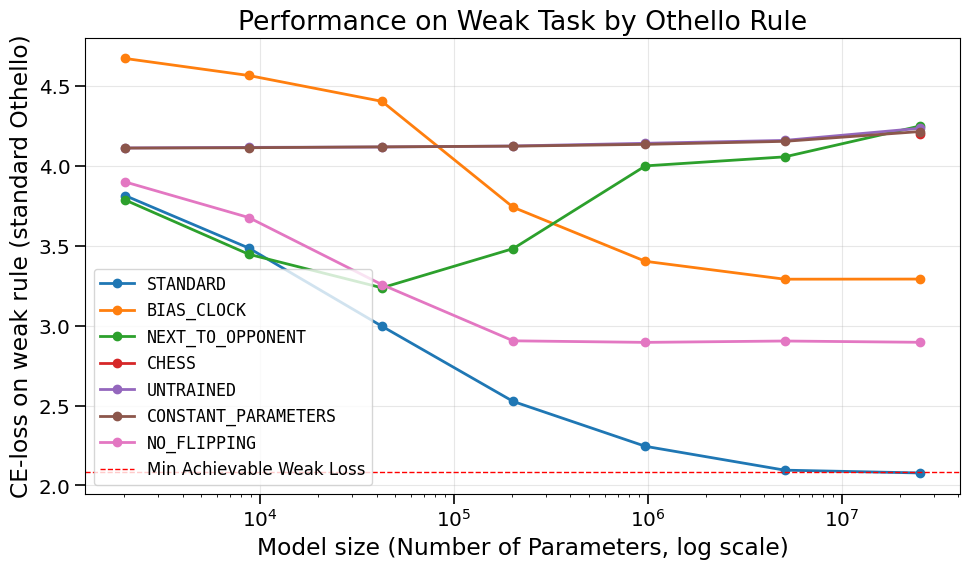

In [74]:
def plot_rule_performance_on_weak_task(
    pretrained_rule_to_result_file: dict[OthelloRule, str],
    pretrained_rule_to_result_file_linear_probe: dict[OthelloRule, str],
    finetuned_rule_to_result_file: dict[tuple[OthelloRule, OthelloRule], str],
    save_path: str | None = None,
):
    """
    Plots performance on weak task (standard Othello) for each othello_rule.

    x-axis: model size (number of parameters, log-scale)
    y-axis: CE-loss on weak rule (standard Othello)

    One line for each othello_rule.
    """
    # Load the data using the existing function
    (
        model_size_to_n_parameters,
        rule_to_model_size_to_CE_loss,
        rule_to_model_size_to_LP_accuracy,
        rule_to_model_size_pair_to_wsg_score,
    ) = load_wsg_precomputed_data(
        pretrained_rule_to_result_file,
        pretrained_rule_to_result_file_linear_probe,
        finetuned_rule_to_result_file,
    )

    # Default colors
    colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
    ]
    rules = list(rule_to_model_size_to_CE_loss.keys())
    rule_to_color = {rule: colors[i % len(colors)] for i, rule in enumerate(rules)}

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plot line for each rule
    for rule, model_size_to_loss in rule_to_model_size_to_CE_loss.items():
        if not model_size_to_loss:  # Skip if no data
            continue

        # Sort by model size for proper line plotting
        sorted_items = sorted(
            model_size_to_loss.items(),
            key=lambda x: model_size_to_n_parameters.get(x[0], 0),
        )

        model_sizes = [item[0] for item in sorted_items]
        losses = [item[1] for item in sorted_items]
        n_parameters = [
            model_size_to_n_parameters[size]
            for size in model_sizes
            if size in model_size_to_n_parameters
        ]

        if len(n_parameters) == len(
            losses
        ):  # Only plot if we have parameter counts for all model sizes
            ax.plot(
                n_parameters,
                losses,
                marker="o",
                label=rule.name,
                color=rule_to_color.get(rule, "#1f77b4"),
                linewidth=2,
                markersize=6,
            )
        else:
            print(
                f"Warning: Missing parameter data for some model sizes in rule {rule.name}"
            )

    # Add horizontal line for minimum achievable weak loss
    ax.axhline(
        y=2.086631,
        color="red",
        linestyle="--",
        linewidth=1,
        label="Min Achievable Weak Loss",
    )

    # Set axes properties
    ax.set_xscale("log")
    ax.set_xlabel("Model size (Number of Parameters, log scale)")
    ax.set_ylabel("CE-loss on weak rule (standard Othello)")
    ax.set_title("Performance on Weak Task by Othello Rule")
    ax.grid(True, alpha=0.3)

    # Create legend with mixed fonts (monospace for rules, regular for reference line)
    legend = ax.legend(prop={"size": 12})
    # Set monospace only for rule labels (all except the last one which is the reference line)
    for i, text in enumerate(legend.get_texts()[:-1]):  # All except last
        text.set_fontfamily("monospace")

    # Adjust layout
    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


save_path = os.path.join(experiment_folder, "rule_performance_weak_task")
plot_rule_performance_on_weak_task(
    pretrained_rule_to_result_file=pretrained_rule_to_result_file,
    pretrained_rule_to_result_file_linear_probe=pretrained_rule_to_result_file_linear_probe,
    finetuned_rule_to_result_file=finetuned_rule_to_result_file,
    save_path=save_path,
)

### finetune_sweep.py

In [ ]:
def finetune_sweep(
    project_name_finetune: str,
    project_name_pretrain: str,
    experiment_folder: str,
    strong_model_sizes_filter: list[ModelSize] | None = None,
):
    weak_rule = get_othello_rule(Goal.WEAK_GOAL)
    strong_rule = get_othello_rule(Goal.STRONG_GOAL)

    weak_strong_pairs = get_weak_strong_pairs()
    for weak_size, strong_size in weak_strong_pairs:
        if strong_model_sizes_filter and strong_size not in strong_model_sizes_filter:
            continue
        print(weak_size, strong_size)

        weak_model = load_model_pretrained(
            project_name=project_name_pretrain,
            model_size=weak_size,
            othello_rule=weak_rule,
            experiment_folder=experiment_folder,
            device=DEVICE,
            index=0,
            final=False,
        )
        strong_model = load_model_pretrained(
            project_name=project_name_pretrain,
            model_size=strong_size,
            othello_rule=strong_rule,
            experiment_folder=experiment_folder,
            device=DEVICE,
            index=0,
            final=False,
        )
        if not weak_model or not strong_model:
            print("Missing: ", weak_size, strong_size)
            continue

        finetune(
            weak_model,
            weak_size,
            weak_rule,
            strong_model,
            strong_size,
            strong_rule,
            weak_finetune_dataset,
            val_dataset,
            othello_rule_to_test,
            experiment_folder,
            project_name_finetune,
        )


project_name_finetune = "finetune_sweep_2_no_flipping"  # 'finetune_sweep_2_constant_parameters'  # 'playground_othello' #
project_name_pretrain = "pretrain_sweep_1"
finetune_sweep(
    project_name_finetune,
    project_name_pretrain,
    experiment_folder,
    strong_model_sizes_filter=[ModelSize.MINI, ModelSize.MICRO, ModelSize.NANO],
)

### plot_finetune_sweep.py

In [ ]:
def compute_loss_finetune_models(
    data_folder: str,
    experiment_folder: str,
    project_name_pretrain: str,
    results_path: str,
    othello_rule_to_test: dict[OthelloRule, CharDataset],
    index: int,
    device: t.device,
    final: bool = True,
    overwrite: bool = False,
) -> tuple[
    dict[ModelSize, int], dict[tuple[ModelSize, ModelSize], tuple[float, float]]
]:
    """
    Returns two dict:
        model_to_size: model_size -> n_parameters
        weak_strong_pair_to_wsg: (weak_model_size, strong_model_size) -> (wsg_pretrained, wsg_finetuned)
    """
    weak_rule = get_othello_rule(Goal.WEAK_GOAL)
    strong_rule = get_othello_rule(Goal.STRONG_GOAL)

    # results_prefix = f"finetune_{weak_rule.value}_{strong_rule.value}_results"
    # results_filename = results_prefix + ".pkl"
    # results_path = os.path.join(experiment_folder, project_name_finetune, results_filename)

    if not overwrite and os.path.exists(results_path):
        print(f"Loading existing results from {results_path}")
        try:
            with open(results_path, "rb") as f:
                model_to_size, weak_strong_pair_to_wsg = pickle.load(f)
            print(f"Loaded existing results")
            return model_to_size, weak_strong_pair_to_wsg
        except Exception as e:
            print(f"Error loading existing results: {e}")
            print("Computing new results...")

    weak_test_dataset = othello_rule_to_test[weak_rule]
    strong_test_dataset = othello_rule_to_test[strong_rule]
    batch_size = 64
    n_games = 1000
    model_to_size = {}
    weak_strong_pair_to_wsg = {}

    # Evaluate models
    weak_strong_pairs = get_weak_strong_pairs()
    for weak_size, strong_size in weak_strong_pairs:
        print(weak_size, strong_size)
        weak_model_weak_rule = load_model_pretrained(
            project_name_pretrain,
            weak_size,
            weak_rule,
            experiment_folder,
            device,
            index,
            final=final,
        )
        strong_model_weak_rule = load_model_pretrained(
            project_name_pretrain,
            strong_size,
            weak_rule,
            experiment_folder,
            device,
            index,
            final=final,
        )
        strong_model_strong_rule = load_model_pretrained(
            project_name_pretrain,
            strong_size,
            strong_rule,
            experiment_folder,
            device,
            index,
            final=final,
        )
        finetuned_model = load_finetuned_model(
            project_name_finetune,
            weak_size,
            weak_rule,
            strong_size,
            strong_rule,
            experiment_folder,
            device,
            index,
            final=False,
        )
        if (
            not weak_model_weak_rule
            or not strong_model_strong_rule
            or not strong_model_weak_rule
            or not finetuned_model
        ):
            print("Missing: ", index, weak_size, strong_size)
            continue

        if not weak_size in model_to_size:
            model_to_size[weak_size] = count_parameters(weak_model_weak_rule)
        if not strong_size in model_to_size:
            model_to_size[strong_size] = count_parameters(strong_model_weak_rule)

        # Evaluate
        n_parameters = count_parameters(finetuned_model)
        loss_weak_model_weak_rule = test_hooked_transformer(
            weak_model_weak_rule,
            weak_rule,
            weak_test_dataset,
            batch_size,
            n_games,
            device,
        )["ce_loss"]
        loss_strong_model_weak_rule = test_hooked_transformer(
            strong_model_weak_rule,
            weak_rule,
            weak_test_dataset,
            batch_size,
            n_games,
            device,
        )["ce_loss"]
        loss_strong_model_strong_rule = test_hooked_transformer(
            strong_model_strong_rule,
            weak_rule,
            weak_test_dataset,
            batch_size,
            n_games,
            device,
        )["ce_loss"]
        loss_finetuned_model = test_hooked_transformer(
            finetuned_model, weak_rule, weak_test_dataset, batch_size, n_games, device
        )["ce_loss"]

        wsg_pretrained = (loss_weak_model_weak_rule - loss_strong_model_strong_rule) / (
            loss_weak_model_weak_rule - loss_strong_model_weak_rule
        )
        wsg_finetuned = (loss_weak_model_weak_rule - loss_finetuned_model) / (
            loss_weak_model_weak_rule - loss_strong_model_weak_rule
        )
        weak_strong_pair_to_wsg[(weak_size, strong_size)] = (
            wsg_pretrained,
            wsg_finetuned,
        )

    results = (model_to_size, weak_strong_pair_to_wsg)
    os.makedirs(os.path.dirname(results_path), exist_ok=True)
    try:
        with open(results_path, "wb") as f:
            pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Results saved to {results_path}")
    except Exception as e:
        print(f"Error saving results: {e}")

    return model_to_size, weak_strong_pair_to_wsg


def plot_finetune_sweep(
    model_to_size: dict[ModelSize, int],
    weak_strong_pair_to_wsg: dict[tuple[ModelSize, ModelSize], tuple[float, float]],
    image_path: str,
    title: str,
    overwrite: bool = False,
    plot_legend: bool = True,
):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get unique weak models and sort them by size for consistent plotting order
    weak_models = sorted(
        set(pair[0] for pair in weak_strong_pair_to_wsg.keys()),
        key=lambda x: model_to_size[x],
    )

    # Create a color map to assign a unique color to each weak model series
    colors = plt.cm.viridis(np.linspace(0, 1, len(weak_models)))

    # Collect all y-values (both pretrain and finetune) to determine a shared y-axis range
    all_y_values = []
    for pre, fine in weak_strong_pair_to_wsg.values():
        all_y_values.extend([pre, fine])

    # Define the y-axis range with a 10% margin for better visualization
    y_min, y_max = min(all_y_values), max(all_y_values)
    y_margin = (y_max - y_min) * 0.1
    y_range = (y_min - y_margin, y_max + y_margin)

    # Iterate through each weak model to plot its corresponding data series
    for i, weak_model in enumerate(weak_models):
        strong_params = []
        wsg_pretrain = []
        wsg_finetune = []

        # Gather data points corresponding to the current weak model
        for (w, s), (pre, fine) in weak_strong_pair_to_wsg.items():
            if w == weak_model:
                strong_params.append(model_to_size[s])
                wsg_pretrain.append(pre)
                wsg_finetune.append(fine)

        # Sort the data by the strong model's size to ensure lines are drawn correctly
        sorted_data = sorted(zip(strong_params, wsg_pretrain, wsg_finetune))
        if sorted_data:
            x, y_pre, y_fine = zip(*sorted_data)

            # Plot finetuned data with a solid line and a label for the weak model
            ax.plot(x, y_fine, "s-", color=colors[i], label=f"{weak_model.value}")
            # Plot pretrained data with a dotted line (no label to avoid clutter)
            ax.plot(x, y_pre, "o:", color=colors[i], alpha=0.5)

    # --- Plot Formatting ---
    ax.set_xscale("log")
    # Use a symmetric log scale for the y-axis to handle positive and negative values
    ax.set_yscale("symlog", linthresh=1.0, linscale=2.0)
    ax.set_xlabel("Strong Model Parameters")
    ax.set_ylabel("PGR")  # Renamed y-axis label
    # ax.set_title(title, fontdict={'family': 'monospace'})
    ax.set_ylim(y_range)

    # Add a horizontal line at y=0 for reference
    ax.axhline(y=0, color="red", linewidth=0.8, alpha=1.0)

    # Add shaded regions to distinguish the logarithmic parts of the y-axis
    ax.axhspan(1, y_range[1], alpha=0.15, color="gray", zorder=0)
    ax.axhspan(y_range[0], -1, alpha=0.15, color="gray", zorder=0)

    # --- Custom Y-axis Ticks for Symlog Scale ---
    linear_ticks = [-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]
    log_ticks_pos = [2, 5, 10, 20, 50, 100] if y_range[1] > 1 else []
    log_ticks_neg = [-2, -5, -10, -20, -50, -100] if y_range[0] < -1 else []

    all_ticks = (
        [t for t in log_ticks_neg if t >= y_range[0]]
        + [-1]
        + linear_ticks
        + [1]
        + [t for t in log_ticks_pos if t <= y_range[1]]
    )
    # Format tick labels for clarity
    tick_labels = [f"{tick:.1f}" if -1 < tick < 1 else f"{tick}" for tick in all_ticks]
    ax.set_yticks(all_ticks)
    ax.set_yticklabels(tick_labels)

    ax.grid(True, alpha=0.3)

    # --- Custom Legend ---
    if plot_legend:
        # Get the handles and labels from the model plots (e.g., for weak model sizes)
        handles, labels = ax.get_legend_handles_labels()

        # Create custom legend entries for the line styles (Finetuned vs. Pretrained)
        linestyle_handles = [
            Line2D([0], [0], color="gray", linestyle="-", lw=2, label="Finetuned"),
            Line2D([0], [0], color="gray", linestyle=":", lw=2, label="Pretrained"),
        ]

        # Combine handles and draw the legend with a title and custom fonts
        ax.legend(
            handles=handles + linestyle_handles,
            title="Weak Model Size",
            # Sets the font for the labels (e.g., 'Weak: 70M')
            prop={"family": "monospace"},
            # Sets the font for the title ('Weak Model Size')
            title_fontproperties={"family": "monospace"},
        )

    # Adjust layout to prevent labels from overlapping
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Adjust bottom to make space for the text

    # Save the plot if a path is provided
    if image_path:
        # Ensure the directory exists
        # os.makedirs(image_path, exist_ok=True)
        if overwrite and os.path.exists(image_path):
            print(f"Overwriting existing file: {image_path}")
            os.remove(image_path)
        # Save the figure with a tight bounding box to minimize whitespace
        print(f"Saving plot to {image_path}")
        plt.savefig(image_path, bbox_inches="tight", pad_inches=0.05, dpi=300)

    plt.show()


othello_rule = OthelloRule.CHESS

project_name_pretrain = "pretrain_sweep_1"
results_path = finetuned_rule_to_result_file[othello_rule]
image_path = results_path[:-4] + ".png"
model_to_size, weak_strong_pair_to_wsg = compute_loss_finetune_models(
    data_folder=data_folder,
    experiment_folder=experiment_folder,
    project_name_pretrain=project_name_pretrain,
    results_path=results_path,
    othello_rule_to_test=othello_rule_to_test,
    index=0,
    device=DEVICE,
    final=False,
    overwrite=False,
)

plot_finetune_sweep(
    model_to_size,
    weak_strong_pair_to_wsg,
    image_path,
    str(othello_rule)[12:].lower(),
    overwrite=True,
    plot_legend=True,
)

### linear_probe_sweep.py

In [ ]:
def linear_probe_pretrained_sweep(
    pretrained_project_name: str,
    project_name: str,
    experiment_folder: str,
    othello_rule: OthelloRule,
    model_size_filter: list[ModelSize],
    train_board_state_dataset: BoardStateDataset,
    val_board_state_dataset: BoardStateDataset,
    othello_rule_to_board_state_test_dataset: dict[
        OthelloRule, list[BoardStateDataset]
    ],
    fake_board_state_transform: FakeBoardStateTransform | None = None,
):
    print("fake_board_state_transform: ", fake_board_state_transform)
    for model_size in model_size_filter:
        print(model_size)
        hooked_model = load_model_pretrained(
            project_name=pretrained_project_name,
            model_size=model_size,
            othello_rule=othello_rule,
            experiment_folder=experiment_folder,
            device=DEVICE,
            index=0,
            final=False,
        )
        if hooked_model is None:
            print(f"Failed to load model for {model_size}, skipping...")
            continue
        layer = int(hooked_model.cfg.n_layers / 4 * 3)
        print(layer)
        train_linear_probe_pretrained(
            hooked_model,
            layer,
            project_name,
            othello_rule,
            model_size,
            experiment_folder,
            train_board_state_dataset,
            val_board_state_dataset,
            othello_rule_to_board_state_test_dataset,
            final=False,
            fake_board_state_transform=fake_board_state_transform,
        )


# linear_probe_pretrained_sweep(
#     "pretrain_sweep_1",
#     "modulo_pretrain_sweep_1_linear_probe",  # "pretrain_sweep_1_linear_probe", "chess_1_linear_probe"
#     # "playground_othello",
#     experiment_folder,
#     OthelloRule.STANDARD,
#     [ModelSize.NANO, ModelSize.MICRO, ModelSize.MINI, ModelSize.SMALL, ModelSize.MEDIUM, ModelSize.LARGE, ModelSize.HUGE],
#     train_board_state_dataset,
#     val_board_state_dataset,
#     othello_rule_to_board_state_test_dataset,
#     fake_board_state_transform=fake_board_state_transform,
# )

In [ ]:
def linear_probe_finetuned_sweep(
    finetuned_project_name: str,
    project_name: str,
    experiment_folder: str,
    notebook_index: int,
    n_notebooks: int,
    train_board_state_dataset: BoardStateDataset,
    val_board_state_dataset: BoardStateDataset,
    othello_rule_to_board_state_test_dataset: dict[
        OthelloRule, list[BoardStateDataset]
    ],
    final: bool,
):
    weak_rule = get_othello_rule(Goal.WEAK_GOAL)
    strong_rule = get_othello_rule(Goal.STRONG_GOAL)

    weak_strong_pairs = get_weak_strong_pairs()
    total_tasks = len(weak_strong_pairs)
    base_tasks_per_notebook = total_tasks // n_notebooks
    extra_tasks = total_tasks % n_notebooks
    if notebook_index < extra_tasks:  # This notebook gets one extra task
        start_idx = notebook_index * (base_tasks_per_notebook + 1)
        end_idx = start_idx + base_tasks_per_notebook + 1
    else:  # This notebook gets base number of tasks
        start_idx = (
            extra_tasks * (base_tasks_per_notebook + 1)
            + (notebook_index - extra_tasks) * base_tasks_per_notebook
        )
        end_idx = start_idx + base_tasks_per_notebook

    print(
        f"Notebook {notebook_index}/{n_notebooks}: Processing tasks {start_idx} to {end_idx - 1} (total: {end_idx - start_idx} tasks)"
    )
    print(weak_strong_pairs[start_idx:end_idx])
    for weak_model_size, strong_model_size in weak_strong_pairs[start_idx:end_idx]:
        print(weak_model_size, strong_model_size)
        hooked_model = load_finetuned_model(
            project_name=finetuned_project_name,
            weak_model_size=weak_model_size,
            weak_rule=weak_rule,
            strong_model_size=strong_model_size,
            strong_rule=strong_rule,
            experiment_folder=experiment_folder,
            device=DEVICE,
            index=0,
            final=final,
        )
        if hooked_model is None:
            print(
                f"Failed to load finetuned model for {weak_model_size}-{strong_model_size}, skipping..."
            )
            continue
        layer = int(hooked_model.cfg.n_layers / 4 * 3)
        print(layer)
        train_linear_probe_finetuned(
            hooked_model,
            layer,
            project_name,
            weak_model_size,
            weak_rule,
            strong_model_size,
            strong_rule,
            experiment_folder,
            train_board_state_dataset,
            val_board_state_dataset,
            othello_rule_to_board_state_test_dataset,
            final,
        )


# linear_probe_finetuned_sweep(
#     finetuned_project_name="finetune_sweep_2_no_flipping",
#     project_name="finetune_sweep_2_no_flipping_linear_probe",
#     # project_name="playground_othello",
#     experiment_folder=experiment_folder,
#     notebook_index=2,
#     n_notebooks=7,
#     train_board_state_dataset=train_board_state_dataset,
#     val_board_state_dataset=val_board_state_dataset,
#     othello_rule_to_board_state_test_dataset=othello_rule_to_board_state_test_dataset,
#     final=False
# )

In [ ]:
!ls '/content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/finetune_sweep_2_untrained'

In [ ]:
def linear_probe_finetuned_over_time_sweep(
    finetuned_project_name: str,
    project_name: str,
    experiment_folder: str,
    weak_rule: OthelloRule,
    weak_model_size: ModelSize,
    strong_rule: OthelloRule,
    strong_model_size: ModelSize,
    steps: list[int],
    notebook_index: int,
    n_notebooks: int,
    train_board_state_dataset: BoardStateDataset,
    val_board_state_dataset: BoardStateDataset,
    othello_rule_to_board_state_test_dataset: dict[
        OthelloRule, list[BoardStateDataset]
    ],
):
    total_tasks = len(steps)
    base_tasks_per_notebook = total_tasks // n_notebooks
    extra_tasks = total_tasks % n_notebooks
    if notebook_index < extra_tasks:  # This notebook gets one extra task
        start_idx = notebook_index * (base_tasks_per_notebook + 1)
        end_idx = start_idx + base_tasks_per_notebook + 1
    else:  # This notebook gets base number of tasks
        start_idx = (
            extra_tasks * (base_tasks_per_notebook + 1)
            + (notebook_index - extra_tasks) * base_tasks_per_notebook
        )
        end_idx = start_idx + base_tasks_per_notebook

    print(
        f"Notebook {notebook_index}/{n_notebooks}: Processing tasks {start_idx} to {end_idx - 1} (total: {end_idx - start_idx} tasks)"
    )
    print(steps[start_idx:end_idx])
    for step_index in steps[start_idx:end_idx]:
        hooked_model = load_finetuned_model(
            project_name=finetuned_project_name,
            weak_model_size=weak_model_size,
            weak_rule=weak_rule,
            strong_model_size=strong_model_size,
            strong_rule=strong_rule,
            experiment_folder=experiment_folder,
            device=DEVICE,
            index=step_index,
            final=False,
        )
        if hooked_model is None:
            print(f"Failed to load finetuned model for step {step_index}, skipping...")
            continue
        layer = int(hooked_model.cfg.n_layers / 4 * 3)
        print(layer)
        train_linear_probe_finetuned(
            hooked_model,
            layer,
            project_name,
            weak_model_size,
            weak_rule,
            strong_model_size,
            strong_rule,
            experiment_folder,
            train_board_state_dataset,
            val_board_state_dataset,
            othello_rule_to_board_state_test_dataset,
            False,
        )


# steps = [10 * n for n in range(0, 40)] + [400 + 60 * n for n in range(20)]
# linear_probe_finetuned_over_time_sweep(
#     finetuned_project_name="finetune_many_checkpoints",
#     project_name="finetune_many_checkpoints_linear_probe",
#     experiment_folder=experiment_folder,
#     weak_rule=OthelloRule.STANDARD,
#     weak_model_size=ModelSize.MINI,
#     strong_rule=OthelloRule.BIAS_CLOCK,
#     strong_model_size=ModelSize.HUGE,
#     steps,
#     notebook_index=0,
#     n_notebooks=10,
#     train_board_state_dataset=train_board_state_dataset,
#     val_board_state_dataset=val_board_state_dataset,
#     othello_rule_to_board_state_test_dataset=othello_rule_to_board_state_test_dataset,
# )

### plot_linear_probe_sweep

In [ ]:
def compute_board_prediction_pretrained(
    experiment_folder: str,
    project_name_linear_probe: str,
    project_name_pretrain: str,
    othello_rule_to_board_state_test_dataset: dict[OthelloRule, BoardStateDataset],
    list_othello_rules: list[OthelloRule],
    index: int,
    device: t.device,
    final: bool = False,
    fake_board_state_transform: FakeBoardStateTransform | None = None,
    overwrite: bool = False,
) -> list[dict]:
    weak_rule = get_othello_rule(Goal.WEAK_GOAL)
    test_board_state_dataset = othello_rule_to_board_state_test_dataset[weak_rule]

    results_filename = f"board_prediction_pretrained.pkl"
    results_path = os.path.join(
        experiment_folder, project_name_linear_probe, results_filename
    )

    if not overwrite and os.path.exists(results_path):
        print(f"Loading existing results from {results_path}")
        try:
            with open(results_path, "rb") as f:
                results = pickle.load(f)
            print(f"Loaded {len(results)} existing results")
            return results
        except Exception as e:
            print(f"Error loading existing results: {e}")
            print("Computing new results...")

    results = []
    if fake_board_state_transform:
        fake_probe = fake_board_state_transform.name
    else:
        fake_probe = ""
    print("fake_board_state_transform: ", fake_board_state_transform)
    print("fake_probe: ", fake_probe)

    for model_size in [
        ModelSize.NANO,
        ModelSize.MICRO,
        ModelSize.MINI,
        ModelSize.SMALL,
        ModelSize.MEDIUM,
        ModelSize.LARGE,
        ModelSize.HUGE,
    ]:
        for othello_rule in list_othello_rules:
            # Load the base model
            model = load_model_pretrained(
                project_name_pretrain,
                model_size,
                othello_rule,
                experiment_folder,
                device,
                index,
                final=final,
            )
            if not model:
                print(f"Missing model: {index}, {model_size}, {othello_rule}")
                continue

            # Load the linear probe
            linear_probe = load_model_pretrained(
                project_name_linear_probe,
                model_size,
                othello_rule,
                experiment_folder,
                device,
                index,
                final=final,
                linear_probe=True,
                fake_probe=fake_probe,
            )
            if linear_probe is None:
                print(f"Missing linear probe: {index}, {model_size}, {othello_rule}")
                model.cpu()
                del model
                t.cuda.empty_cache()
                continue

            # Evaluate probe generalization
            layer = int(model.cfg.n_layers / 4 * 3)
            _, _, _, mean_accuracy_both_on_all = evaluate_probe_generalization(
                probe=linear_probe,
                model=model,
                board_seqs_square_test=test_board_state_dataset.board_seqs_square,
                board_seqs_id_test=test_board_state_dataset.board_seqs_id,
                layer=layer,
                device=device,
                othello_rule=weak_rule,
                plot_results=False,
                fake_board_state_transform=fake_board_state_transform,
            )
            print("mean_accuracy_both_on_all: ", mean_accuracy_both_on_all)

            n_parameters = count_parameters(model)

            results.append(
                {
                    "othello_rule": othello_rule,
                    "model_size": model_size,
                    "n_parameters": n_parameters,
                    "mean_accuracy": mean_accuracy_both_on_all.item(),
                }
            )

            # Clean memory
            model.cpu()
            linear_probe.cpu()
            del model, linear_probe
            t.cuda.empty_cache()
            gc.collect()

    if len(results) == 0:
        print("No models found.")

    os.makedirs(os.path.dirname(results_path), exist_ok=True)
    try:
        with open(results_path, "wb") as f:
            pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Results saved to {results_path}")
    except Exception as e:
        print(f"Error saving results: {e}")

    return results


def plot_board_prediction_pretrained(
    results: list[dict],
    save_path: str | None = None,
    list_othello_rules: list[OthelloRule] = None,
):
    if list_othello_rules is None:
        print("Please provide a list of othello rules to plot")
        return
    df = pd.DataFrame(results)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    unique_rules = df["othello_rule"].unique()
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_rules)))

    # Plot each rule with a different color
    for i, rule in enumerate(unique_rules):
        rule_data = df[df["othello_rule"] == rule]

        sns.lineplot(
            data=rule_data,
            x="n_parameters",
            y="mean_accuracy",
            marker="o",
            linestyle="-",
            ax=ax,
            color=colors[i],
            label=f"Trained on {rule.value}",
        )

    # Formatting
    ax.set_xscale("log")
    ax.set_ylim((0, 1))
    ax.set_xlabel("Number of Parameters (log scale)")
    ax.set_ylabel("Mean Board State Prediction Accuracy")
    ax.set_title("Board State Prediction Accuracy by Othello Rule")
    ax.grid(True, which="both", ls="--", alpha=0.3)
    ax.legend()

    plt.tight_layout()

    if save_path:
        save_dir = os.path.dirname(save_path)
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_path, "board_prediction_pretrained.png")
        try:
            plt.savefig(save_path, bbox_inches="tight", dpi=300)
            print(f"Plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot to {save_path}: {e}")

    plt.show()


# # Example usage:
# project_name_pretrain = 'pretrain_sweep_1'
# project_name_linear_probe = 'modulo_pretrain_sweep_1_linear_probe' # 'pretrain_sweep_1_linear_probe', 'chess_1_linear_probe'
# # list_othello_rules = [othello_rule for othello_rule in OthellRule]
# # print("list_othello_rules: ", list_othello_rules)
# # list_othello_rules = [OthelloRule.STANDARD]  #
# list_othello_rules = [OthelloRule.NO_FLIPPING, OthelloRule.CONSTANT_PARAMETERS, OthelloRule.UNTRAINED, OthelloRule.STANDARD, OthelloRule.BIAS_CLOCK, OthelloRule.NEXT_TO_OPPONENT, OthelloRule.CHESS]
# results = compute_board_prediction_pretrained(
#     experiment_folder=experiment_folder,
#     project_name_linear_probe=project_name_linear_probe,
#     project_name_pretrain=project_name_pretrain,
#     othello_rule_to_board_state_test_dataset=othello_rule_to_board_state_test_dataset,
#     list_othello_rules=list_othello_rules,
#     index=0,
#     device=DEVICE,
#     final=False,
#     fake_board_state_transform=fake_board_state_transform,
#     overwrite=True,
# )

# save_path = os.path.join(experiment_folder, project_name_linear_probe)
# plot_board_prediction_pretrained(results, save_path, list_othello_rules=list_othello_rules)

In [ ]:
def compute_board_prediction_finetuned(
    experiment_folder: str,
    project_name_pretrain: str,
    project_name_finetune: str,
    project_name_pretrained_linear_probe: str,
    project_name_finetuned_linear_probe: str,
    othello_rule_to_test: dict[OthelloRule, CharDataset],
    index: int,
    device: t.device,
    overwrite: bool = False,
) -> tuple[
    dict[ModelSize, int], dict[tuple[ModelSize, ModelSize], tuple[float, float, float]]
]:
    """
    Returns two dict:
        model_to_size: model_size -> n_parameters
        weak_strong_pair_to_wsg: (weak_model_size, strong_model_size) -> (wsg_pretrained, wsg_finetuned, wsg_finetuned_final)
    """
    weak_rule = get_othello_rule(Goal.WEAK_GOAL)
    strong_rule = get_othello_rule(Goal.STRONG_GOAL)

    results_filename = (
        f"board_prediction_finetuned_{weak_rule.value}_{strong_rule.value}.pkl"
    )
    results_path = os.path.join(
        experiment_folder, project_name_pretrain, results_filename
    )

    if not overwrite and os.path.exists(results_path):
        print(f"Loading existing results from {results_path}")
        try:
            with open(results_path, "rb") as f:
                results = pickle.load(f)
            print(f"Loaded {len(results)} existing results")
            return results
        except Exception as e:
            print(f"Error loading existing results: {e}")
            print("Computing new results...")

    weak_test_dataset = othello_rule_to_test[weak_rule]
    test_board_state_dataset = BoardStateDataset(weak_test_dataset, n_games=1000)

    model_to_size = {}
    weak_strong_pair_to_wsg = {}

    # Cache for accuracies: (model_key) -> accuracy
    accuracy_cache = {}

    def get_cached_accuracy(model_key, model, probe, layer):
        """Get accuracy from cache or compute and cache it."""
        if model_key in accuracy_cache:
            print(f"  Using cached accuracy for {model_key}")
            return accuracy_cache[model_key]

        print(f"Computing accuracy for {model_key}")
        _, _, _, accuracy = evaluate_probe_generalization(
            probe,
            model,
            test_board_state_dataset.board_seqs_square,
            test_board_state_dataset.board_seqs_id,
            layer,
            device,
            plot_results=False,
        )
        print("accuracy: ", accuracy)
        accuracy_cache[model_key] = accuracy
        return accuracy

    weak_strong_pairs = get_weak_strong_pairs()
    for weak_size, strong_size in weak_strong_pairs:
        print(
            "----------",
            weak_size,
            strong_size,
            len(weak_strong_pair_to_wsg),
            "----------",
        )

        # Load models
        weak_model_weak_rule = load_model_pretrained(
            project_name_pretrain,
            weak_size,
            weak_rule,
            experiment_folder,
            device,
            index,
            final=False,
        )
        strong_model_weak_rule = load_model_pretrained(
            project_name_pretrain,
            strong_size,
            weak_rule,
            experiment_folder,
            device,
            index,
            final=False,
        )
        strong_model_strong_rule = load_model_pretrained(
            project_name_pretrain,
            strong_size,
            strong_rule,
            experiment_folder,
            device,
            index,
            final=False,
        )
        finetuned_model = load_finetuned_model(
            project_name_finetune,
            weak_size,
            weak_rule,
            strong_size,
            strong_rule,
            experiment_folder,
            device,
            index,
            final=False,
        )
        finetuned_model_final = load_finetuned_model(
            project_name_finetune,
            weak_size,
            weak_rule,
            strong_size,
            strong_rule,
            experiment_folder,
            device,
            index,
            final=True,
        )

        # Load linear probes
        weak_probe = load_model(
            project_name_pretrained_linear_probe,
            weak_size,
            weak_rule,
            experiment_folder,
            device,
            index,
            final=False,
            linear_probe=True,
        )
        strong_weak_probe = load_model(
            project_name_pretrained_linear_probe,
            strong_size,
            weak_rule,
            experiment_folder,
            device,
            index,
            final=False,
            linear_probe=True,
        )
        strong_strong_probe = load_model(
            project_name_pretrained_linear_probe,
            strong_size,
            strong_rule,
            experiment_folder,
            device,
            index,
            final=False,
            linear_probe=True,
        )

        # Load finetuned linear probes using load_finetuned_model
        finetuned_probe = load_finetuned_model(
            project_name=project_name_finetuned_linear_probe,
            weak_model_size=weak_size,
            weak_rule=weak_rule,
            strong_model_size=strong_size,
            strong_rule=strong_rule,
            experiment_folder=experiment_folder,
            device=device,
            index=index,
            final=False,
            linear_probe=True,
        )
        finetuned_probe_final = load_finetuned_model(
            project_name=project_name_finetuned_linear_probe,
            weak_model_size=weak_size,
            weak_rule=weak_rule,
            strong_model_size=strong_size,
            strong_rule=strong_rule,
            experiment_folder=experiment_folder,
            device=device,
            index=index,
            final=True,
            linear_probe=True,
        )

        # Check if all required models/probes are available
        models_and_probes = [
            weak_model_weak_rule,
            strong_model_weak_rule,
            strong_model_strong_rule,
            finetuned_model,
            finetuned_model_final,
            weak_probe,
            strong_weak_probe,
            strong_strong_probe,
            finetuned_probe,
            finetuned_probe_final,
        ]
        if any(item is None for item in models_and_probes):
            print(f"Missing models/probes: {index}, {weak_size}, {strong_size}")
            continue

        # Store model sizes
        if weak_size not in model_to_size:
            model_to_size[weak_size] = count_parameters(weak_model_weak_rule)
        if strong_size not in model_to_size:
            model_to_size[strong_size] = count_parameters(strong_model_weak_rule)

        # Calculate layers
        weak_layer = int(weak_model_weak_rule.cfg.n_layers / 4 * 3)
        strong_layer = int(strong_model_weak_rule.cfg.n_layers / 4 * 3)
        finetuned_layer = int(finetuned_model.cfg.n_layers / 4 * 3)

        # Evaluate board prediction accuracies with caching
        acc_weak_model = get_cached_accuracy(
            f"pretrain_{weak_size}_{weak_rule}",
            weak_model_weak_rule,
            weak_probe,
            weak_layer,
        )
        acc_strong_model_weak_rule = get_cached_accuracy(
            f"pretrain_{strong_size}_{weak_rule}",
            strong_model_weak_rule,
            strong_weak_probe,
            strong_layer,
        )
        acc_strong_model_strong_rule = get_cached_accuracy(
            f"pretrain_{strong_size}_{strong_rule}",
            strong_model_strong_rule,
            strong_strong_probe,
            strong_layer,
        )
        acc_finetuned_model = get_cached_accuracy(
            f"finetune_{weak_size}_{strong_size}_{weak_rule}_to_{strong_rule}_non_final",
            finetuned_model,
            finetuned_probe,
            finetuned_layer,
        )
        acc_finetuned_model_final = get_cached_accuracy(
            f"finetune_{weak_size}_{strong_size}_{weak_rule}_to_{strong_rule}_final",
            finetuned_model_final,
            finetuned_probe_final,
            finetuned_layer,
        )

        # Calculate WSG scores (using accuracy instead of loss, so formula is flipped)
        wsg_pretrained = (acc_strong_model_strong_rule - acc_weak_model) / (
            acc_strong_model_weak_rule - acc_weak_model
        )
        wsg_finetuned = (acc_finetuned_model - acc_weak_model) / (
            acc_strong_model_weak_rule - acc_weak_model
        )
        wsg_finetuned_final = (acc_finetuned_model_final - acc_weak_model) / (
            acc_strong_model_weak_rule - acc_weak_model
        )

        weak_strong_pair_to_wsg[(weak_size, strong_size)] = (
            wsg_pretrained.item(),
            wsg_finetuned.item(),
            wsg_finetuned_final.item(),
        )

        # Clean memory
        for model in [
            weak_model_weak_rule,
            strong_model_weak_rule,
            strong_model_strong_rule,
            finetuned_model,
            finetuned_model_final,
        ]:
            model.cpu()
            del model
        del (
            weak_probe,
            strong_weak_probe,
            strong_strong_probe,
            finetuned_probe,
            finetuned_probe_final,
        )
        t.cuda.empty_cache()

    results = (model_to_size, weak_strong_pair_to_wsg)
    os.makedirs(os.path.dirname(results_path), exist_ok=True)
    try:
        with open(results_path, "wb") as f:
            pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Results saved to {results_path}")
    except Exception as e:
        print(f"Error saving results: {e}")

    return model_to_size, weak_strong_pair_to_wsg


def plot_board_prediction_finetuned(
    model_to_size: dict[ModelSize, int],
    weak_strong_pair_to_wsg: dict[
        tuple[ModelSize, ModelSize], tuple[float, float, float]
    ],
    save_path: str | None = None,
):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Get unique weak models and sort by size
    weak_models = sorted(
        set(pair[0] for pair in weak_strong_pair_to_wsg.keys()),
        key=lambda x: model_to_size[x],
    )

    # Create color map based on weak model parameters
    colors = plt.cm.viridis(np.linspace(0, 1, len(weak_models)))

    # Collect all y-values to determine shared y-axis range
    all_y_values = []
    for (w, s), (pre, fine, fine_final) in weak_strong_pair_to_wsg.items():
        all_y_values.extend([pre, fine, fine_final])

    y_min, y_max = min(all_y_values), max(all_y_values)
    y_margin = (y_max - y_min) * 0.1
    y_range = (y_min - y_margin, y_max + y_margin)

    for i, weak_model in enumerate(weak_models):
        # Get data for this weak model
        strong_params = []
        wsg_pretrain = []
        wsg_finetune = []
        wsg_finetune_final = []

        for (w, s), (pre, fine, fine_final) in weak_strong_pair_to_wsg.items():
            if w == weak_model:
                strong_params.append(model_to_size[s])
                wsg_pretrain.append(pre)
                wsg_finetune.append(fine)
                wsg_finetune_final.append(fine_final)

        # Sort by strong model size
        sorted_data = sorted(
            zip(strong_params, wsg_pretrain, wsg_finetune, wsg_finetune_final)
        )
        if sorted_data:
            x, y_pre, y_fine, y_fine_final = zip(*sorted_data)

            ax1.plot(x, y_pre, "o-", color=colors[i], label=f"{weak_model.value}")
            ax2.plot(x, y_fine, "o-", color=colors[i], label=f"{weak_model.value}")
            ax3.plot(
                x, y_fine_final, "o-", color=colors[i], label=f"{weak_model.value}"
            )

    # Formatting
    titles = ["WSG Pretrained", "WSG Finetuned", "WSG Finetuned Final"]
    for ax, title in zip([ax1, ax2, ax3], titles):
        ax.set_xscale("log")
        ax.set_yscale("symlog", linthresh=1.0, linscale=2.0)
        ax.set_xlabel("Strong Model Parameters")
        ax.set_ylabel("WSG Score (Board Prediction)")
        ax.set_title(title)
        ax.set_ylim(y_range)

        # Add horizontal line at y=0
        ax.axhline(y=0, color="red", linewidth=0.8, alpha=0.8)

        # Add shading for logarithmic regions
        ax.axhspan(1, y_range[1], alpha=0.15, color="gray", zorder=0)
        ax.axhspan(y_range[0], -1, alpha=0.15, color="gray", zorder=0)

        # Custom y-ticks
        linear_ticks = [-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]
        log_ticks_pos = [2, 5, 10, 20, 50, 100] if y_range[1] > 1 else []
        log_ticks_neg = [-2, -5, -10, -20, -50, -100] if y_range[0] < -1 else []

        all_ticks = (
            [t for t in log_ticks_neg if t >= y_range[0]]
            + [-1]
            + linear_ticks
            + [1]
            + [t for t in log_ticks_pos if t <= y_range[1]]
        )

        tick_labels = []
        for tick in all_ticks:
            if tick == 1:
                tick_labels.append("1")
            elif tick == -1:
                tick_labels.append("-1")
            elif -1 < tick < 1:
                tick_labels.append(f"{tick:.1f}")
            else:
                tick_labels.append(f"{tick}")

        ax.set_yticks(all_ticks)
        ax.set_yticklabels(tick_labels)

        # Make linear region ticks smaller
        for j, (tick, label) in enumerate(zip(all_ticks, tick_labels)):
            if -1 < tick < 1 and tick != 0:
                ax.get_yticklabels()[j].set_fontsize(8)

        ax.grid(True, alpha=0.3)
        ax.legend()

    # Add text annotations
    fig.text(
        0.5,
        -0.05,
        "White background: Linear scale [-1,1] | Gray background: Logarithmic scale",
        ha="center",
        fontsize=10,
        style="italic",
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(
            os.path.join(save_path, "wsg_board_prediction.png"),
            bbox_inches="tight",
            dpi=300,
        )

    plt.show()


# # Example usage:
# project_name_pretrain = 'pretrain_sweep_1'
# project_name_finetune = 'finetune_sweep_4_next_to_opponent'
# project_name_pretrained_linear_probe = ''pretrain_sweep_1_linear_probe'
# project_name_finetuned_linear_probe = 'finetune_sweep_4_next_to_opponent_linear_probe'

# model_to_size, weak_strong_pair_to_wsg = compute_board_prediction_finetuned(
#     experiment_folder=experiment_folder,
#     project_name_pretrain=project_name_pretrain,
#     project_name_finetune=project_name_finetune,
#     project_name_pretrained_linear_probe=project_name_pretrained_linear_probe,
#     project_name_finetuned_linear_probe=project_name_finetuned_linear_probe,
#     othello_rule_to_test=othello_rule_to_test,
#     index=0,
#     device=DEVICE,
#     overwrite=False,
# )

# save_path = os.path.join(experiment_folder, project_name_finetune)
# plot_board_prediction_finetuned(model_to_size, weak_strong_pair_to_wsg, save_path)

In [ ]:
def compute_and_save_board_accuracy_finetuned(
    experiment_folder: str,
    project_name_finetune: str,
    project_name_finetuned_linear_probe: str,
    othello_rule_to_board_state_test_dataset: dict[OthelloRule, BoardStateDataset],
    index: int,
    device: t.device,
    overwrite: bool = False,
) -> dict[tuple[ModelSize, ModelSize], float]:
    """
    Computes board representation accuracies for finetuning pairs.
    Returns:
        dict mapping (weak_size, strong_size) -> finetuned_accuracy
    """
    weak_rule = get_othello_rule(Goal.WEAK_GOAL)
    strong_rule = get_othello_rule(Goal.STRONG_GOAL)

    results_filename = (
        f"board_accuracy_finetuned_{weak_rule.value}_{strong_rule.value}.pkl"
    )
    results_path = os.path.join(
        experiment_folder, project_name_finetuned_linear_probe, results_filename
    )

    if not overwrite and os.path.exists(results_path):
        print(f"Loading existing board accuracy results from {results_path}")
        try:
            with open(results_path, "rb") as f:
                results = pickle.load(f)
            print(f"Loaded {len(results)} existing board accuracy results")
            return results
        except Exception as e:
            print(f"Error loading existing results: {e}")
            print("Computing new results...")

    test_board_state_dataset = othello_rule_to_board_state_test_dataset[weak_rule]
    accuracy_results = {}

    weak_strong_pairs = get_weak_strong_pairs()
    for weak_size, strong_size in weak_strong_pairs:
        print("----------", weak_size, strong_size, len(accuracy_results), "----------")
        # Load model
        finetuned_model = load_finetuned_model(
            project_name_finetune,
            weak_size,
            weak_rule,
            strong_size,
            strong_rule,
            experiment_folder,
            device,
            index,
            final=False,
        )

        # Load probe
        finetuned_probe = load_finetuned_model(
            project_name=project_name_finetuned_linear_probe,
            weak_model_size=weak_size,
            weak_rule=weak_rule,
            strong_model_size=strong_size,
            strong_rule=strong_rule,
            experiment_folder=experiment_folder,
            device=device,
            index=index,
            final=False,
            linear_probe=True,
        )

        # Check if all required models/probes are available
        if finetuned_model is None or finetuned_probe is None:
            print(f"Missing models/probes: {index}, {weak_size}, {strong_size}")
            continue

        # Evaluate board prediction accuracies
        layer = int(finetuned_model.cfg.n_layers / 4 * 3)
        _, _, _, accuracy = evaluate_probe_generalization(
            finetuned_probe,
            finetuned_model,
            test_board_state_dataset.board_seqs_square,
            test_board_state_dataset.board_seqs_id,
            layer,
            device,
            weak_rule,
            plot_results=False,
        )
        print("accuracy: ", accuracy)
        accuracy_results[(weak_size, strong_size)] = accuracy.item()

        # Clean memory
        finetuned_model.cpu()
        finetuned_probe.cpu()
        del finetuned_model
        del finetuned_probe
        t.cuda.empty_cache()

    # Save results
    os.makedirs(os.path.dirname(results_path), exist_ok=True)
    try:
        with open(results_path, "wb") as f:
            pickle.dump(accuracy_results, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Board accuracy results saved to {results_path}")
    except Exception as e:
        print(f"Error saving results: {e}")

    return accuracy_results


# # Example usage:
# project_name_finetune = 'finetune_sweep_2_no_flipping' # 'finetune_sweep_4_next_to_opponent'
# project_name_finetuned_linear_probe = 'finetune_sweep_2_no_flipping_linear_probe' # 'finetune_sweep_4_next_to_opponent_linear_probe'
# accuracy_results = compute_and_save_board_accuracy_finetuned(
#     experiment_folder=experiment_folder,
#     project_name_finetune=project_name_finetune,
#     project_name_finetuned_linear_probe=project_name_finetuned_linear_probe,
#     othello_rule_to_board_state_test_dataset=othello_rule_to_board_state_test_dataset,
#     index=0,
#     device=DEVICE,
#     overwrite=False,
# )
# print(accuracy_results)

Loading existing results from /content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/pretrain_1/board_prediction_over_time.pkl
Loaded 51 existing results
Plot saved to /content/drive/MyDrive/Colab Notebooks/WSG_masterthesis/experiments/finetune_many_checkpoints_linear_probe/board_prediction_accuracy_over_time.png


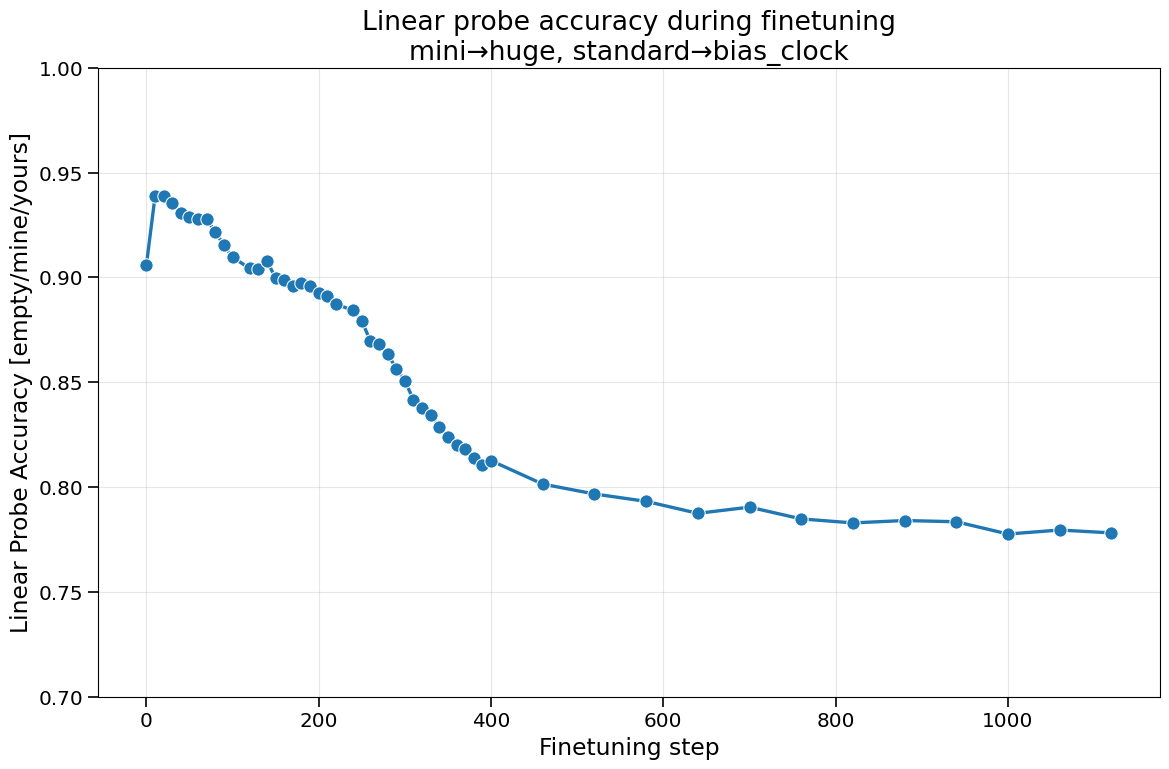

In [59]:
def compute_board_prediction_accuracy_over_time(
    experiment_folder: str,
    finetuned_project_name: str,
    project_name_pretrain: str,
    linear_probe_project_name: str,
    weak_rule: OthelloRule,
    weak_model_size: ModelSize,
    strong_rule: OthelloRule,
    strong_model_size: ModelSize,
    steps: list[int],
    othello_rule_to_board_state_test_dataset: dict[OthelloRule, BoardStateDataset],
    device: t.device,
    overwrite: bool = False,
) -> list[dict]:
    """
    Compute board prediction accuracies for finetuned models at different training steps.

    Returns:
        List of dictionaries with keys: 'step', 'accuracy', 'n_parameters'
    """
    results_filename = f"board_prediction_over_time.pkl"
    results_path = os.path.join(
        experiment_folder, project_name_pretrain, results_filename
    )

    if not overwrite and os.path.exists(results_path):
        print(f"Loading existing results from {results_path}")
        try:
            with open(results_path, "rb") as f:
                results = pickle.load(f)
            print(f"Loaded {len(results)} existing results")
            return results
        except Exception as e:
            print(f"Error loading existing results: {e}")
            print("Computing new results...")

    weak_test_dataset = othello_rule_to_board_state_test_dataset[weak_rule]
    results = []

    for step in steps:
        print(f"Processing step {step}...")

        # Load corresponding linear probe
        linear_probe = load_finetuned_model(
            project_name=linear_probe_project_name,
            weak_model_size=weak_model_size,
            weak_rule=weak_rule,
            strong_model_size=strong_model_size,
            strong_rule=strong_rule,
            experiment_folder=experiment_folder,
            device=device,
            index=step,
            final=False,
            linear_probe=True,
        )

        if linear_probe is None:
            print(f"  Failed to load linear probe for step {step}, skipping...")
            continue

        # Load finetuned model at this step
        finetuned_model = load_finetuned_model(
            project_name=finetuned_project_name,
            weak_model_size=weak_model_size,
            weak_rule=weak_rule,
            strong_model_size=strong_model_size,
            strong_rule=strong_rule,
            experiment_folder=experiment_folder,
            device=device,
            index=step,
            final=False,
        )

        if finetuned_model is None:
            print(f"  Failed to load finetuned model for step {step}, skipping...")
            continue

        try:
            # Evaluate probe accuracy
            layer = int(finetuned_model.cfg.n_layers / 4 * 3)
            _, _, _, mean_accuracy_both_on_all = evaluate_probe_generalization(
                probe=linear_probe,
                model=finetuned_model,
                board_seqs_square_test=weak_test_dataset.board_seqs_square,
                board_seqs_id_test=weak_test_dataset.board_seqs_id,
                layer=layer,
                device=device,
                plot_results=False,
                othello_rule=weak_rule,  # Added missing parameter
            )

            n_parameters = count_parameters(finetuned_model)

            results.append(
                {
                    "step": step,
                    "accuracy": mean_accuracy_both_on_all.item(),
                    "n_parameters": n_parameters,
                    "weak_model_size": weak_model_size,
                    "strong_model_size": strong_model_size,
                    "weak_rule": weak_rule,
                    "strong_rule": strong_rule,
                }
            )

            print(f"  Step {step}: Accuracy = {mean_accuracy_both_on_all.item():.4f}")

        except Exception as e:
            print(f"  Error evaluating step {step}: {e}")

        finally:
            # Clean memory
            if "finetuned_model" in locals():
                finetuned_model.cpu()
                del finetuned_model
            if "linear_probe" in locals():
                del linear_probe
            t.cuda.empty_cache()
            gc.collect()

    print(f"Completed processing {len(results)}/{len(steps)} steps")

    # Save results (fixed the incorrect assignment)
    os.makedirs(os.path.dirname(results_path), exist_ok=True)
    try:
        with open(results_path, "wb") as f:
            pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Results saved to {results_path}")
    except Exception as e:
        print(f"Error saving results: {e}")

    return results


def plot_board_prediction_accuracy_over_time(
    results: list[dict], save_path: str | None = None, title_suffix: str = ""
):
    """
    Plot board prediction accuracy over training steps.

    Args:
        results: List of dictionaries from compute_board_prediction_accuracy_over_time
        save_path: Optional path to save the plot
        title_suffix: Optional suffix to add to plot title
    """
    if not results:
        print("No results to plot")
        return

    df = pd.DataFrame(results)

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Plot accuracy over steps
    sns.lineplot(data=df, x="step", y="accuracy", marker="o", linestyle="-", ax=ax)

    # Formatting
    ax.set_xlabel("Finetuning step")
    ax.set_ylabel("Linear Probe Accuracy [empty/mine/yours]")
    ax.set_ylim((0.7, 1))
    ax.grid(True, alpha=0.3)

    # Create title from the data
    if results:
        sample = results[0]
        weak_size = sample["weak_model_size"].value
        strong_size = sample["strong_model_size"].value
        weak_rule = sample["weak_rule"].value
        strong_rule = sample["strong_rule"].value
        title = f"Linear probe accuracy during finetuning\n{weak_size}→{strong_size}, {weak_rule}→{strong_rule}"
        if title_suffix:
            title += f" {title_suffix}"
        ax.set_title(title)

    # Add some statistics as text
    # if len(results) > 1:
    #     initial_acc = results[0]['accuracy']
    #     final_acc = results[-1]['accuracy']
    #     max_acc = max(r['accuracy'] for r in results)
    #     min_acc = min(r['accuracy'] for r in results)

    #     stats_text = f"Initial: {initial_acc:.3f}\nFinal: {final_acc:.3f}\nMax: {max_acc:.3f}\nMin: {min_acc:.3f}"
    #     ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
    #             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()

    # Save plot
    if save_path:
        save_dir = os.path.dirname(save_path)
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir, exist_ok=True)
        plot_file_path = os.path.join(
            save_path, "board_prediction_accuracy_over_time.png"
        )
        try:
            plt.savefig(plot_file_path, bbox_inches="tight", dpi=300)
            print(f"Plot saved to {plot_file_path}")
        except Exception as e:
            print(f"Error saving plot to {plot_file_path}: {e}")

    plt.show()


# # Example usage:
# steps = [10 * n for n in range(0, 40)] + [400 + 60 * n for n in range(20)]
# # steps = [10]

# results = compute_board_prediction_accuracy_over_time(
#     experiment_folder=experiment_folder,
#     finetuned_project_name="finetune_many_checkpoints",
#     project_name_pretrain="pretrain_1",
#     linear_probe_project_name="finetune_many_checkpoints_linear_probe",
#     weak_rule=OthelloRule.STANDARD,
#     weak_model_size=ModelSize.MINI,
#     strong_rule=OthelloRule.BIAS_CLOCK,
#     strong_model_size=ModelSize.HUGE,
#     steps=steps,
#     othello_rule_to_board_state_test_dataset=othello_rule_to_board_state_test_dataset,
#     device=DEVICE,
#     overwrite=False,
# )

# save_path = os.path.join(experiment_folder, "finetune_many_checkpoints_linear_probe")
# plot_board_prediction_accuracy_over_time(results, save_path)

### plot_all_wsg_results.py

In [61]:
def load_wsg_precomputed_data(
    pretrained_rule_to_result_file: dict[OthelloRule, str],
    pretrained_rule_to_result_file_linear_probe: dict[OthelloRule, str],
    finetuned_rule_to_result_file: dict[tuple[OthelloRule, OthelloRule], str],
):
    if pretrained_rule_to_result_file_linear_probe:
        assert (
            pretrained_rule_to_result_file.keys()
            == pretrained_rule_to_result_file_linear_probe.keys()
        )
    model_size_to_n_parameters = {}  # Top left
    rule_to_model_size_to_CE_loss = {}  # Top right
    rule_to_model_size_to_LP_accuracy = {}  # Bottom left
    rule_to_model_size_pair_to_wsg_score = {}  # What to plot

    def load_pickle(file_path):
        try:
            with open(file_path, "rb") as f:
                return pickle.load(f)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None

    # model_size_to_n_parameters, rule_to_model_size_to_CE_loss
    for rule, path in pretrained_rule_to_result_file.items():
        results = load_pickle(path)
        if results:
            rule_to_model_size_to_CE_loss[rule] = {}
            for res in results:
                if res["othello_rule"] == rule:
                    rule_to_model_size_to_CE_loss[rule][res["model_size"]] = res[
                        "avg_weak_loss"
                    ]
                    model_size_to_n_parameters[res["model_size"]] = res["n_parameters"]

    # rule_to_model_size_to_LP_accuracy
    if pretrained_rule_to_result_file_linear_probe:
        for rule, path in pretrained_rule_to_result_file_linear_probe.items():
            results = load_pickle(path)
            if results:
                rule_to_model_size_to_LP_accuracy[rule] = {}
                for res in results:
                    if res["othello_rule"] == rule:
                        rule_to_model_size_to_LP_accuracy[rule][res["model_size"]] = (
                            res["mean_accuracy"]
                        )

    # rule_to_model_size_pair_to_wsg_score
    for rule, path in finetuned_rule_to_result_file.items():
        results = load_pickle(path)
        if results:
            rule_to_model_size_pair_to_wsg_score[rule] = {}
            for (weak_model_size, strong_model_size), res in results[
                1
            ].items():  # First element of tuple is only model sizes again
                rule_to_model_size_pair_to_wsg_score[rule][
                    (weak_model_size, strong_model_size)
                ] = res[1]

    return (
        model_size_to_n_parameters,
        rule_to_model_size_to_CE_loss,
        rule_to_model_size_to_LP_accuracy,
        rule_to_model_size_pair_to_wsg_score,
    )


def plot_all_wsg_results(
    pretrained_rule_to_result_file: dict[OthelloRule, str],
    pretrained_rule_to_result_file_linear_probe: dict[OthelloRule, str],
    finetuned_rule_to_result_file: dict[tuple[OthelloRule, OthelloRule], str],
    rule_to_marker: dict[OthelloRule, str],
    threshold: float,
    save_path: str | None = None,
):
    """
    Plots all WSG results.
    Top Left:
        x-axis: n_parameters strong model
        y-axis: n_parameters weak model
    Top Right:
        x-axis: strong model CE-loss (on standard rule)
        y-axis: weak model CE-loss (on standard rule)
    Bottom Left:
        x-axis: linear probe accuracy strong model (on standard rule)
        y-axis: linear probe accuracy weak model (on standard rule)

    Each dot is one pair of (weak_model, strong_model).
        color: wsg score (green > 0 and red < 0)
        symbol: strong-model rule
            - Circle: BIAS_CLOCK
            - Square: NEXT_TO_OPPONENT
            - Star: CHESS
    """
    (
        model_size_to_n_parameters,
        rule_to_model_size_to_CE_loss,
        rule_to_model_size_to_LP_accuracy,
        rule_to_model_size_pair_to_wsg_score,
    ) = load_wsg_precomputed_data(
        pretrained_rule_to_result_file,
        pretrained_rule_to_result_file_linear_probe,
        finetuned_rule_to_result_file,
    )

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Plot data
    print(rule_to_model_size_pair_to_wsg_score)
    # Plot data
    counter_positive_wsg = 0
    counter_negative_wsg = 0
    for strong_rule, wsg_pairs in rule_to_model_size_pair_to_wsg_score.items():
        weak_rule = OthelloRule.STANDARD  # Assuming weak is always STANDARD
        marker = rule_to_marker.get(strong_rule, "o")

        for (weak_size, strong_size), wsg_score in wsg_pairs.items():
            alpha, color = wsg_score_to_alpha_color(wsg_score)
            if wsg_score > 0:
                counter_positive_wsg += 1
            else:
                counter_negative_wsg += 1

            # Top Left: n_parameters
            if (
                weak_size in model_size_to_n_parameters
                and strong_size in model_size_to_n_parameters
            ):
                ax1.scatter(
                    model_size_to_n_parameters[strong_size],
                    model_size_to_n_parameters[weak_size],
                    c=color,
                    marker=marker,
                    s=100,
                    alpha=alpha,
                    edgecolors="black",
                    linewidth=0.5,
                )

            # Top Right: CE loss
            if (
                weak_rule in rule_to_model_size_to_CE_loss
                and strong_rule in rule_to_model_size_to_CE_loss
                and weak_size in rule_to_model_size_to_CE_loss[weak_rule]
                and strong_size in rule_to_model_size_to_CE_loss[strong_rule]
            ):
                ax2.scatter(
                    rule_to_model_size_to_CE_loss[strong_rule][strong_size],
                    rule_to_model_size_to_CE_loss[weak_rule][weak_size],
                    c=color,
                    marker=marker,
                    s=100,
                    alpha=alpha,
                    edgecolors="black",
                    linewidth=0.5,
                )

            if (
                weak_rule in rule_to_model_size_to_LP_accuracy
                and strong_rule in rule_to_model_size_to_LP_accuracy
                and weak_size in rule_to_model_size_to_LP_accuracy[weak_rule]
                and strong_size in rule_to_model_size_to_LP_accuracy[strong_rule]
            ):
                ax3.scatter(
                    rule_to_model_size_to_LP_accuracy[strong_rule][strong_size],
                    rule_to_model_size_to_LP_accuracy[weak_rule][weak_size],
                    c=color,
                    marker=marker,
                    s=100,
                    alpha=alpha,
                    edgecolors="black",
                    linewidth=0.5,
                )
            else:
                print(
                    f"Missing data for {weak_rule}→{strong_rule}, {weak_size}→{strong_size}"
                )

    print(
        "Positive WSG score: ",
        counter_positive_wsg,
        " Negative WSG Score: ",
        counter_negative_wsg,
    )
    # Set scales FIRST (before drawing lines)
    ax1.set_xscale("log")
    ax1.set_yscale("log")

    # Add diagonal reference lines (x=y) that extend beyond boundaries
    # For ax1 (parameters plot)
    ax1_xlim = ax1.get_xlim()
    ax1_ylim = ax1.get_ylim()
    # Extend beyond the limits
    extend_factor = 10  # For log scale
    ax1.plot(
        [ax1_xlim[0] / extend_factor, ax1_xlim[1] * extend_factor],
        [ax1_xlim[0] / extend_factor, ax1_xlim[1] * extend_factor],
        "k--",
        alpha=0.5,
        linewidth=1,
    )
    ax1.set_xlim(ax1_xlim)  # Restore original limits
    ax1.set_ylim(ax1_ylim)

    # For ax2 (CE loss plot)
    ax2_xlim = ax2.get_xlim()
    ax2_ylim = ax2.get_ylim()
    # Extend beyond the limits
    extend_range = max(ax2_xlim[1] - ax2_xlim[0], ax2_ylim[1] - ax2_ylim[0])
    ax2.plot(
        [ax2_xlim[0] - extend_range, ax2_xlim[1] + extend_range],
        [ax2_xlim[0] - extend_range, ax2_xlim[1] + extend_range],
        "k--",
        alpha=0.5,
        linewidth=1,
    )
    ax2.set_xlim(ax2_xlim)  # Restore original limits
    ax2.set_ylim(ax2_ylim)

    # For ax3 (linear probe accuracy plot)
    ax3_xlim = ax3.get_xlim()
    ax3_ylim = ax3.get_ylim()
    # Extend beyond the limits
    extend_range = max(ax3_xlim[1] - ax3_xlim[0], ax3_ylim[1] - ax3_ylim[0])
    ax3.plot(
        [ax3_xlim[0] - extend_range, ax3_xlim[1] + extend_range],
        [ax3_xlim[0] - extend_range, ax3_xlim[1] + extend_range],
        "k--",
        alpha=0.5,
        linewidth=1,
    )
    ax3.set_xlim(ax3_xlim)  # Restore original limits
    ax3.set_ylim(ax3_ylim)

    # Set labels and titles
    ax1.set_xlabel("Strong Model Parameters")
    ax1.set_ylabel("Weak Model Parameters")
    ax1.set_title("WSG by Model Parameters")
    ax1.set_xscale("log")
    ax1.set_yscale("log")

    ax2.set_xlabel("Strong Model CE Loss")
    ax2.set_ylabel("Weak Model CE Loss")
    ax2.set_title("WSG by CE Loss")

    ax3.set_xlabel("Strong Model Linear Probe Accuracy")
    ax3.set_ylabel("Weak Model Linear Probe Accuracy")
    ax3.set_title("WSG by Linear Probe Accuracy")

    # Create legend
    legend_elements = []
    for rule, marker in rule_to_marker.items():
        legend_elements.append(
            plt.Line2D(
                [0],
                [0],
                marker=marker,
                color="black",
                linestyle="None",
                markersize=10,
                label=rule.name,
            )
        )
    legend_elements.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="green",
            linestyle="None",
            markersize=10,
            label=f"WSG > {threshold}",
        )
    )
    legend_elements.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="red",
            linestyle="None",
            markersize=10,
            label=f"WSG < -{threshold}",
        )
    )
    legend_elements.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="black",
            linestyle="None",
            markersize=10,
            label=f"-{threshold} < WSG < {threshold}",
        )
    )
    legend_elements.append(
        plt.Line2D([0], [0], color="black", linestyle="--", linewidth=1, label="y = x")
    )

    ax4.legend(handles=legend_elements, loc="center")
    ax4.axis("off")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


# save_path = os.path.join(experiment_folder, 'wsg_all')
# plot_all_wsg_results(
#     pretrained_rule_to_result_file=pretrained_rule_to_result_file,
#     pretrained_rule_to_result_file_linear_probe=pretrained_rule_to_result_file_linear_probe,
#     # pretrained_rule_to_result_file_linear_probe=pretrained_rule_to_result_file_fake_linear_probe,
#     # pretrained_rule_to_result_file_linear_probe=pretrained_rule_to_result_file_black_white_linear_probe,
#     # pretrained_rule_to_result_file_linear_probe=pretrained_rule_to_result_file_modulo_linear_probe,
#     finetuned_rule_to_result_file=finetuned_rule_to_result_file,
#     threshold=THRESHOLD,
#     rule_to_marker=RULE_TO_MARKER,
#     save_path=save_path,
# )

KeyboardInterrupt: 

In [ ]:
def plot_wsg_vs_accuracy_difference(
    pretrained_rule_to_result_file: dict[OthelloRule, str],
    pretrained_rule_to_result_file_linear_probe: dict[OthelloRule, str],
    finetuned_rule_to_result_file: dict[tuple[OthelloRule, OthelloRule], str],
    title: str,
    plot_x: str,
    save_path: str | None = None,
):
    """
    Plots WSG score vs the difference in linear probe accuracy (strong - weak).
    Calculates the accuracy of predicting the sign of the WSG score.
    Uses the same y-axis scaling as plot_wsg_vs_metric.
    """
    rule_to_marker = {
        OthelloRule.CONSTANT_PARAMETERS: "s",
        OthelloRule.UNTRAINED: "D",
        OthelloRule.CHESS: "*",
        OthelloRule.NO_FLIPPING: "o",
        OthelloRule.NEXT_TO_OPPONENT: "P",
        OthelloRule.BIAS_CLOCK: "^",
    }

    fig, ax = plt.subplots(figsize=(10, 6))

    # Use the same data loading function
    (
        model_size_to_n_parameters,
        rule_to_model_size_to_CE_loss,
        rule_to_model_size_to_LP_accuracy,
        rule_to_model_size_pair_to_wsg_score,
    ) = load_wsg_precomputed_data(
        pretrained_rule_to_result_file,
        pretrained_rule_to_result_file_linear_probe,
        finetuned_rule_to_result_file,
    )

    # Collect data points for plotting and correlation analysis
    all_x_values = []  # accuracy differences
    all_y_values = []  # WSG scores
    correct_sign_predictions = 0
    threshold = 0.02

    # Plot data - handle both single rules and tuple keys
    for rule_key, wsg_pairs in rule_to_model_size_pair_to_wsg_score.items():
        # Check if it's a tuple or single rule
        if isinstance(rule_key, tuple):
            weak_rule, strong_rule = rule_key
        else:
            strong_rule = rule_key
            weak_rule = OthelloRule.STANDARD

        marker = rule_to_marker.get(strong_rule, "o")

        for (weak_size, strong_size), wsg_score in wsg_pairs.items():
            # Calculate accuracy difference
            x_value = None
            data_available = False
            if plot_x.startswith("accuracy_difference") or plot_x == "modulo":
                if (
                    weak_rule in rule_to_model_size_to_LP_accuracy
                    and strong_rule in rule_to_model_size_to_LP_accuracy
                    and weak_size in rule_to_model_size_to_LP_accuracy[weak_rule]
                    and strong_size in rule_to_model_size_to_LP_accuracy[strong_rule]
                ):
                    weak_acc = rule_to_model_size_to_LP_accuracy[weak_rule][weak_size]
                    strong_acc = rule_to_model_size_to_LP_accuracy[strong_rule][
                        strong_size
                    ]
                    x_value = strong_acc - weak_acc
                    data_available = True

            elif plot_x == "ce_loss":
                if (
                    weak_rule in rule_to_model_size_to_CE_loss
                    and strong_rule in rule_to_model_size_to_CE_loss
                    and weak_size in rule_to_model_size_to_CE_loss[weak_rule]
                    and strong_size in rule_to_model_size_to_CE_loss[strong_rule]
                ):
                    weak_loss = rule_to_model_size_to_CE_loss[weak_rule][weak_size]
                    strong_loss = rule_to_model_size_to_CE_loss[strong_rule][
                        strong_size
                    ]
                    # x > 0 means strong model is better (has lower loss)
                    x_value = weak_loss - strong_loss
                    data_available = True

            elif plot_x == "n_parameters":
                if (
                    weak_size in model_size_to_n_parameters
                    and strong_size in model_size_to_n_parameters
                ):
                    weak_params = model_size_to_n_parameters[weak_size]
                    strong_params = model_size_to_n_parameters[strong_size]
                    # As requested: Ratio of parameters
                    x_value = np.log(strong_params) - np.log(weak_params)
                    data_available = True

            if data_available and x_value is not None:
                all_x_values.append(x_value)
                all_y_values.append(wsg_score)

                # Check if the sign prediction is correct
                is_positive = (
                    (x_value > 0) if plot_x == "n_parameters" else (x_value > 0)
                )
                if (is_positive and wsg_score > 0) or (
                    not is_positive and wsg_score <= 0
                ):
                    correct_sign_predictions += 1

                # Determine color based on WSG score
                alpha = min(0.9, 0.5 + abs(wsg_score))
                if wsg_score > threshold:
                    color = "green"
                elif wsg_score < -threshold:
                    color = "red"
                else:
                    color = "black"
                    alpha = 0.7

                # Use the generic x_value variable which holds the result for any metric
                ax.scatter(
                    x_value,
                    wsg_score,
                    c=color,
                    marker=marker,
                    s=100,
                    alpha=alpha,
                    edgecolors="black",
                    linewidth=0.5,
                )
            else:
                # Debug: print what's missing
                if weak_rule not in rule_to_model_size_to_LP_accuracy:
                    print(f"Missing weak rule {weak_rule} in LP data")
                elif strong_rule not in rule_to_model_size_to_LP_accuracy:
                    print(f"Missing strong rule {strong_rule} in LP data")
                elif weak_size not in rule_to_model_size_to_LP_accuracy.get(
                    weak_rule, {}
                ):
                    print(f"Missing weak size {weak_size} for rule {weak_rule}")
                elif strong_size not in rule_to_model_size_to_LP_accuracy.get(
                    strong_rule, {}
                ):
                    print(f"Missing strong size {strong_size} for rule {strong_rule}")

    # Check if we have enough data points
    if len(all_x_values) < 2:
        print(
            f"\nWarning: Not enough data points ({len(all_x_values)}) to calculate correlations."
        )
        print(
            "Please check that the data files contain matching model sizes and rules."
        )
        plt.close()
        return

    # Convert to numpy arrays for correlation analysis
    x_arr = np.array(all_x_values)
    y_arr = np.array(all_y_values)

    # Set up y-axis with symlog scale
    y_min, y_max = min(all_y_values), max(all_y_values)
    y_margin = (y_max - y_min) * 0.1
    y_range = (y_min - y_margin, y_max + y_margin)

    ax.set_yscale("symlog", linthresh=1.0, linscale=2.0)
    # --- DYNAMIC X-AXIS LABEL ---
    x_axis_labels = {
        "accuracy_difference": "Linear Probe Accuracy Difference (Strong - Weak) [empty/mine/yours]",
        "accuracy_difference_fake": "LP Accuracy Difference (Strong - Weak) [empty/filled]",
        "accuracy_difference_black_white": "LP Accuracy Difference (Strong - Weak) [empty/black/white]",
        "modulo": "LP Accuracy Difference (Strong - Weak) [linear*board%3]]",
        "ce_loss": "CE Loss Difference (Weak - Strong)",
        "n_parameters": "Parameter Count Log-Ratio (Log(Strong/Weak))",
    }
    ax.set_xlabel(x_axis_labels.get(plot_x, "Metric Difference"))
    ax.set_ylabel("PGR")
    ax.set_title(title)
    ax.set_ylim(y_range)

    # Add horizontal line at y=0
    ax.axhline(y=0, color="red", linewidth=0.8, alpha=0.8)

    # Add vertical line at x=0
    ax.axvline(x=0, color="gray", linewidth=0.5, alpha=0.5, linestyle="--")

    # Add shading for logarithmic regions
    ax.axhspan(1, y_range[1], alpha=0.15, color="gray", zorder=0)
    ax.axhspan(y_range[0], -1, alpha=0.15, color="gray", zorder=0)

    # Custom y-ticks
    linear_ticks = [-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]
    log_ticks_pos = [2, 5, 10, 20, 50, 100] if y_range[1] > 1 else []
    log_ticks_neg = [-2, -5, -10, -20, -50, -100] if y_range[0] < -1 else []

    all_ticks = (
        [t for t in log_ticks_neg if t >= y_range[0]]
        + [-1]
        + linear_ticks
        + [1]
        + [t for t in log_ticks_pos if t <= y_range[1]]
    )

    tick_labels = []
    for tick in all_ticks:
        if tick == 1:
            tick_labels.append("1")
        elif tick == -1:
            tick_labels.append("-1")
        elif -1 < tick < 1:
            tick_labels.append(f"{tick:.1f}")
        else:
            tick_labels.append(f"{tick}")

    ax.set_yticks(all_ticks)
    ax.set_yticklabels(tick_labels)

    ax.grid(True, alpha=0.3)

    # Create legend
    legend_elements = []

    # Add rule markers - extract unique strong rules
    unique_strong_rules = set()
    for rule_key in rule_to_model_size_pair_to_wsg_score.keys():
        if isinstance(rule_key, tuple):
            _, strong_rule = rule_key
        else:
            strong_rule = rule_key
        unique_strong_rules.add(strong_rule)

    for rule, marker in rule_to_marker.items():
        if rule in unique_strong_rules:
            legend_elements.append(
                plt.Line2D(
                    [0],
                    [0],
                    marker=marker,
                    color="black",
                    linestyle="None",
                    markersize=10,
                    label=rule.name,
                )
            )

    # Add color coding
    legend_elements.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="green",
            linestyle="None",
            markersize=10,
            label=f"WSG > {threshold}",
        )
    )
    legend_elements.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="red",
            linestyle="None",
            markersize=10,
            label=f"WSG < -{threshold}",
        )
    )
    legend_elements.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="black",
            linestyle="None",
            markersize=10,
            label=f"-{threshold} < WSG < {threshold}",
        )
    )

    ax.legend(handles=legend_elements)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


plot_x = "accuracy_difference"
if plot_x == "accuracy_difference":
    title_suffix = "difference of LP accuracy in basis (empty/mine/yours)"
    save_path = os.path.join(experiment_folder, "wsg_vs_accuracy_difference")
    pretrained_rule_to_result_file_linear_probe = (
        pretrained_rule_to_result_file_linear_probe
    )
elif plot_x == "accuracy_difference_fake":
    title_suffix = "difference of LP accuracy in basis (empty/filled)"
    save_path = os.path.join(experiment_folder, "wsg_vs_accuracy_difference_fake")
    pretrained_rule_to_result_file_linear_probe = (
        pretrained_rule_to_result_file_fake_linear_probe
    )
elif plot_x == "accuracy_difference_black_white":
    title_suffix = "difference of LP accuracy in basis (empty/black/white)"
    save_path = os.path.join(
        experiment_folder, "wsg_vs_accuracy_difference_black_white"
    )
    pretrained_rule_to_result_file_linear_probe = (
        pretrained_rule_to_result_file_black_white_linear_probe
    )
elif plot_x == "modulo":
    title_suffix = (
        "difference of LP accuracy on highly non-linear board (linear*board%3)"
    )
    save_path = os.path.join(experiment_folder, "wsg_vs_accuracy_difference_modulo")
    pretrained_rule_to_result_file_linear_probe = (
        pretrained_rule_to_result_file_modulo_linear_probe
    )
elif plot_x == "ce_loss":
    title_suffix = "difference CE-loss difference"
    save_path = os.path.join(experiment_folder, "wsg_vs_ce_loss_difference.png")
    # Linear probe data is not needed for this plot
    pretrained_rule_to_result_file_linear_probe = None
elif plot_x == "n_parameters":
    title_suffix = "ratio of parameter counts"
    save_path = os.path.join(experiment_folder, "wsg_vs_n_parameters_ratio.png")
    # Linear probe data is not needed for this plot
    pretrained_rule_to_result_file_linear_probe = None
else:
    raise Exception("Unknown plot_x")

plot_wsg_vs_accuracy_difference(
    pretrained_rule_to_result_file=pretrained_rule_to_result_file,
    pretrained_rule_to_result_file_linear_probe=pretrained_rule_to_result_file_linear_probe,
    finetuned_rule_to_result_file=finetuned_rule_to_result_file,
    plot_x=plot_x,
    title="PGR vs. " + title_suffix,
    save_path=save_path,
)

In [ ]:
def compute_table(
    pretrained_rule_to_result_file: Dict[Any, str],
    pretrained_rule_to_result_file_linear_probe: Dict[Any, str],
    transform_to_pretrained_rule_to_result_file_linear_probe: Dict[str, Dict[Any, str]],
    finetuned_rule_to_result_file: Dict[Any, str],
):
    """
    Loads model performance data, computes differences between weak and strong models,
    and prints a table of correlation metrics against the weak-to-strong generalization (WSG) score.
    """
    # --- Sections 1 & 2 remain unchanged ---

    # --- 1. Data Loading ---
    model_size_to_n_parameters = {}
    rule_to_model_size_to_CE_loss = {}
    rule_to_model_size_to_LP_accuracy = {}
    transform_to_rule_to_model_size_to_LP_accuracy = {}
    rule_to_model_size_pair_to_wsg_score = {}

    def load_pickle(file_path):
        try:
            with open(file_path, "rb") as f:
                return pickle.load(f)
        except Exception as e:
            return None

    for rule, path in pretrained_rule_to_result_file.items():
        results = load_pickle(path)
        if results:
            rule_to_model_size_to_CE_loss[rule] = {
                res["model_size"]: res["avg_weak_loss"]
                for res in results
                if res.get("othello_rule") == rule
            }
            for res in results:
                if res.get("othello_rule") == rule:
                    model_size_to_n_parameters[res["model_size"]] = res["n_parameters"]

    for rule, path in pretrained_rule_to_result_file_linear_probe.items():
        results = load_pickle(path)
        if results:
            rule_to_model_size_to_LP_accuracy[rule] = {
                res["model_size"]: res["mean_accuracy"]
                for res in results
                if res.get("othello_rule") == rule
            }

    for (
        transform_name,
        rule_to_path,
    ) in transform_to_pretrained_rule_to_result_file_linear_probe.items():
        transform_to_rule_to_model_size_to_LP_accuracy[transform_name] = {}
        for rule, path in rule_to_path.items():
            results = load_pickle(path)
            if results:
                transform_to_rule_to_model_size_to_LP_accuracy[transform_name][rule] = {
                    res["model_size"]: res["mean_accuracy"]
                    for res in results
                    if res.get("othello_rule") == rule
                }

    for rule, path in finetuned_rule_to_result_file.items():
        results = load_pickle(path)
        if results:
            rule_to_model_size_pair_to_wsg_score[rule] = results[1]

    # --- 2. Data Aggregation and Calculation ---
    all_data_points = []
    for rule_key, wsg_pairs in rule_to_model_size_pair_to_wsg_score.items():
        weak_rule, strong_rule = (
            rule_key
            if isinstance(rule_key, tuple)
            else (OthelloRule.STANDARD, rule_key)
        )

        for (weak_size, strong_size), wsg_result_tuple in wsg_pairs.items():
            wsg_score = wsg_result_tuple[1]
            point = {"wsg_score": wsg_score}
            try:
                point["N_Params(S) - N_Params(W)"] = (
                    model_size_to_n_parameters[strong_size]
                    - model_size_to_n_parameters[weak_size]
                )
                point["CE Loss(W) - CE Loss(S)"] = (
                    rule_to_model_size_to_CE_loss[weak_rule][weak_size]
                    - rule_to_model_size_to_CE_loss[strong_rule][strong_size]
                )
                if rule_to_model_size_to_LP_accuracy:
                    point["Empty/Mine/Yours: LP-Acc(S) - LP-Acc(W)"] = (
                        rule_to_model_size_to_LP_accuracy[strong_rule][strong_size]
                        - rule_to_model_size_to_LP_accuracy[weak_rule][weak_size]
                    )
                for (
                    name,
                    data,
                ) in transform_to_rule_to_model_size_to_LP_accuracy.items():
                    key = f"{name}: LP Acc(S) - LP Acc(W)"
                    point[key] = (
                        data[strong_rule][strong_size] - data[weak_rule][weak_size]
                    )
                all_data_points.append(point)
            except KeyError:
                continue

    if not all_data_points:
        print(
            "No complete data points found to generate table. Check input files and keys."
        )
        return

    y_wsg_scores = [p["wsg_score"] for p in all_data_points]
    x_variables_data = {
        key: [p[key] for p in all_data_points]
        for key in all_data_points[0]
        if key != "wsg_score"
    }

    def calculate_metrics(x_list: list, y_list: list) -> Tuple[float, float, float]:
        if len(x_list) < 2:
            return (float("nan"), float("nan"), float("nan"))
        x_arr, y_arr = np.array(x_list), np.array(y_list)
        pearson_r, _ = stats.pearsonr(x_arr, y_arr)
        r_squared = pearson_r**2 if not np.isnan(pearson_r) else float("nan")
        spearman_rho, p_value = stats.spearmanr(x_arr, y_arr)
        correct_signs = np.sum(np.sign(x_arr) == np.sign(y_arr))
        sign_accuracy = correct_signs / len(x_arr) if len(x_arr) > 0 else 0
        return r_squared, spearman_rho, p_value, sign_accuracy

    # --- 3. Print Table ---
    # This section is modified to reorder columns and highlight max values.

    results = []
    for name, x_values in x_variables_data.items():
        metrics = calculate_metrics(x_values, y_wsg_scores)
        results.append((name, *metrics))

    # Sort results by the original Sign Accuracy (index 3) to maintain the requested order
    sorted_results = sorted(results, key=lambda item: item[4], reverse=True)

    # Find the maximum value in each metric column for bolding
    if sorted_results:
        # The tuple is (name, r_squared, spearman_rho, sign_accuracy)
        max_r2 = max(item[1] for item in sorted_results)
        max_rho = max(item[2] for item in sorted_results)
        max_acc = max(item[4] for item in sorted_results)
    else:
        # Set to a very low number if no results exist
        max_r2, max_rho, max_acc = float("-inf"), float("-inf"), float("-inf")

    # Define column widths for consistent padding
    max_name_len = (
        max(len(name) for name, _, _, _, _ in sorted_results) if sorted_results else 35
    )
    acc_width = 15
    rho_width = 12
    pval_width = 12
    r2_width = 10
    total_width = max_name_len + acc_width + rho_width + pval_width + r2_width + 10

    print(
        f"\n📈 Correlation Metrics vs. WSG Score (N={len(y_wsg_scores)}) -- Sorted by Sign Accuracy"
    )
    print("-" * total_width)
    # Print the reordered header
    print(
        f"{'X-Variable':<{max_name_len}} | "
        f"{'Sign Accuracy':<{acc_width}} | "
        f"{'Spearman ρ':<{rho_width}} | "
        f"{'p-value':<{pval_width}} | "
        f"{'R²':<{r2_width}}"
    )
    print("-" * total_width)

    # Loop over the sorted results and print each row with new formatting
    for name, r2, rho, p_val, acc in sorted_results:
        # Format each value, adding '**' for bolding if it is the maximum
        acc_str = f"**{acc:.3f}**" if acc == max_acc else f"{acc:.3f}"
        rho_str = f"**{rho:.3f}**" if rho == max_rho else f"{rho:.3f}"
        r2_str = f"**{r2:.3f}**" if r2 == max_r2 else f"{r2:.3f}"
        pval_str = f"{p_val:.2e}"

        # Print the reordered, formatted row with left-justified columns
        print(
            f"{name:<{max_name_len}} | "
            f"{acc_str:<{acc_width}} | "
            f"{rho_str:<{rho_width}} | "
            f"{pval_str:<{pval_width}} | "
            f"{r2_str:<{r2_width}}"
        )
    print("-" * total_width)


transform_to_pretrained_rule_to_result_file_linear_probe = {
    "Empty/Filled": pretrained_rule_to_result_file_fake_linear_probe,
    "Empty/Black/White": pretrained_rule_to_result_file_black_white_linear_probe,
    "Linear*board % 3": pretrained_rule_to_result_file_modulo_linear_probe,
}
compute_table(
    pretrained_rule_to_result_file,
    pretrained_rule_to_result_file_linear_probe,
    transform_to_pretrained_rule_to_result_file_linear_probe,
    finetuned_rule_to_result_file,
)

### plot_wsg_vs_metric.py

In [ ]:
def plot_wsg_vs_metric(
    othello_rule_to_metric: dict,
    finetuned_rule_to_result_file: dict,
    x_axis_name: str,
    title: str,
    save_path: str | None = None,
    x_axis_log: bool = False,
):
    """
    Plots WSG score vs metric for different Othello rules.
    """
    import matplotlib.pyplot as plt
    import pickle
    import numpy as np

    rule_to_marker = {
        OthelloRule.CONSTANT_PARAMETERS: "s",
        OthelloRule.UNTRAINED: "D",
        OthelloRule.CHESS: "*",
        OthelloRule.NO_FLIPPING: "o",
        OthelloRule.NEXT_TO_OPPONENT: "P",
        OthelloRule.BIAS_CLOCK: "^",
    }

    fig, ax = plt.subplots(figsize=(10, 6))

    # Load WSG data
    def load_pickle(file_path):
        try:
            with open(file_path, "rb") as f:
                return pickle.load(f)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None

    rule_to_model_size_pair_to_wsg_score = {}
    for rule, path in finetuned_rule_to_result_file.items():
        results = load_pickle(path)
        if results:
            rule_to_model_size_pair_to_wsg_score[rule] = {}
            for (weak_model_size, strong_model_size), res in results[1].items():
                rule_to_model_size_pair_to_wsg_score[rule][
                    (weak_model_size, strong_model_size)
                ] = res[1]

    # Collect all y-values to determine shared y-axis range
    all_y_values = []
    for rule_data in rule_to_model_size_pair_to_wsg_score.values():
        all_y_values.extend(rule_data.values())

    y_min, y_max = min(all_y_values), max(all_y_values)
    y_margin = (y_max - y_min) * 0.1
    y_range = (y_min - y_margin, y_max + y_margin)

    # Plot data for each rule
    threshold = 0.02
    for rule, ms_to_ms_to_metric in othello_rule_to_metric.items():
        if rule not in rule_to_model_size_pair_to_wsg_score:
            continue

        marker = rule_to_marker.get(rule, "o")

        x_values = []
        y_values = []
        for (weak_size, strong_size), wsg_data in rule_to_model_size_pair_to_wsg_score[
            rule
        ].items():
            if (
                strong_size in ms_to_ms_to_metric
                and weak_size in ms_to_ms_to_metric[strong_size]
            ):
                metric_value = ms_to_ms_to_metric[strong_size][weak_size]
                # Add small offset for zero values to handle log scale
                if metric_value == 0:
                    metric_value = 0.1
                x_values.append(metric_value)
                y_values.append(wsg_data)

                alpha = min(0.9, 0.5 + abs(wsg_data))
                if wsg_data > threshold:
                    color = "green"
                elif wsg_data < -threshold:
                    color = "red"
                else:
                    color = "black"
                    alpha = 0.7

                ax.scatter(
                    metric_value,
                    wsg_data,
                    marker=marker,
                    s=100,
                    c=color,
                    alpha=alpha,
                    edgecolors="black",
                    linewidth=0.5,
                )

        # Add legend entry (single point to avoid duplicates)
        ax.scatter(
            [],
            [],
            marker=marker,
            s=100,
            c="black",
            alpha=0.7,
            edgecolors="black",
            linewidth=0.5,
            label=rule.name,
        )

    # Apply same formatting as plot_finetune_sweep
    if x_axis_log:
        ax.set_xscale("log")
    ax.set_yscale("symlog", linthresh=1.0, linscale=2.0)
    ax.set_xlabel(x_axis_name)
    ax.set_ylabel("PGR")
    ax.set_title(title)
    ax.set_ylim(y_range)

    # Add horizontal line at y=0
    ax.axhline(y=0, color="red", linewidth=0.8, alpha=0.8)

    # Add shading for logarithmic regions
    ax.axhspan(1, y_range[1], alpha=0.15, color="gray", zorder=0)
    ax.axhspan(y_range[0], -1, alpha=0.15, color="gray", zorder=0)

    # Custom y-ticks
    linear_ticks = [-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]
    log_ticks_pos = [2, 5, 10, 20, 50, 100] if y_range[1] > 1 else []
    log_ticks_neg = [-2, -5, -10, -20, -50, -100] if y_range[0] < -1 else []

    all_ticks = (
        [t for t in log_ticks_neg if t >= y_range[0]]
        + [-1]
        + linear_ticks
        + [1]
        + [t for t in log_ticks_pos if t <= y_range[1]]
    )

    tick_labels = []
    for tick in all_ticks:
        if tick == 1:
            tick_labels.append("1")
        elif tick == -1:
            tick_labels.append("-1")
        elif -1 < tick < 1:
            tick_labels.append(f"{tick:.1f}")
        else:
            tick_labels.append(f"{tick}")

    ax.set_yticks(all_ticks)
    ax.set_yticklabels(tick_labels)

    # Make linear region ticks smaller
    # for i, (tick, label) in enumerate(zip(all_ticks, tick_labels)):
    #    if -1 < tick < 1 and tick != 0:
    #        ax.get_yticklabels()[i].set_fontsize(8)

    ax.grid(True, alpha=0.3)

    # Create combined legend with markers and colors
    legend_elements = []

    # Add rule markers
    for rule, marker in rule_to_marker.items():
        if rule in othello_rule_to_metric:
            legend_elements.append(
                plt.Line2D(
                    [0],
                    [0],
                    marker=marker,
                    color="black",
                    linestyle="None",
                    markersize=10,
                    label=rule.name,
                )
            )

    # Add color coding
    legend_elements.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="green",
            linestyle="None",
            markersize=10,
            label=f"PGR > {threshold}",
        )
    )
    legend_elements.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="red",
            linestyle="None",
            markersize=10,
            label=f"PGR < -{threshold}",
        )
    )
    legend_elements.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="black",
            linestyle="None",
            markersize=10,
            label=f"-{threshold} < PGR < {threshold}",
        )
    )

    ax.legend(handles=legend_elements, loc="lower left")

    # Add text annotations
    # fig.text(0.5, -0.05, 'White background: Linear scale [-1,1] | Gray background: Logarithmic scale',
    #           ha='center', fontsize=10, style='italic')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


save_path = os.path.join(experiment_folder, "optimization_step")
plot_wsg_vs_metric(
    othello_rule_to_optimization_step,
    finetuned_rule_to_result_file,
    x_axis_name="Early-stop optimization step based on ground-truth labels",
    title="PGR vs. Optimzation step at which ground truth validation is minimized",
    save_path=save_path,
    x_axis_log=True,
)

In [ ]:
def load_board_accuracy_degradation_metric(
    finetuned_rule_to_result_file_linear_probe: dict,
    pretrained_rule_to_result_file_linear_probe: dict,
) -> dict:
    """
    Computes degradation metric: pretrained_accuracy - finetuned_accuracy

    Returns:
        dict mapping OthelloRule -> ModelSize (strong) -> ModelSize (weak) -> degradation
    """
    import pickle

    def load_pickle(file_path):
        try:
            with open(file_path, "rb") as f:
                return pickle.load(f)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None

    # Load pretrained accuracies
    pretrained_accuracies = {}
    for rule, path in pretrained_rule_to_result_file_linear_probe.items():
        results = load_pickle(path)
        if results:
            pretrained_accuracies[rule] = {}
            for res in results:
                if res["othello_rule"] == rule:
                    pretrained_accuracies[rule][res["model_size"]] = res[
                        "mean_accuracy"
                    ]

    # Load finetuned accuracies and compute degradation
    othello_rule_to_metric = {}

    for rule, path in finetuned_rule_to_result_file_linear_probe.items():
        finetuned_results = load_pickle(path)
        if finetuned_results and rule in pretrained_accuracies:
            othello_rule_to_metric[rule] = {}

            for (
                weak_size,
                strong_size,
            ), finetuned_accuracy in finetuned_results.items():
                # Get pretrained accuracy for strong model
                if strong_size in pretrained_accuracies[rule]:
                    pretrained_accuracy = pretrained_accuracies[rule][strong_size]
                    degradation = finetuned_accuracy - pretrained_accuracy

                    if strong_size not in othello_rule_to_metric[rule]:
                        othello_rule_to_metric[rule][strong_size] = {}
                    othello_rule_to_metric[rule][strong_size][weak_size] = degradation

    return othello_rule_to_metric


# Generate the degradation metric
othello_rule_to_degradation = load_board_accuracy_degradation_metric(
    finetued_rule_to_result_file_linear_probe,  # First parameter should be linear probe
    pretrained_rule_to_result_file_linear_probe,
)

# Create the plot
save_path = os.path.join(experiment_folder, "board_accuracy_degradation")
plot_wsg_vs_metric(
    othello_rule_to_degradation,
    finetuned_rule_to_result_file,  # Second parameter should be WSG results
    x_axis_name="Change in Linear Probe accuracy [Acc(Finetuned) - Acc(Pretrained)]",
    title="WSG vs Change in Representations during Finetuning",
    save_path=save_path,
)

In [ ]:
from typing import *

# --- Random ---

In [80]:
import torch as t
import numpy as np

# Get example game and extract moves 10-11
example_game = [to_square(i) for i in train_dataset[0][0].tolist()]
game_ids = to_id(example_game)

# Get board states for moves 10-11
board_states = t.zeros((2, 8, 8), dtype=t.int32)
board = OthelloBoardState()
for i, token_id in enumerate(game_ids[:12]):  # Up to move 11
    board.umpire(id_to_square(token_id))
    if i >= 10:  # Save moves 10-11
        board_states[i - 10] = t.from_numpy(board.state)

# Create 4 different basis transformations
basis_states = t.zeros((2, 4, 8, 8), dtype=t.int32)

for move_idx in range(2):
    state = board_states[move_idx]
    current_player = -1 if (10 + move_idx) % 2 == 0 else 1  # Black starts

    # Basis 1: empty/mine/yours
    mine_mask = state == current_player
    yours_mask = state == -current_player
    basis_states[move_idx, 0] = mine_mask.long() + 2 * yours_mask.long()

    # Basis 2: empty/white/black
    white_mask = state == 1
    black_mask = state == -1
    basis_states[move_idx, 1] = white_mask.long() + 2 * black_mask.long()

    # Basis 3: empty/filled
    basis_states[move_idx, 2] = (state != 0).long()

    # Basis 4: non-linear transformation
    transform = FakeBoardStateTransformModulo()
    fake_state = transform(state.unsqueeze(0).unsqueeze(0)).squeeze()
    basis_states[move_idx, 3] = fake_state

# Flatten for plotting (2*4 = 8 boards)
all_states = basis_states.view(8, 8, 8)
titles = []
for move in [10, 11]:
    titles.extend(
        [
            f"Move {move}: Mine/Yours",
            f"Move {move}: White/Black",
            f"Move {move}: Empty/Filled",
            f"Move {move}: Non-linear",
        ]
    )

# Plot directly with plotly for 0,1,2 values
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplot grid
fig = make_subplots(
    rows=2, cols=4, subplot_titles=titles, vertical_spacing=0.1, horizontal_spacing=0.05
)

# Custom colorscale for 0=white, 1=grey, 2=black
colorscale = [[0, "grey"], [0.5, "white"], [1, "black"]]

for i in range(8):
    row = i // 4 + 1
    col = i % 4 + 1

    fig.add_trace(
        go.Heatmap(
            z=all_states[i].numpy(),
            colorscale=colorscale,
            zmin=0,
            zmax=2,
            showscale=False,
            xaxis=f"x{i + 1}",
            yaxis=f"y{i + 1}",
        ),
        row=row,
        col=col,
    )

# Update layout
fig.update_layout(height=600, width=1200)
fig.update_xaxes(tickvals=list(range(8)), ticktext=[str(i) for i in range(8)])
fig.update_yaxes(tickvals=list(range(8)), ticktext=list("ABCDEFGH"))
fig.show()

In [ ]:
def calculate_leakage_by_train_games(
    train_data: "CharDataset",
    test_data: "CharDataset",
    train_subset_size: int = 10000,
    batch_size: int = 10000,
    ordered_moves: bool = True,
) -> int:
    if len(train_data.data) > train_subset_size:
        train_subset = random.sample(train_data.data, train_subset_size)
    else:
        train_subset = train_data.data
    train_games_to_check = {tuple(game) for game in train_subset}

    leaked_count = 0
    num_test_batches = (len(test_data.data) + batch_size - 1) // batch_size
    test_iterator = tqdm(range(num_test_batches), desc="🔍 Checking test batches")

    for i in test_iterator:
        if not train_games_to_check:
            break

        start_idx = i * batch_size
        test_batch = test_data.data[start_idx : start_idx + batch_size]
        current_test_prefixes = {
            tuple(game[:l]) if ordered_moves else tuple(sorted(game[:l]))
            for game in test_batch
            for l in range(1, len(game) + 1)
        }

        found_in_batch = set()
        for train_game in train_games_to_check:
            for l in range(1, len(train_game) + 1):
                train_prefix = (
                    tuple(train_game[:l])
                    if ordered_moves
                    else tuple(sorted(train_game[:l]))
                )
                if train_prefix in current_test_prefixes:
                    found_in_batch.add(train_game)
                    break

        if found_in_batch:
            leaked_count += len(found_in_batch)
            train_games_to_check -= found_in_batch

        test_iterator.set_postfix(
            {"Leaked": leaked_count, "Remaining": len(train_games_to_check)}
        )

    return leaked_count


leaked_game_count = calculate_leakage_by_train_games(
    train_dataset,
    test_dataset,
    train_subset_size=10000,
    batch_size=10000,  # Small batch size for demonstration
)

print("\n--- Results ---")
print(f"Total leaked training games found: {leaked_game_count}")

In [ ]:
print(len(train_dataset) / (100 * 512))

In [ ]:
def calculate_leakage_by_train_games(
    train_data: "CharDataset",
    test_data: "CharDataset",
    train_subset_size: int = 10000,
    batch_size: int = 10000,
    ordered_moves: bool = True,
) -> int:
    train_games_to_check = random.sample(train_data.data, train_subset_size)
    leaked_count = 0
    num_test_batches = (len(test_data.data) + batch_size - 1) // batch_size
    test_iterator = tqdm(range(num_test_batches), desc="🔍 Checking test batches")

    for i in test_iterator:
        if not train_games_to_check:
            break

        start_idx = i * batch_size
        test_batch = test_data.data[start_idx : start_idx + batch_size]
        current_test_prefixes = {
            tuple(game[:l]) if ordered_moves else tuple(sorted(game[:l]))
            for game in test_batch
            for l in range(1, len(game) + 1)
        }

        found_in_batch = set()
        for train_game in train_games_to_check:
            for l in range(1, len(train_game) + 1):
                train_prefix = (
                    tuple(train_game[:l])
                    if ordered_moves
                    else tuple(sorted(train_game[:l]))
                )
                if train_prefix in current_test_prefixes:
                    found_in_batch.add(train_game)
                    break

        if found_in_batch:
            leaked_count += len(found_in_batch)
            train_games_to_check -= found_in_batch
            if leaked_count % 10:
                print(leaked_count)

        test_iterator.set_postfix(
            {"Leaked": leaked_count, "Remaining": len(train_games_to_check)}
        )

    return leaked_count


leaked_game_count = calculate_leakage_by_train_games(
    train_dataset,
    test_dataset,
    train_subset_size=1,
    batch_size=100000,  # Small batch size for demonstration
)

print("\n--- Results ---")
print(f"Total leaked training games found: {leaked_game_count}")

In [ ]:
hooked_model = convert_and_verify(trainer.model.module, mconf, val_dataset)

In [ ]:
import gc

del hooked_model
t.cuda.empty_cache()
gc.collect()

In [ ]:
# def load_model(checkpoint_path, model_config):
#    model = GPT(model_config)
#    model.load_state_dict(t.load(checkpoint_path, map_location='cpu'))
#    model.to(DEVICE)
#    return model

# checkpoint_path = experiment_folder + 'TEST_MODEL_2025-06-24-22-48-39/ckpts/gpt_at_20250624_224839.ckpt'  # Self trained GPT
# checkpoint_path = experiment_folder + 'TEST_MODEL_2025-06-28-15-20-17/ckpts/gpt_at_20250628_152017.ckpt'  # Biased, trained on smaller dataset
# checkpoint_path = experiment_folder + 'TEST_MODEL_2025-06-28-15-02-06/ckpts/gpt_at_20250628_150206.ckpt'  # Hald trained standard model
# model_2 = load_model(checkpoint_path, mconf)

In [ ]:
# hooked_model_2 = convert_and_verify(model_2, mconf, test_dataset)

# results = test_hooked_transformer(hooked_model_2, test_dataset=val_dataset, batch_size=512, n_games=100, device=DEVICE)
# print("")
# print(f"Validation CE Loss: {results['ce_loss']:.6f}")
# print(f"Illegal Move %: {results['illegal_move_percentage']:.6f}%")
# print(f"Total Predictions: {results['total_predictions']}")